# Blue Team Task

In [2]:
#Mount personal Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Standard libraries
import os
import warnings
from collections import Counter
from copy import deepcopy
import itertools

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Machine learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset

import torchvision.models as models
import torchvision.transforms as transforms

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve,
    precision_recall_curve, auc, confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.model_selection import StratifiedKFold, KFold, ParameterGrid, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.utils import resample

# Image processing
from skimage.transform import resize
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
from tqdm import tqdm

/Users/danielfahmi/anaconda3/envs/blue_team_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/danielfahmi/anaconda3/envs/blue_team_env/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# If Google Colab,
def load_datasets():
    ad_val_data = torch.load('AD_val.pt', weights_only=False)
    ad_test_data = torch.load('AD_test.pt', weights_only=False)
    ood_val_data = torch.load('OOD_val.pt', weights_only=False)
    ood_test_data = torch.load('OOD_test.pt', weights_only=False)
    dataset_data = torch.load('dataset.pt', weights_only=False)
    return ad_val_data, ad_test_data, ood_val_data, ood_test_data, dataset_data

# Load datasets
ad_val_data, ad_test_data, ood_val_data, ood_test_data, dataset_data = load_datasets()

In [4]:
# If Google Colab,
def load_datasets():
    ad_val_data = torch.load('/content/drive/MyDrive/COMP90073/Assignment2/A2-data/AD_val.pt', weights_only=False)
    ad_test_data = torch.load('/content/drive/MyDrive/COMP90073/Assignment2/A2-data/AD_test.pt', weights_only=False)
    ood_val_data = torch.load('/content/drive/MyDrive/COMP90073/Assignment2/A2-data/OOD_val.pt', weights_only=False)
    ood_test_data = torch.load('/content/drive/MyDrive/COMP90073/Assignment2/A2-data/OOD_test.pt', weights_only=False)
    dataset_data = torch.load('/content/drive/MyDrive/COMP90073/Assignment2/A2-data/dataset.pt', weights_only=False)
    return ad_val_data, ad_test_data, ood_val_data, ood_test_data, dataset_data

# Load datasets
ad_val_data, ad_test_data, ood_val_data, ood_test_data, dataset_data = load_datasets()

In [3]:
def flatten(data, expect_labels=True, flatten_images=True):
    processed = []
    for idx, item in enumerate(data):
        if expect_labels:
            if isinstance(item, (tuple, list)) and len(item) == 2:
                image, _ = item
            else:
                raise ValueError(f"Expected tuple with 2 elements, got {item} at index {idx}")
        else:
            if isinstance(item, (tuple, list)) and len(item) == 1:
                image = item[0]
            elif isinstance(item, torch.Tensor):
                image = item
            else:
                raise ValueError(f"Expected single image tensor, got {item} at index {idx}")

        if flatten_images:
            processed.append(image.numpy().flatten())
        else:
            processed.append(image.numpy())

    return np.array(processed)

def preprocess_data(dataset_data, ad_val_data, ood_val_data, ad_test_data, ood_test_data, flatten_images=True):
    # Process the images
    X_train = flatten(dataset_data, expect_labels=True, flatten_images=flatten_images)
    X_val_ad = flatten(ad_val_data, expect_labels=True, flatten_images=flatten_images)
    X_val_ood = flatten(ood_val_data, expect_labels=True, flatten_images=flatten_images)
    X_test_ad = flatten(ad_test_data, expect_labels=False, flatten_images=flatten_images)
    X_test_ood = flatten(ood_test_data, expect_labels=False, flatten_images=flatten_images)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
    X_val_ad_scaled = scaler.transform(X_val_ad.reshape(X_val_ad.shape[0], -1))
    X_val_ood_scaled = scaler.transform(X_val_ood.reshape(X_val_ood.shape[0], -1))
    X_test_ad_scaled = scaler.transform(X_test_ad.reshape(X_test_ad.shape[0], -1))
    X_test_ood_scaled = scaler.transform(X_test_ood.reshape(X_test_ood.shape[0], -1))

    # Extract labels
    y_train = np.array([label for _, label in dataset_data])
    y_val_ad_true = np.array([label for _, label in ad_val_data])
    y_val_ood_true = np.array([label for _, label in ood_val_data])

    return (
        X_train_scaled, y_train,
        X_val_ad_scaled, y_val_ad_true,
        X_val_ood_scaled, y_val_ood_true,
        X_test_ad_scaled, X_test_ood_scaled,
        scaler
    )



# Preprocess the data
X_train_scaled, y_train, X_val_ad_scaled, y_val_ad_true, X_val_ood_scaled, y_val_ood_true, X_test_ad_scaled, X_test_ood_scaled, scaler = preprocess_data(
    dataset_data, ad_val_data, ood_val_data, ad_test_data, ood_test_data, flatten_images=True
)


## Data exploration and Pre-processing

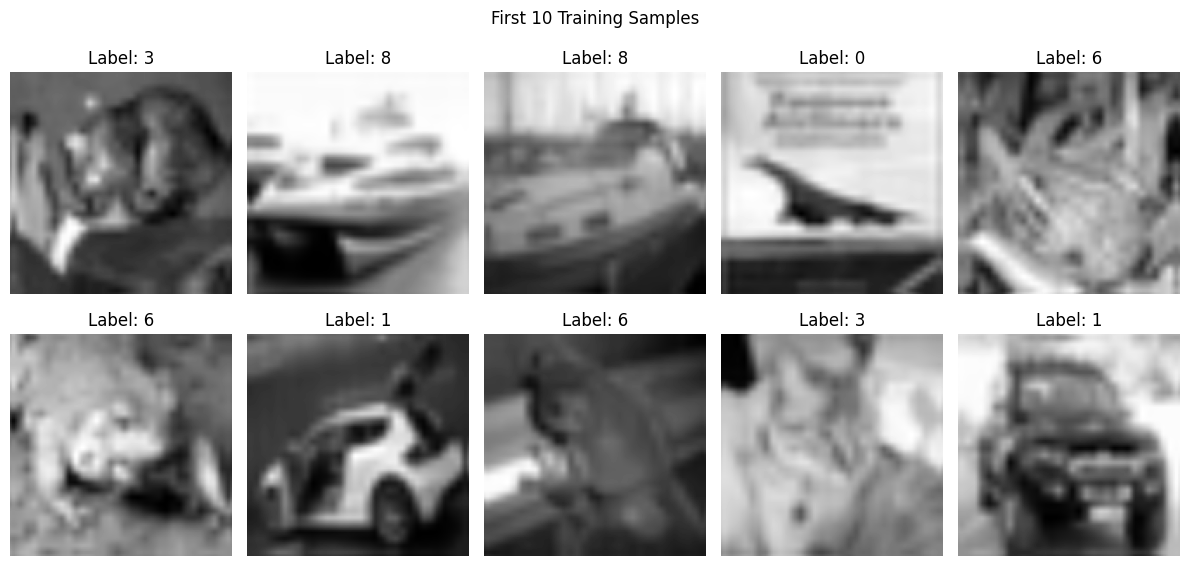

In [ ]:
def rescale_image(image):
    image_min = image.min()
    image_max = image.max()
    return 255 * (image - image_min) / (image_max - image_min)

def show_samples(dataset, title="Samples", num_samples=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        image, label = dataset[i]
        processed_image = resize(rescale_image(np.squeeze(image)), (128, 128), anti_aliasing=True)
        plt.subplot(2, 5, i+1)
        plt.imshow(processed_image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(dataset_data, title="First 10 Training Samples")

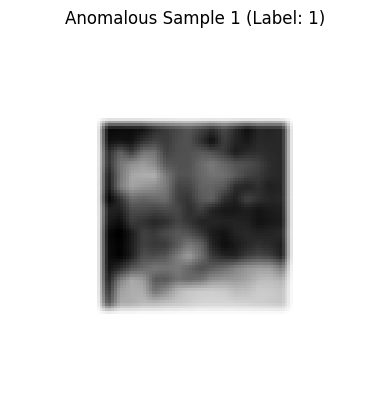

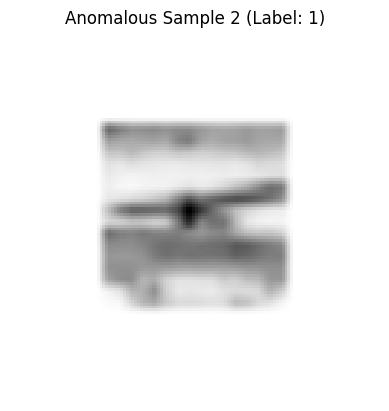

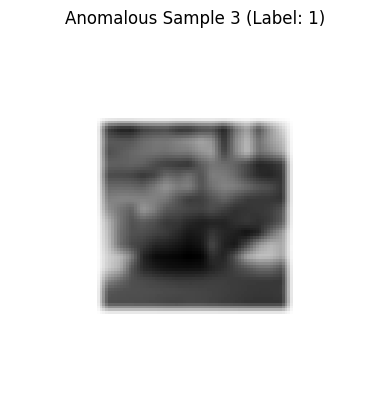

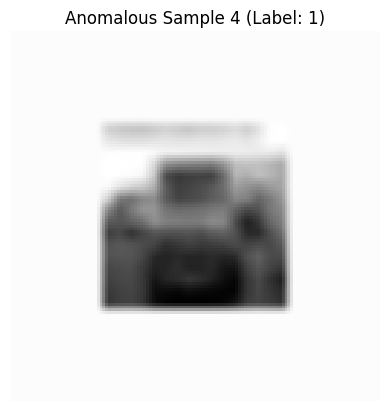

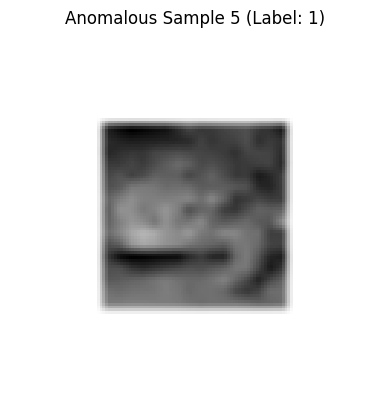

In [ ]:
images, labels = zip(*ad_val_data)

# Convert the lists to numpy arrays
images = np.array([image.numpy() for image in images])
labels = np.array(labels)


anomalous_images = images[labels == 1]


for i in range(min(5, len(anomalous_images))):
    image = anomalous_images[i]
    processed_image = resize(rescale_image(np.squeeze(image)), (128, 128), anti_aliasing=True)

    plt.imshow(processed_image, cmap='gray', interpolation='none')
    plt.title(f"Anomalous Sample {i+1} (Label: 1)")
    plt.axis('off')
    plt.show()

The anomalous samples are not just different in pixel intensity, but also in the shape of the digit. Some anomalous samples even become completely unrecognizable.

In [ ]:
# Inspect the dataset contents

print(f"AD Validation Data Type: {type(ad_val_data)}")
print(f"AD Test Data Type: {type(ad_test_data)}")
print(f"OOD Validation Data Type: {type(ood_val_data)}")
print(f"OOD Test Data Type: {type(ood_test_data)}")
print(f"Training Dataset Data Type: {type(dataset_data)}")

print("\n")

print(f"Number of items in the training dataset: {len(dataset_data)}")
print(f"Number of items in the AD validation dataset: {len(ad_val_data)}")
print(f"Number of items in the AD test dataset: {len(ad_test_data)}")
print(f"Number of items in the OOD validation dataset: {len(ood_val_data)}")
print(f"Number of items in the OOD test dataset: {len(ood_test_data)}")


AD Validation Data Type: <class 'torch.utils.data.dataset.TensorDataset'>
AD Test Data Type: <class 'torch.utils.data.dataset.TensorDataset'>
OOD Validation Data Type: <class 'torch.utils.data.dataset.TensorDataset'>
OOD Test Data Type: <class 'torch.utils.data.dataset.TensorDataset'>
Training Dataset Data Type: <class 'torch.utils.data.dataset.TensorDataset'>


Number of items in the training dataset: 10000
Number of items in the AD validation dataset: 2000
Number of items in the AD test dataset: 10000
Number of items in the OOD validation dataset: 5000
Number of items in the OOD test dataset: 10000


This is considered as small dataset. For benchmarking, ImageNet has over 1 million images, and CIFAR-10 has 60,000 images.

Small dataset prone to overfitting. To combat that:
1. Perform data augmentation during training
2. Use transfer learning with a deep learning model pre-trained on a larger dataset
3. Apply regularization techniques such as weight decay, dropout, etc.
4. Consider using simpler models or ensemble methods
5. Implement cross-validation for more robust evaluation

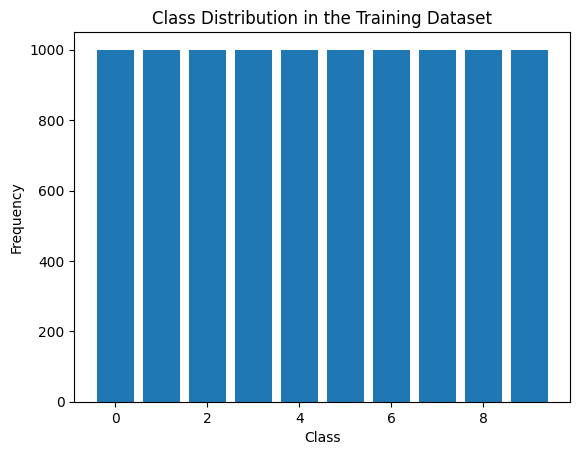

In [ ]:
def extract_class_labels(dataset):
    return [int(label) for _, label in dataset]

def plot_class_distribution(ax, distribution, title, color):
    ax.bar([0, 1], [distribution.get(0, 0), distribution.get(1, 0)], color=color)
    ax.set_xticks([0, 1])
    ax.set_xlabel("Class")
    ax.set_ylabel("Frequency")
    ax.set_title(title)

# Extract class labels for training dataset
train_labels = extract_class_labels(dataset_data)
class_distribution = Counter(train_labels)

# Plot the class distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution in the Training Dataset")
plt.show()

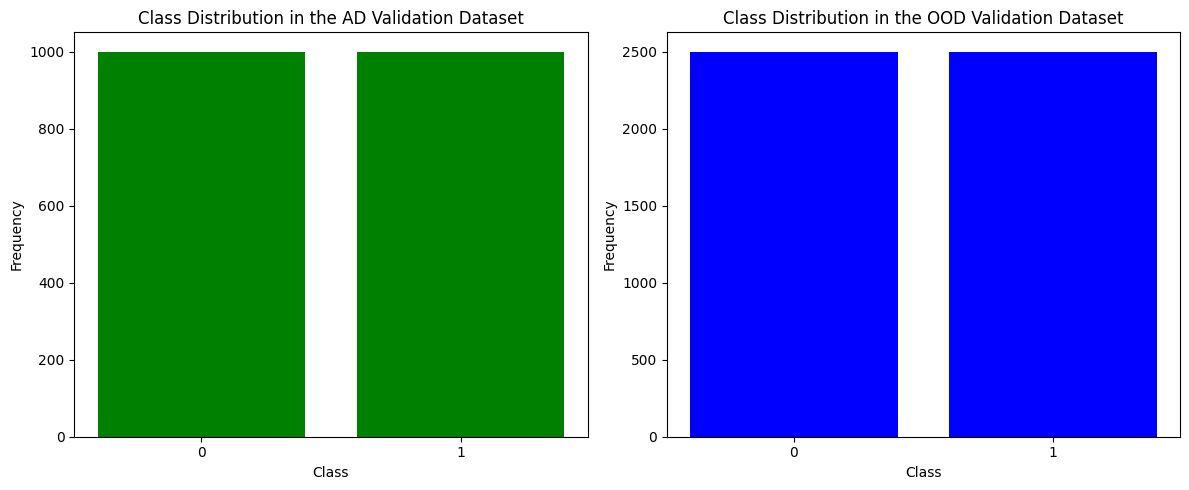

In [ ]:
ad_val_labels = extract_class_labels(ad_val_data)
ood_val_labels = extract_class_labels(ood_val_data)

ad_val_class_distribution = Counter(ad_val_labels)
ood_val_class_distribution = Counter(ood_val_labels)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_class_distribution(ax1, ad_val_class_distribution, "Class Distribution in the AD Validation Dataset", 'g')
plot_class_distribution(ax2, ood_val_class_distribution, "Class Distribution in the OOD Validation Dataset", 'b')

plt.tight_layout()
plt.show()

The class distribution for training and validation data sets are balanced. This pervents bias towards the majority class during training.

No procesing with regards to the class distribution (such as oversampling or undersampling) is needed.

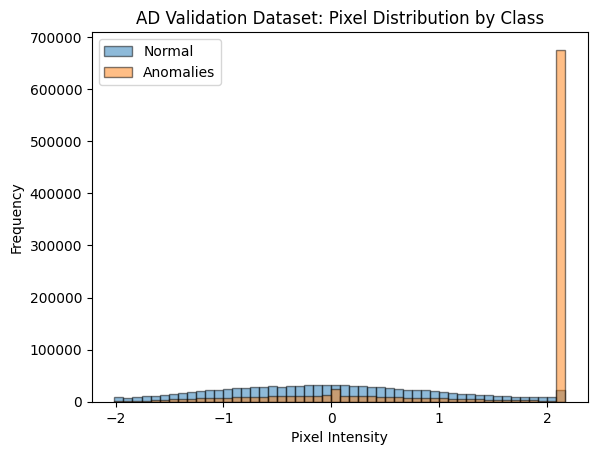

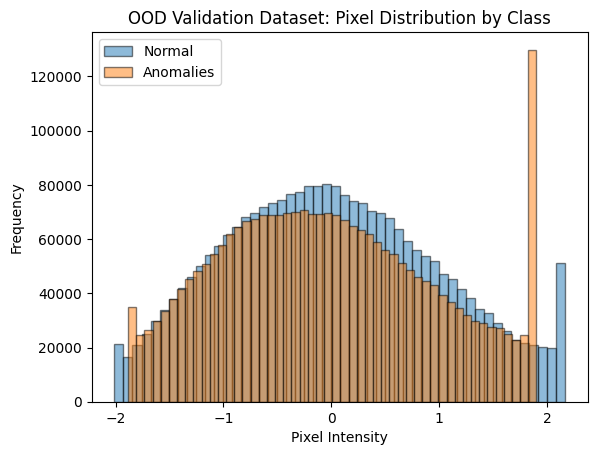

In [ ]:
def plot_class_specific_distribution(data, title="Class-Specific Pixel Distribution"):
    normal_pixels = []
    anomalous_pixels = []
    for images, label in data:
        if label == 0:
            normal_pixels.extend(images.flatten().numpy())
        else:
            anomalous_pixels.extend(images.flatten().numpy())

    plt.hist(normal_pixels, bins=50, alpha=0.5, label='Normal', edgecolor='black')
    plt.hist(anomalous_pixels, bins=50, alpha=0.5, label='Anomalies', edgecolor='black')
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.show()

plot_class_specific_distribution(ad_val_data, title="AD Validation Dataset: Pixel Distribution by Class")
plot_class_specific_distribution(ood_val_data, title="OOD Validation Dataset: Pixel Distribution by Class")

Sharp spikes observed at pixel intensity = 2 for anomalous samples in both AD and OOD validation datasets, with the spike being more pronounced in the AD dataset. Normal samples do not exhibit this spike, instead showing a relatively uniform distribution in the AD dataset and a bell-shaped distribution centered around 0 in the OOD dataset.

Anomalous samples in both datasets have higher overall pixel intensities, with their distributions shifted towards higher values compared to normal samples. This distinct pattern in pixel intensity distribution between normal and anomalous samples could aid in anomaly detection but may not represent real-world scenarios accurately.

For models relying on distance metrics, standardization (0 mean and unit variance) is crucial to ensure all features contribute equally to model decisions, especially given the right-skewed distribution of anomalous samples.

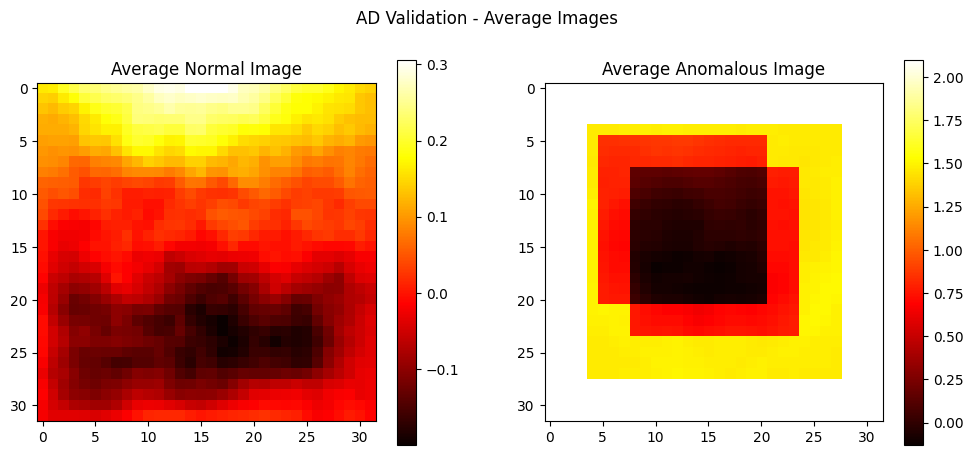

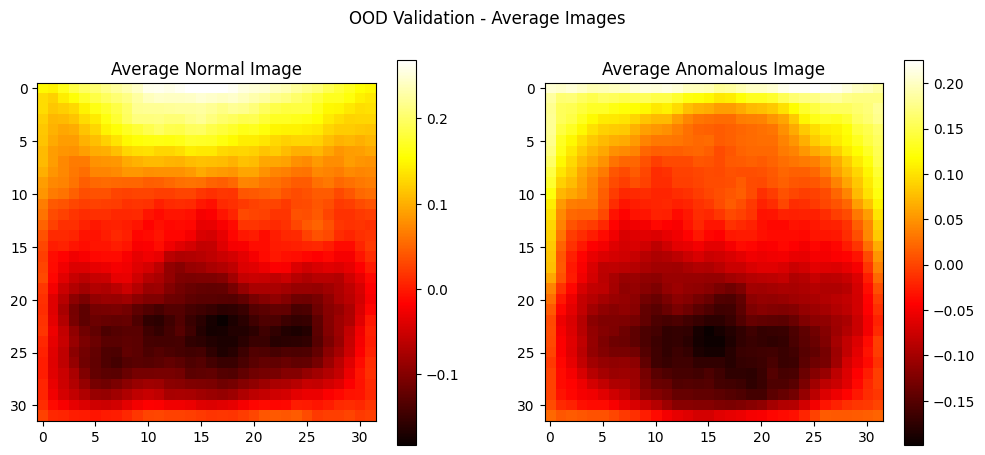

In [ ]:
def plot_average_heatmap(dataset, title):
    normal_imgs = []
    anomaly_imgs = []

    for img, label in dataset:
        if label == 0:
            normal_imgs.append(img.numpy().squeeze())
        else:
            anomaly_imgs.append(img.numpy().squeeze())

    if normal_imgs:
        normal_shape = normal_imgs[0].shape
        normal_imgs = [img for img in normal_imgs if img.shape == normal_shape]
    if anomaly_imgs:
        anomaly_shape = anomaly_imgs[0].shape
        anomaly_imgs = [img for img in anomaly_imgs if img.shape == anomaly_shape]

    avg_normal = np.mean(normal_imgs, axis=0) if normal_imgs else np.array([])
    avg_anomaly = np.mean(anomaly_imgs, axis=0) if anomaly_imgs else np.array([])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    if avg_normal.size > 0:
        im1 = ax1.imshow(avg_normal, cmap='hot')
        ax1.set_title("Average Normal Image")
        fig.colorbar(im1, ax=ax1)
    else:
        ax1.text(0.5, 0.5, "No normal images", ha='center', va='center')
        ax1.set_title("Average Normal Image (No Data)")

    if avg_anomaly.size > 0:
        im2 = ax2.imshow(avg_anomaly, cmap='hot')
        ax2.set_title("Average Anomalous Image")
        fig.colorbar(im2, ax=ax2)
    else:
        ax2.text(0.5, 0.5, "No anomalous images", ha='center', va='center')
        ax2.set_title("Average Anomalous Image (No Data)")

    plt.suptitle(title)
    plt.show()

plot_average_heatmap(ad_val_data, "AD Validation - Average Images")
plot_average_heatmap(ood_val_data, "OOD Validation - Average Images")

The x and y axes in the heatmaps represent the spatial dimensions of the images. For instance, if the original images are 28x28 pixels, the heatmap axes would range from 0 to 32 on both x and y axes. Each point in the heatmap corresponds to a pixel position in the average image. The color intensity in the heatmap represents the average pixel value at that position, with the colorbar typically ranging from dark (low intensity) to bright (high intensity) colors.

For the AD Validation dataset, the normal samples exhibit a diffuse, low-intensity pattern, aligning with the uniform distribution we observed in the pixel histogram. In stark contrast, the anomalous samples show concentrated areas of high intensity, corresponding to the pronounced spike at pixel intensity 2 in our earlier distribution plot. The OOD Validation dataset displays a more nuanced difference; normal samples show structured patterns of moderate intensity, while anomalous samples have higher overall intensity but less extreme concentrations compared to the AD dataset. This aligns with the shifted but less spike-dominated distribution we saw in the OOD pixel histograms.

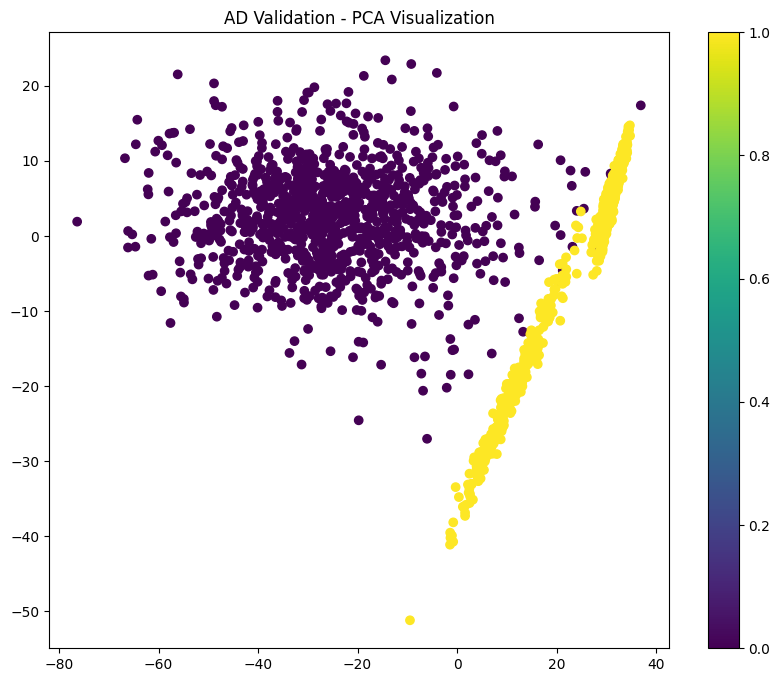

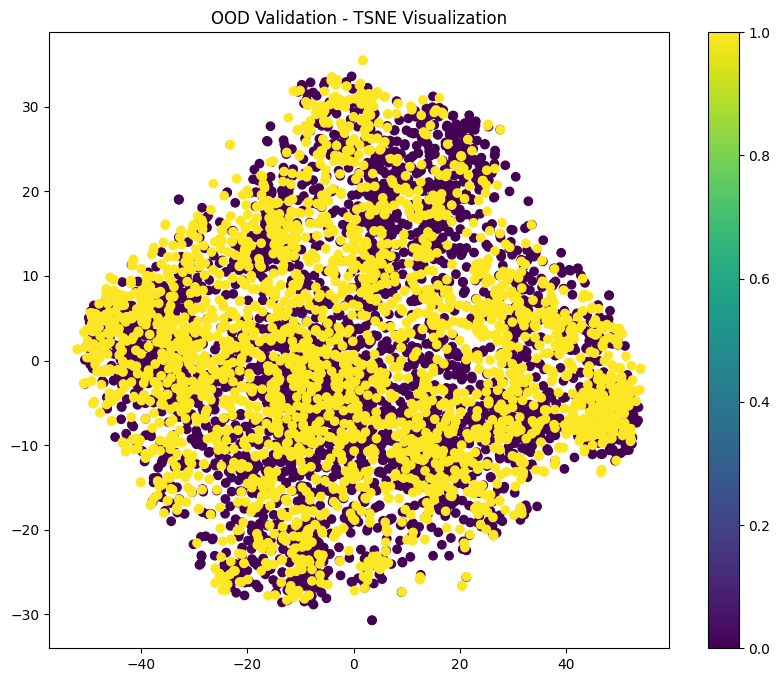

In [ ]:
def plot_dimensionality_reduction(dataset, title, method='pca'):
    X = []
    y = []
    for img, label in dataset:
        if isinstance(img, torch.Tensor):
            img = img.numpy()
        if len(img.shape) > 2:
            img = img.squeeze()
        if img.shape == (32, 32):
            X.append(img.flatten())
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    if X.size == 0:
        print(f"No valid images found for {title}")
        return

    if method == 'pca':
        reducer = PCA(n_components=2)
    else:
        reducer = TSNE(n_components=2)

    X_reduced = reducer.fit_transform(X)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f"{title} - {method.upper()} Visualization")
    plt.show()

try:
    plot_dimensionality_reduction(ad_val_data, "AD Validation", method='pca')
except Exception as e:
    print(f"Error with AD Validation: {str(e)}")

try:
    plot_dimensionality_reduction(ood_val_data, "OOD Validation", method='tsne')
except Exception as e:
    print(f"Error with OOD Validation: {str(e)}")

In the PCA plots, the x and y axes represent the first two principal components, which are the dimensions of greatest variance in the data after dimensionality reduction. These axes don't have a direct spatial interpretation like in the original images; instead, they represent abstract dimensions that capture the most significant patterns in the data.

For the AD Validation dataset, we observe distinct, well-separated clusters of normal and anomalous samples, reflecting the dramatic difference in pixel distributions. The OOD dataset's PCA plot shows less clear separation, with some overlap between classes, mirroring the more subtle differences we saw in the OOD pixel histograms. This visualization reinforces our understanding that the AD dataset presents a more artificial or extreme case of anomaly, while the OOD dataset likely represents a more realistic, challenging scenario for anomaly detection.

**Completed Preprocessing Steps**

1. **Normalization**: Data normalized to [-2, 2] range.
2. **Dimensionality Reduction**: Applied PCA and t-SNE for visualization.
3. **Data Exploration**: Analyzed pixel distributions and created visualizations.

**Remaining Preprocessing Steps (mostly for deep learning model)**

1. **Flatten, scale and extract labels**: Flatten the images, scale them to have mean 0 and std 1, and extract the labels.
2. **Data Augmentation**: Implement horizontal flipping, random cropping with padding, and random rotations.
3. **Handle Grayscale Input**: Adjust input layer for custom model to accept 1-channel grayscale images.
4. **Data Batching**: Utilize DataLoader for efficient batching and shuffling during training.

**Next Steps**

1. Implement remaining preprocessing steps.
2. Proceed with model development and training.
3. Evaluate model performance on validation sets.

## Anomaly Detection Models

### Shallow Model

One-Class SVM and Isolation Forest are unsupervised learning for anomaly detection. Therefore, the appropriate evaluation metric is AUROC and AUPRC. Accuracy is not a good metric since it is not a good measure of model performance for imbalanced dataset. It is also due to no ground truth labels are provided. In anomaly detection, a high accuracy could be achieved by simply classifying everything as normal, which doesn't indicate good performance.


In [ ]:
# Anomaly Detection Models: OCSVM and Isolation Forest
# This is an anomaly detector class that can be used to train and evaluate OCSVM and Isolation Forest models.

class AnomalyDetector:
    def __init__(self, model_type='OCSVM', param_grid=None, scaler=None):
        self.model_type = model_type
        self.param_grid = param_grid
        self.scaler = scaler
        self.best_model = None
        self.results_df = pd.DataFrame()
        self.default_performance = {}
        self.best_params = None

    def train_default_model(self, X_train):
        if self.model_type == 'OCSVM':
            self.best_model = OneClassSVM()
            self.best_model.fit(X_train)
        elif self.model_type == 'IsolationForest':
            self.best_model = IsolationForest(random_state=42)
            self.best_model.fit(X_train)
        else:
            raise ValueError("Unsupported model type.")

    def evaluate_default_model(self, X_val, y_val):
        if self.model_type == 'OCSVM':
            scores = self.best_model.decision_function(X_val)
            scores_inverted = -scores
        elif self.model_type == 'IsolationForest':
            scores = self.best_model.decision_function(X_val)
            scores_inverted = -scores
        else:
            raise ValueError("Unsupported model type.")

        auroc = roc_auc_score(y_val, scores_inverted)
        auprc = average_precision_score(y_val, scores_inverted)
        self.default_performance = {'AUROC': auroc, 'AUPRC': auprc}
        return self.default_performance

    def get_param_combinations(self):
        if not self.param_grid:
            raise ValueError("Parameter grid is not defined.")
        keys, values = zip(*self.param_grid.items())
        return [dict(zip(keys, v)) for v in itertools.product(*values)]

    def train_and_evaluate(self, X_train, X_val, y_val, cv_splits=5):
        skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
        param_combinations = self.get_param_combinations()

        results = []
        for params in param_combinations:
            print(f"Evaluating parameters: {params}")
            auroc_scores = []
            auprc_scores = []

            for train_idx, test_idx in skf.split(X_val, y_val):
                if self.model_type == 'OCSVM':
                    model = OneClassSVM(**params)
                    model.fit(X_train)
                    scores = model.decision_function(X_val[test_idx])
                    scores_inverted = -scores
                elif self.model_type == 'IsolationForest':
                    model = IsolationForest(**params, random_state=42)
                    model.fit(X_train)
                    scores = model.decision_function(X_val[test_idx])
                    scores_inverted = -scores
                else:
                    raise ValueError("Unsupported model type.")

                auroc = roc_auc_score(y_val[test_idx], scores_inverted)
                auprc = average_precision_score(y_val[test_idx], scores_inverted)
                auroc_scores.append(auroc)
                auprc_scores.append(auprc)

            result = params.copy()
            result['mean_val_auroc'] = np.mean(auroc_scores)
            result['std_val_auroc'] = np.std(auroc_scores)
            result['mean_val_auprc'] = np.mean(auprc_scores)
            result['std_val_auprc'] = np.std(auprc_scores)
            results.append(result)

        self.results_df = pd.DataFrame(results)
        return self.results_df

    def select_best_params(self, metric='mean_val_auroc'):
        if self.results_df.empty:
            raise ValueError("No results to select from.")
        best_row = self.results_df.sort_values(by=metric, ascending=False).iloc[0]
        best_params = best_row.to_dict()
        # Remove metric entries
        for key in ['mean_val_auroc', 'std_val_auroc', 'mean_val_auprc', 'std_val_auprc']:
            best_params.pop(key, None)
        self.best_params = best_params
        return best_params

    def train_final_model(self, X_train, y_train, best_params):
        if self.model_type == 'OCSVM':
            self.best_model = OneClassSVM(**best_params)
            self.best_model.fit(X_train)
        elif self.model_type == 'IsolationForest':
            self.best_model = IsolationForest(**best_params, random_state=42)
            self.best_model.fit(X_train)
        else:
            raise ValueError("Unsupported model type.")

    def evaluate_model(self, X_val, y_val):
        if self.model_type == 'OCSVM':
            scores = self.best_model.decision_function(X_val)
            scores_inverted = -scores
        elif self.model_type == 'IsolationForest':
            scores = self.best_model.decision_function(X_val)
            scores_inverted = -scores
        else:
            raise ValueError("Unsupported model type.")

        auroc = roc_auc_score(y_val, scores_inverted)
        auprc = average_precision_score(y_val, scores_inverted)
        return auroc, auprc

    def compare_performance(self, X_val, y_val):
        default_metrics = self.default_performance
        tuned_metrics = self.evaluate_model(X_val, y_val)
        improvement = {
            'AUROC': tuned_metrics[0] - default_metrics['AUROC'],
            'AUPRC': tuned_metrics[1] - default_metrics['AUPRC']
        }
        return default_metrics, tuned_metrics, improvement

Custom hyperparameter tuning for anomaly detector due to the OCSVM decision score inversion issue.

#### One-Class SVM

Some issues faced during validation is OCSVM output -1 (for anomaly) and 1 (for normal). The ground truth in validation datasets are 0 (for normal) and 1 (for anomaly). The confusion further amplified by the AUROC expecting higher decision score for instance of positive class (label 1) and lower score for instance of negative class (label 0).


OCSVM’s decision scores are higher for normal data (label 0) and lower for anomalies (label 1), which is opposite to what roc_auc_score expects.
This mismatch can lead to incorrect AUROC calculations, often resulting in an AUROC near 0 instead of near 1, despite good model performance.


Several possible steps can be done to realign such as converting the OCSVM output to match the true label, flipping the ground truth to match OCSVM output or inverting the decision score. I decided to go with decision score inversion since it feels more natural and did not change the original data.


We expect that OCSVM tuning takes O(n^3) for each parameter combo. The larger the value for nu hyper parameter, the longer it takes to complete. Isolation forest has significantly less computational demand for tuning with O(n log n) since it is basically a binary tree

In [ ]:
def flatten_ad_ood(data, expect_labels=True, flatten_images=True):
    images = []
    labels = []
    for idx, item in enumerate(data):
        if expect_labels:
            if isinstance(item, (tuple, list)) and len(item) == 2:
                image, label = item
                labels.append(label)
            else:
                raise ValueError(f"Expected tuple with 2 elements, got {item} at index {idx}")
        else:
            if isinstance(item, (tuple, list)) and len(item) == 1:
                image = item[0]
            elif isinstance(item, torch.Tensor):
                image = item
            else:
                raise ValueError(f"Expected single image tensor, got {item} at index {idx}")

        if flatten_images:
            images.append(image.numpy().flatten())
        else:
            images.append(image.numpy())
    if expect_labels:
        return np.array(images), np.array(labels)
    else:
        return np.array(images)

def preprocess_ad_ood(ad_val_data, ad_test_data, flatten_images=True):
    # Process the validation data
    X_val, y_val = flatten_ad_ood(ad_val_data, expect_labels=True, flatten_images=flatten_images)
    # Process the test data
    X_test = flatten_ad_ood(ad_test_data, expect_labels=False, flatten_images=flatten_images)

    # Separate normal and anomalous data in the validation set
    normal_indices = np.where(y_val == 0)[0]
    anomalous_indices = np.where(y_val == 1)[0]

    X_normal = X_val[normal_indices]
    y_normal = y_val[normal_indices]  
    X_anomalous = X_val[anomalous_indices]
    y_anomalous = y_val[anomalous_indices]  

    # Scale the data using only normal data
    scaler = StandardScaler()
    X_normal_scaled = scaler.fit_transform(X_normal)
    X_anomalous_scaled = scaler.transform(X_anomalous)
    X_test_scaled = scaler.transform(X_test)

    return X_normal_scaled, y_normal, X_anomalous_scaled, y_anomalous, X_test_scaled, scaler

# Preprocess data
X_normal_scaled, y_normal, X_anomalous_scaled, y_anomalous, X_test_scaled, scaler = preprocess_ad_ood(ad_val_data, ad_test_data)

In [ ]:
ocsvm_param_grid = {
    'nu': [0.01, 0.1],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto', 0.01],
}

param_combinations = list(itertools.product(
    ocsvm_param_grid['nu'],
    ocsvm_param_grid['kernel'],
    ocsvm_param_grid['gamma']
))

results = []

k_outer = 20
kf_outer = KFold(n_splits=k_outer, shuffle=True, random_state=42)

# Indices of normal data
normal_indices = np.arange(len(X_normal_scaled))

for fold, (train_index, val_index) in enumerate(kf_outer.split(normal_indices)):
    print(f"\nOuter Fold {fold + 1}/{k_outer}")

    # Split normal data into training and validation sets
    X_train = X_normal_scaled[train_index]
    X_val_normal = X_normal_scaled[val_index]
    y_val_normal = y_normal[val_index]  # All zeros

    # Combine normal validation data with all anomalous data for validation
    X_val = np.concatenate((X_val_normal, X_anomalous_scaled), axis=0)
    y_val = np.concatenate((y_val_normal, y_anomalous), axis=0)

    fold_results = []

    for params in param_combinations:
        nu, kernel, gamma = params
        print(f"Evaluating params: nu={nu}, kernel={kernel}, gamma={gamma}")

        ocsvm = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
        ocsvm.fit(X_train)

        y_scores = -ocsvm.decision_function(X_val)

        roc_auc = roc_auc_score(y_val, y_scores)

        # Determine optimal threshold using ROC curve
        fpr, tpr, thresholds = roc_curve(y_val, y_scores)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        # Predict labels based on threshold
        y_pred = (y_scores >= optimal_threshold).astype(int)

        f1 = f1_score(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        auprc = average_precision_score(y_val, y_scores)

        fold_results.append({
            'nu': nu,
            'kernel': kernel,
            'gamma': gamma,
            'roc_auc': roc_auc,
            'f1_score': f1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'auprc': auprc
        })

    best_params = max(fold_results, key=lambda x: x['roc_auc'])
    print(f"Best params for fold {fold + 1}: {best_params}")

    results.append(best_params)




Outer Fold 1/20
Evaluating params: nu=0.01, kernel=rbf, gamma=scale
Evaluating params: nu=0.01, kernel=rbf, gamma=auto
Evaluating params: nu=0.01, kernel=rbf, gamma=0.01
Evaluating params: nu=0.1, kernel=rbf, gamma=scale
Evaluating params: nu=0.1, kernel=rbf, gamma=auto
Evaluating params: nu=0.1, kernel=rbf, gamma=0.01
Best params for fold 1: {'nu': 0.1, 'kernel': 'rbf', 'gamma': 'auto', 'roc_auc': 0.85596, 'f1_score': 0.9549456240290005, 'accuracy': 0.9171428571428571, 'precision': 0.9903329752953813, 'recall': 0.922, 'auprc': 0.9828465239609365}

Outer Fold 2/20
Evaluating params: nu=0.01, kernel=rbf, gamma=scale
Evaluating params: nu=0.01, kernel=rbf, gamma=auto
Evaluating params: nu=0.01, kernel=rbf, gamma=0.01
Evaluating params: nu=0.1, kernel=rbf, gamma=scale
Evaluating params: nu=0.1, kernel=rbf, gamma=auto
Evaluating params: nu=0.1, kernel=rbf, gamma=0.01
Best params for fold 2: {'nu': 0.1, 'kernel': 'rbf', 'gamma': 'auto', 'roc_auc': 0.8916, 'f1_score': 0.9737373737373738, 'a

In [ ]:
best_params_per_fold = []
for fold_best in results:
    params_only = {key: fold_best[key] for key in ['nu', 'kernel', 'gamma']}
    best_params_per_fold.append(params_only)

# Count frequency of each hyperparameter combination
from collections import Counter
hyperparam_tuples = [tuple(sorted(params.items())) for params in best_params_per_fold]
hyperparam_counts = Counter(hyperparam_tuples)
most_common_hyperparams_tuple = hyperparam_counts.most_common(1)[0][0]
best_hyperparams = dict(most_common_hyperparams_tuple)

print(f"Most common hyperparameters across folds: {best_hyperparams}")

Most common hyperparameters across folds: {'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.1}


In [ ]:
# Train the final model using the best hyperparameters
final_ocsvm_0_01 = OneClassSVM(
    nu=best_hyperparams['nu'],
    kernel=best_hyperparams['kernel'],
    gamma=0.01
)
final_ocsvm_0_01.fit(X_normal_scaled)

# Determine the optimal threshold using combined validation data
X_val_full = np.concatenate((X_normal_scaled, X_anomalous_scaled), axis=0)
y_val_full = np.concatenate((y_normal, y_anomalous), axis=0)

y_val_scores_0_01 = -final_ocsvm_0_01.decision_function(X_val_full)

fpr, tpr, thresholds = roc_curve(y_val_full, y_val_scores_0_01)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_0_01 = thresholds[optimal_idx]

print(f"Optimal threshold for gamma=0.01: {optimal_threshold_0_01}")

final_ocsvm_auto = OneClassSVM(
    nu=best_hyperparams['nu'],
    kernel=best_hyperparams['kernel'],
    gamma='auto'
)
final_ocsvm_auto.fit(X_normal_scaled)

# Determine the optimal threshold using combined validation data
X_val_full = np.concatenate((X_normal_scaled, X_anomalous_scaled), axis=0)
y_val_full = np.concatenate((y_normal, y_anomalous), axis=0)


y_val_scores_auto = -final_ocsvm_auto.decision_function(X_val_full)

# Find the optimal threshold based on F1-Score
thresholds = np.linspace(np.min(y_val_scores_auto), np.max(y_val_scores_auto), 100)
f1_scores = [f1_score(y_val_full, (y_val_scores_auto >= thresh).astype(int)) for thresh in thresholds]
max_f1 = max(f1_scores)
optimal_idx = f1_scores.index(max_f1)
optimal_threshold_auto = thresholds[optimal_idx]

print(f"\nOptimal Threshold based on F1-Score for gamma='auto': {optimal_threshold_auto:.4f}\n")

# Evaluate the final model on the validation set
y_val_pred_0_01 = (y_val_scores_0_01 >= optimal_threshold_0_01).astype(int)
y_val_pred_auto = (y_val_scores_auto >= optimal_threshold_auto).astype(int)

final_accuracy_0_01 = accuracy_score(y_val_full, y_val_pred_0_01)
final_precision_0_01 = precision_score(y_val_full, y_val_pred_0_01)
final_recall_0_01 = recall_score(y_val_full, y_val_pred_0_01)
final_f1_0_01 = f1_score(y_val_full, y_val_pred_0_01)
final_roc_auc_0_01 = roc_auc_score(y_val_full, y_val_scores_0_01)
final_auprc_0_01 = average_precision_score(y_val_full, y_val_scores_0_01)

final_accuracy_auto = accuracy_score(y_val_full, y_val_pred_auto)
final_precision_auto = precision_score(y_val_full, y_val_pred_auto)
final_recall_auto = recall_score(y_val_full, y_val_pred_auto)
final_f1_auto = f1_score(y_val_full, y_val_pred_auto)
final_roc_auc_auto = roc_auc_score(y_val_full, y_val_scores_auto)
final_auprc_auto = average_precision_score(y_val_full, y_val_scores_auto)

print(f"Final Model Performance on Validation Set (gamma=0.01):")
print(f"Accuracy: {final_accuracy_0_01:.4f}")
print(f"Precision: {final_precision_0_01:.4f}")
print(f"Recall: {final_recall_0_01:.4f}")
print(f"F1-Score: {final_f1_0_01:.4f}")
print(f"ROC AUC: {final_roc_auc_0_01:.4f}")
print(f"AUPRC: {final_auprc_0_01:.4f}\n")

print(f"Final Model Performance on Validation Set (gamma='auto'):")
print(f"Accuracy: {final_accuracy_auto:.4f}")
print(f"Precision: {final_precision_auto:.4f}")
print(f"Recall: {final_recall_auto:.4f}")
print(f"F1-Score: {final_f1_auto:.4f}")
print(f"ROC AUC: {final_roc_auc_auto:.4f}")
print(f"AUPRC: {final_auprc_auto:.4f}")


Optimal threshold for gamma=0.01: 0.10211482203145038

Optimal Threshold based on F1-Score for gamma='auto': -0.9101

Final Model Performance on Validation Set (gamma=0.01):
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC AUC: 1.0000
AUPRC: 1.0000

Final Model Performance on Validation Set (gamma='auto'):
Accuracy: 0.8495
Precision: 0.7905
Recall: 0.9510
F1-Score: 0.8634
ROC AUC: 0.9173
AUPRC: 0.8892


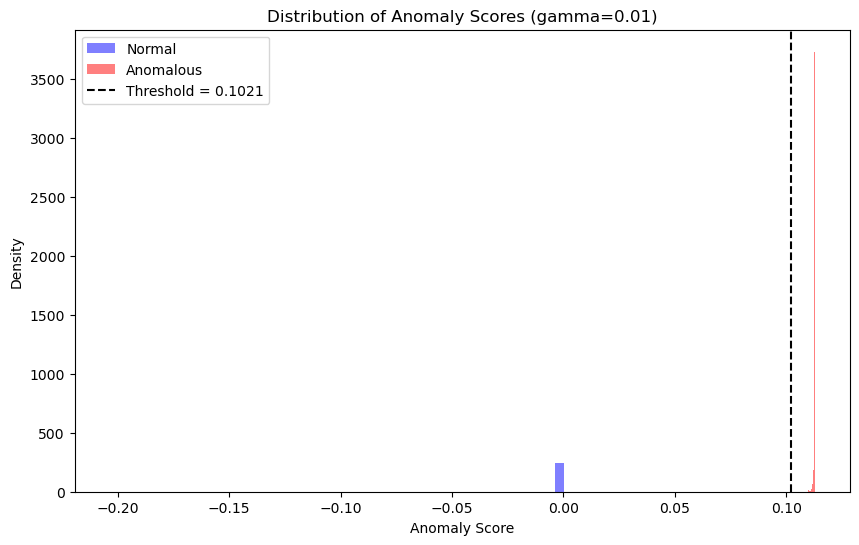

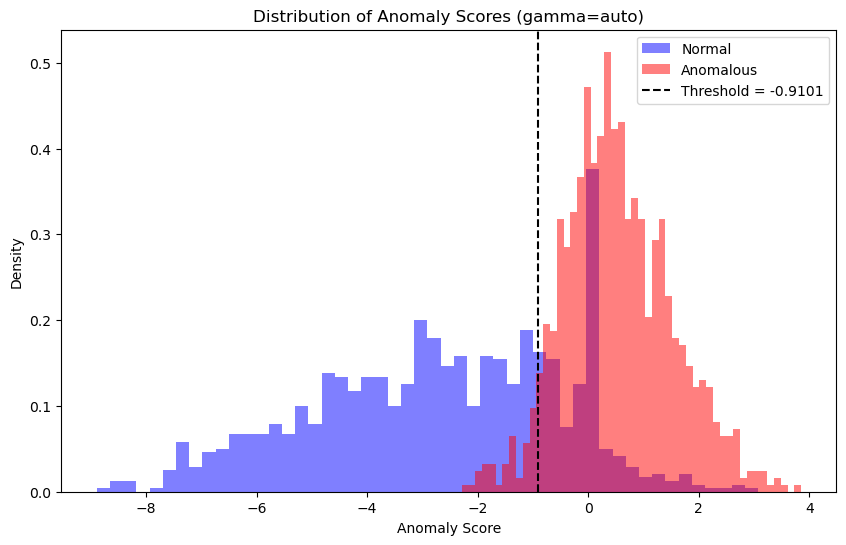

In [ ]:
# Anomaly scores for normal validation samples
y_scores_normal_0_01 = -final_ocsvm_0_01.decision_function(X_normal_scaled)
y_scores_normal_auto = -final_ocsvm_auto.decision_function(X_normal_scaled)

# Anomaly scores for anomalous validation samples
y_scores_anomalous_0_01 = -final_ocsvm_0_01.decision_function(X_anomalous_scaled)
y_scores_anomalous_auto = -final_ocsvm_auto.decision_function(X_anomalous_scaled)

plt.figure(figsize=(10, 6))
plt.hist(y_scores_normal_0_01, bins=50, alpha=0.5, label='Normal', color='blue', density=True)
plt.hist(y_scores_anomalous_0_01, bins=50, alpha=0.5, label='Anomalous', color='red', density=True)
plt.axvline(x=optimal_threshold_0_01, color='k', linestyle='--', label=f'Threshold = {optimal_threshold_0_01:.4f}')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores (gamma=0.01)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(y_scores_normal_auto, bins=50, alpha=0.5, label='Normal', color='blue', density=True)
plt.hist(y_scores_anomalous_auto, bins=50, alpha=0.5, label='Anomalous', color='red', density=True)
plt.axvline(x=optimal_threshold_auto, color='k', linestyle='--', label=f'Threshold = {optimal_threshold_auto:.4f}')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores (gamma=auto)')
plt.legend()
plt.show()

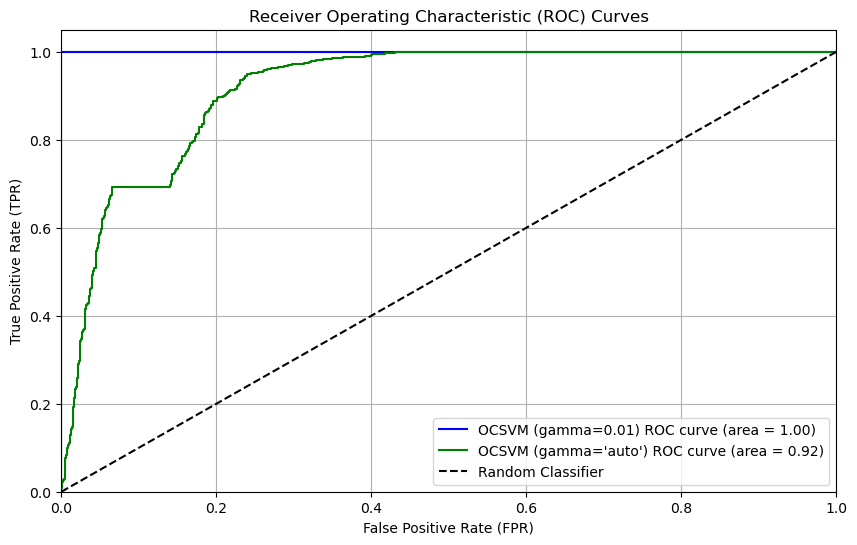

In [ ]:
# Compute ROC curve and ROC area for gamma=0.01
fpr_0_01, tpr_0_01, thresholds_0_01 = roc_curve(y_val_full, y_val_scores_0_01)
roc_auc_0_01 = auc(fpr_0_01, tpr_0_01)

# Compute ROC curve and ROC area for gamma='auto'
fpr_auto, tpr_auto, thresholds_auto = roc_curve(y_val_full, y_val_scores_auto)
roc_auc_auto = auc(fpr_auto, tpr_auto)

plt.figure(figsize=(10, 6))
plt.plot(fpr_0_01, tpr_0_01, label=f'OCSVM (gamma=0.01) ROC curve (area = {roc_auc_0_01:.2f})', color='blue')
plt.plot(fpr_auto, tpr_auto, label=f'OCSVM (gamma=\'auto\') ROC curve (area = {roc_auc_auto:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

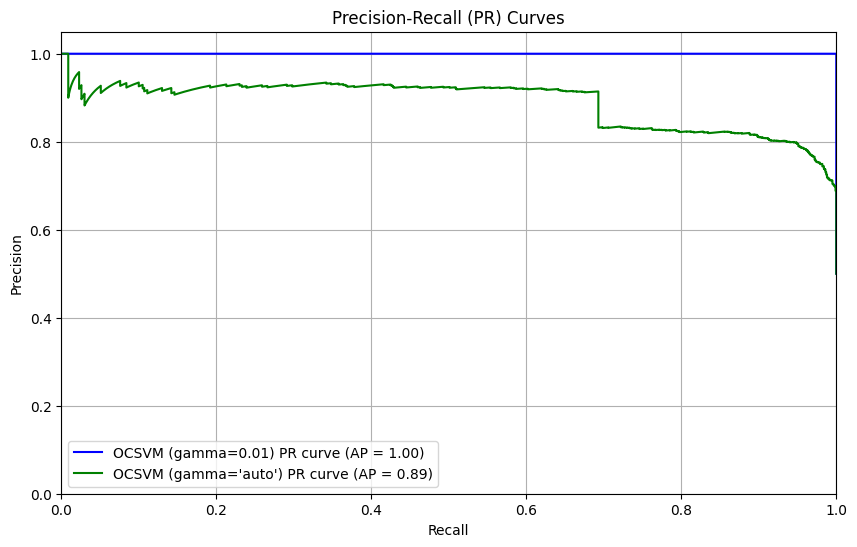

In [ ]:
# Compute Precision-Recall curve and average precision for gamma=0.01
precision_0_01, recall_0_01, thresholds_pr_0_01 = precision_recall_curve(y_val_full, y_val_scores_0_01)
average_precision_0_01 = average_precision_score(y_val_full, y_val_scores_0_01)

# Compute Precision-Recall curve and average precision for gamma='auto'
precision_auto, recall_auto, thresholds_pr_auto = precision_recall_curve(y_val_full, y_val_scores_auto)
average_precision_auto = average_precision_score(y_val_full, y_val_scores_auto)

plt.figure(figsize=(10, 6))
plt.plot(recall_0_01, precision_0_01, label=f'OCSVM (gamma=0.01) PR curve (AP = {average_precision_0_01:.2f})', color='blue')
plt.plot(recall_auto, precision_auto, label=f'OCSVM (gamma=\'auto\') PR curve (AP = {average_precision_auto:.2f})', color='green')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curves')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Optimal Threshold for gamma='auto': -0.9101
Maximum F1-Score for gamma='auto': 0.8634
Precision at optimal threshold: 0.7905
Recall at optimal threshold: 0.9510
AUROC: 0.9173
AUPRC: 0.8890


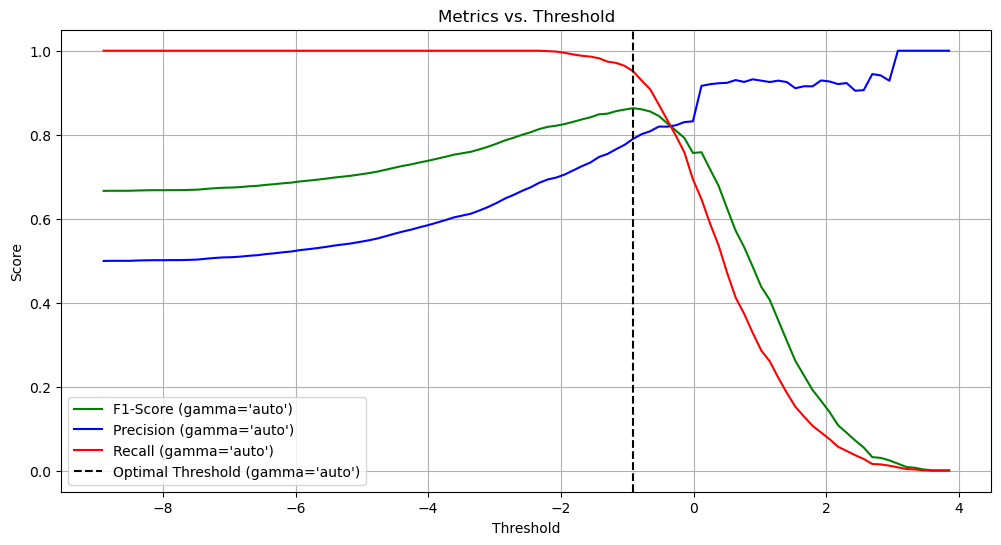

In [ ]:
# Define thresholds from min to max of anomaly scores
thresholds_auto = np.linspace(np.min(y_val_scores_auto), np.max(y_val_scores_auto), 100)

# Function to compute metrics for a range of thresholds
def compute_metrics(y_true, y_scores, thresholds):
    f1_scores, precisions, recalls = [], [], []
    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        f1_scores.append(f1_score(y_true, y_pred))
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
    return f1_scores, precisions, recalls

# Compute metrics for gamma='auto'
f1_scores_auto, precisions_auto, recalls_auto = compute_metrics(y_val_full, y_val_scores_auto, thresholds_auto)

# Find optimal threshold for gamma='auto'
max_f1_auto = max(f1_scores_auto)
optimal_idx_auto = f1_scores_auto.index(max_f1_auto)
optimal_threshold_auto = thresholds_auto[optimal_idx_auto]

fpr, tpr, _ = roc_curve(y_val_full, y_val_scores_auto)
auroc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_val_full, y_val_scores_auto)
auprc = auc(recall, precision)

print(f"Optimal Threshold for gamma='auto': {optimal_threshold_auto:.4f}")
print(f"Maximum F1-Score for gamma='auto': {max_f1_auto:.4f}")
print(f"Precision at optimal threshold: {precisions_auto[optimal_idx_auto]:.4f}")
print(f"Recall at optimal threshold: {recalls_auto[optimal_idx_auto]:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"AUPRC: {auprc:.4f}")

plt.figure(figsize=(12, 6))

# Plot for gamma='auto'
plt.plot(thresholds_auto, f1_scores_auto, label='F1-Score (gamma=\'auto\')', color='green')
plt.plot(thresholds_auto, precisions_auto, label='Precision (gamma=\'auto\')', color='blue')
plt.plot(thresholds_auto, recalls_auto, label='Recall (gamma=\'auto\')', color='red')
plt.axvline(x=optimal_threshold_auto, color='black', linestyle='--', label=f'Optimal Threshold (gamma=\'auto\')')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

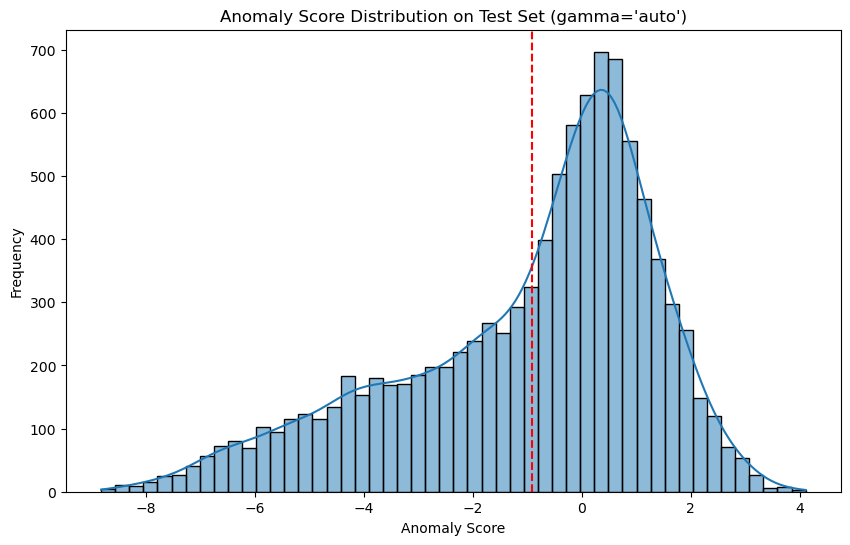

Gamma='auto': Detected 6012 anomalies out of 10000 samples.


In [ ]:
final_ocsvm_auto = OneClassSVM(
    nu=best_hyperparams['nu'],
    kernel=best_hyperparams['kernel'],
    gamma='auto'
)
final_ocsvm_auto.fit(X_normal_scaled)

# For gamma='auto'
y_test_scores_auto = -final_ocsvm_auto.decision_function(X_test_scaled)

def plot_test_scores(y_scores, gamma_value, optimal_threshold):
    plt.figure(figsize=(10, 6))
    sns.histplot(y_scores, bins=50, kde=True)
    plt.axvline(optimal_threshold_auto, color='red', linestyle='--', label='Threshold')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.title(f'Anomaly Score Distribution on Test Set (gamma=\'auto\')')
    plt.show()

# For gamma='auto'
plot_test_scores(y_test_scores_auto, 'auto', optimal_threshold_auto)

y_test_pred_auto = (y_test_scores_auto >= optimal_threshold_auto).astype(int)

num_anomalies_auto = np.sum(y_test_pred_auto)
total_samples = len(y_test_pred_auto)

print(f"Gamma='auto': Detected {num_anomalies_auto} anomalies out of {total_samples} samples.")


#### Isolation Forest

Isolation Forest is an unsupervised learning model for anomaly detection. It is a tree-based model that isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the feature. The observations are then partitioned into two groups, and the process is repeated for each feature. The observations are then classified as anomalies if they are isolated into a single group.

In [50]:
iso_param_grid = {
    'n_estimators': [100, 200],
    'contamination': [0.01, 0.1],
    'max_samples': ['auto', 100],
}

param_combinations = list(ParameterGrid(iso_param_grid))

results = []

k_outer = 20
kf_outer = KFold(n_splits=k_outer, shuffle=True, random_state=42)

# Indices of normal data
normal_indices = np.arange(len(X_normal_scaled))

for fold, (train_index, val_index) in enumerate(kf_outer.split(normal_indices)):
    print(f"\nOuter Fold {fold + 1}/{k_outer}")

    # Split normal data into training and validation sets
    X_train = X_normal_scaled[train_index]
    X_val_normal = X_normal_scaled[val_index]
    y_val_normal = y_normal[val_index]  # All zeros

    # Combine normal validation data with all anomalous data for validation
    X_val = np.concatenate((X_val_normal, X_anomalous_scaled), axis=0)
    y_val = np.concatenate((y_val_normal, y_anomalous), axis=0)

    fold_results = []

    for params in param_combinations:
        print(f"Evaluating params: {params}")

        iso_forest = IsolationForest(**params, random_state=42)
        iso_forest.fit(X_train)

        y_scores = -iso_forest.decision_function(X_val)

        roc_auc = roc_auc_score(y_val, y_scores)

        fpr, tpr, thresholds = roc_curve(y_val, y_scores)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        y_pred = (y_scores >= optimal_threshold).astype(int)

        f1 = f1_score(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        auprc = average_precision_score(y_val, y_scores)

        fold_results.append({
            **params,
            'roc_auc': roc_auc,
            'f1_score': f1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'auprc': auprc
        })

    best_params = max(fold_results, key=lambda x: x['roc_auc'])
    print(f"Best params for fold {fold + 1}: {best_params}")

    results.append(best_params)



Outer Fold 1/20
Evaluating params: {'contamination': 0.01, 'max_samples': 'auto', 'n_estimators': 100}
Evaluating params: {'contamination': 0.01, 'max_samples': 'auto', 'n_estimators': 200}
Evaluating params: {'contamination': 0.01, 'max_samples': 100, 'n_estimators': 100}
Evaluating params: {'contamination': 0.01, 'max_samples': 100, 'n_estimators': 200}
Evaluating params: {'contamination': 0.1, 'max_samples': 'auto', 'n_estimators': 100}
Evaluating params: {'contamination': 0.1, 'max_samples': 'auto', 'n_estimators': 200}
Evaluating params: {'contamination': 0.1, 'max_samples': 100, 'n_estimators': 100}
Evaluating params: {'contamination': 0.1, 'max_samples': 100, 'n_estimators': 200}
Best params for fold 1: {'contamination': 0.01, 'max_samples': 100, 'n_estimators': 200, 'roc_auc': 0.95778, 'f1_score': 0.9965122072745392, 'accuracy': 0.9933333333333333, 'precision': 0.9930486593843099, 'recall': 1.0, 'auprc': 0.9961158229177169}

Outer Fold 2/20
Evaluating params: {'contamination':

In [51]:
best_params_per_fold = []
for fold_best in results:
    params_only = {key: fold_best[key] for key in ['n_estimators', 'contamination', 'max_samples']}
    best_params_per_fold.append(params_only)

# Count frequency of each hyperparameter combination
from collections import Counter
hyperparam_tuples = [tuple(sorted(params.items())) for params in best_params_per_fold]
hyperparam_counts = Counter(hyperparam_tuples)
most_common_hyperparams_tuple = hyperparam_counts.most_common(1)[0][0]
best_hyperparams = dict(most_common_hyperparams_tuple)

print(f"Most common hyperparameters across folds: {best_hyperparams}")

Most common hyperparameters across folds: {'contamination': 0.01, 'max_samples': 100, 'n_estimators': 200}


In [52]:
# rain the final model using the best hyperparameters
def calculate_metrics(y_true, y_pred, y_scores):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_scores),
        'auprc': average_precision_score(y_true, y_scores)
    }

def print_metrics(metrics):
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

final_isoforest_100 = IsolationForest(
    n_estimators=best_hyperparams['n_estimators'],
    contamination=best_hyperparams['contamination'],
    max_samples=best_hyperparams['max_samples'],
    n_jobs=-1,
    random_state=42
)
final_isoforest_100.fit(X_normal_scaled)

final_isoforest_200 = IsolationForest(
    n_estimators=200,  # Increased number of trees
    contamination=best_hyperparams['contamination'],
    max_samples=best_hyperparams['max_samples'],
    n_jobs=-1,
    random_state=42
)
final_isoforest_200.fit(X_normal_scaled)

# Determine the optimal threshold using combined validation data
X_val_full = np.concatenate((X_normal_scaled, X_anomalous_scaled), axis=0)
y_val_full = np.concatenate((y_normal, y_anomalous), axis=0)

y_val_scores_100 = -final_isoforest_100.decision_function(X_val_full)
y_val_scores_200 = -final_isoforest_200.decision_function(X_val_full)

thresholds = np.linspace(np.min(y_val_scores_100), np.max(y_val_scores_100), 100)
f1_scores_100 = [f1_score(y_val_full, (y_val_scores_100 >= thresh).astype(int)) for thresh in thresholds]
f1_scores_200 = [f1_score(y_val_full, (y_val_scores_200 >= thresh).astype(int)) for thresh in thresholds]

optimal_threshold_100 = thresholds[np.argmax(f1_scores_100)]
optimal_threshold_200 = thresholds[np.argmax(f1_scores_200)]

print(f"Optimal threshold for n_estimators=100: {optimal_threshold_100:.4f}")
print(f"Optimal threshold for n_estimators=200: {optimal_threshold_200:.4f}")

# valuate the final models on the validation set
y_val_pred_100 = (y_val_scores_100 >= optimal_threshold_100).astype(int)
y_val_pred_200 = (y_val_scores_200 >= optimal_threshold_200).astype(int)

metrics_100 = calculate_metrics(y_val_full, y_val_pred_100, y_val_scores_100)
metrics_200 = calculate_metrics(y_val_full, y_val_pred_200, y_val_scores_200)

print("\nFinal Model Performance on Validation Set (n_estimators=100):")
print_metrics(metrics_100)

print("\nFinal Model Performance on Validation Set (n_estimators=200):")
print_metrics(metrics_200)


Optimal threshold for n_estimators=100: -0.0728
Optimal threshold for n_estimators=200: -0.0728

Final Model Performance on Validation Set (n_estimators=100):
Accuracy: 0.9550
Precision: 0.9190
Recall: 0.9980
F1_score: 0.9569
Roc_auc: 0.9813
Auprc: 0.9607

Final Model Performance on Validation Set (n_estimators=200):
Accuracy: 0.9550
Precision: 0.9190
Recall: 0.9980
F1_score: 0.9569
Roc_auc: 0.9813
Auprc: 0.9607


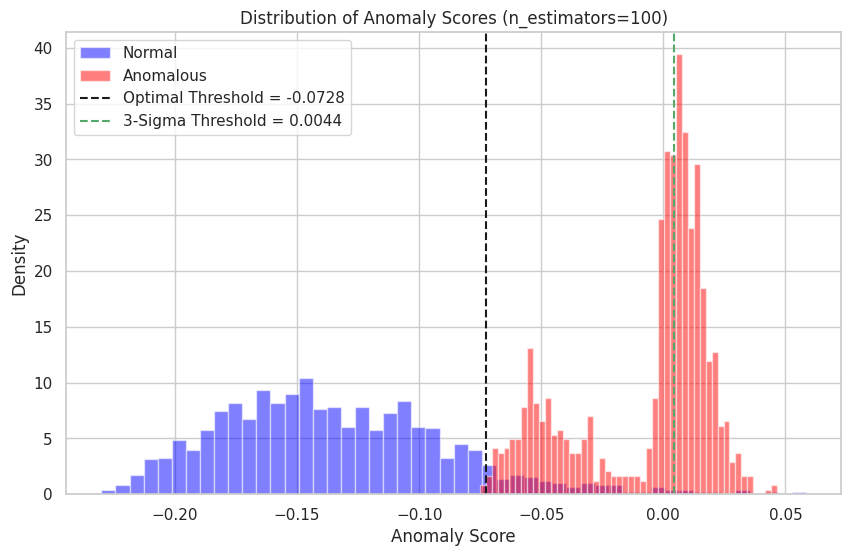


Performance with Optimal Threshold:
Accuracy: 0.9550
Precision: 0.9190
Recall: 0.9980
F1_score: 0.9569
Roc_auc: 0.9813
Auprc: 0.9607

Performance with 3-Sigma Threshold:
Accuracy: 0.7410
Precision: 0.9820
Recall: 0.4910
F1_score: 0.6547
Roc_auc: 0.9813
Auprc: 0.9607


In [53]:
# Anomaly scores for normal validation samples
y_scores_normal_100 = -final_isoforest_100.decision_function(X_normal_scaled)

# Anomaly scores for anomalous validation samples
y_scores_anomalous_100 = -final_isoforest_100.decision_function(X_anomalous_scaled)

# Calculate 3-sigma threshold
mean_normal = np.mean(y_scores_normal_100)
std_normal = np.std(y_scores_normal_100)
threshold_3sigma = mean_normal + 3 * std_normal

plt.figure(figsize=(10, 6))
plt.hist(y_scores_normal_100, bins=50, alpha=0.5, label='Normal', color='blue', density=True)
plt.hist(y_scores_anomalous_100, bins=50, alpha=0.5, label='Anomalous', color='red', density=True)
plt.axvline(x=optimal_threshold_100, color='k', linestyle='--', label=f'Optimal Threshold = {optimal_threshold_100:.4f}')
plt.axvline(x=threshold_3sigma, color='g', linestyle='--', label=f'3-Sigma Threshold = {threshold_3sigma:.4f}')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of Anomaly Scores (n_estimators=100)')
plt.legend()
plt.show()

# Compare performance of optimal threshold vs 3-sigma threshold
y_pred_optimal = (y_val_scores_100 >= optimal_threshold_100).astype(int)
y_pred_3sigma = (y_val_scores_100 >= threshold_3sigma).astype(int)

metrics_optimal = calculate_metrics(y_val_full, y_pred_optimal, y_val_scores_100)
metrics_3sigma = calculate_metrics(y_val_full, y_pred_3sigma, y_val_scores_100)

print("\nPerformance with Optimal Threshold:")
print_metrics(metrics_optimal)

print("\nPerformance with 3-Sigma Threshold:")
print_metrics(metrics_3sigma)

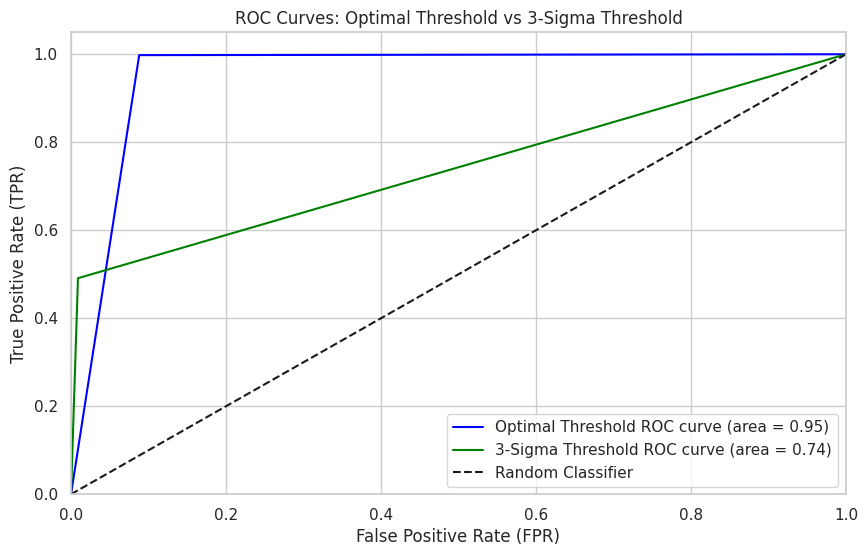


Performance with Optimal Threshold:
Accuracy: 0.9550
Precision: 0.9190
Recall: 0.9980
F1_score: 0.9569
Roc_auc: 0.9813
Auprc: 0.9607

Performance with 3-Sigma Threshold:
Accuracy: 0.7410
Precision: 0.9820
Recall: 0.4910
F1_score: 0.6547
Roc_auc: 0.9813
Auprc: 0.9607


In [54]:
# Compute ROC curve and ROC area for optimal threshold
fpr_optimal, tpr_optimal, _ = roc_curve(y_val_full, y_pred_optimal)
roc_auc_optimal = auc(fpr_optimal, tpr_optimal)

# Compute ROC curve and ROC area for 3-sigma threshold
fpr_3sigma, tpr_3sigma, _ = roc_curve(y_val_full, y_pred_3sigma)
roc_auc_3sigma = auc(fpr_3sigma, tpr_3sigma)

plt.figure(figsize=(10, 6))
plt.plot(fpr_optimal, tpr_optimal, label=f'Optimal Threshold ROC curve (area = {roc_auc_optimal:.2f})', color='blue')
plt.plot(fpr_3sigma, tpr_3sigma, label=f'3-Sigma Threshold ROC curve (area = {roc_auc_3sigma:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves: Optimal Threshold vs 3-Sigma Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\nPerformance with Optimal Threshold:")
print_metrics(metrics_optimal)

print("\nPerformance with 3-Sigma Threshold:")
print_metrics(metrics_3sigma)

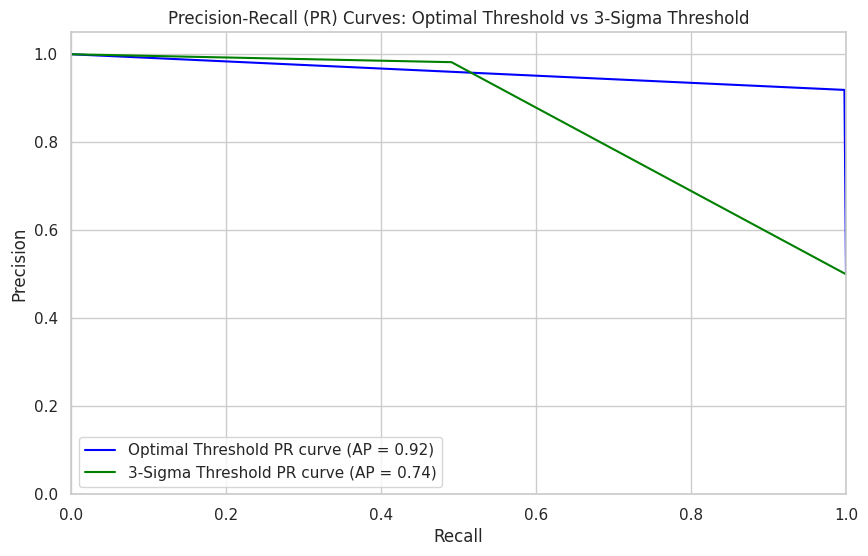


Average Precision with Optimal Threshold: 0.9181
Average Precision with 3-Sigma Threshold: 0.7367


In [55]:
# Compute Precision-Recall curve and average precision for optimal threshold
precision_optimal, recall_optimal, _ = precision_recall_curve(y_val_full, y_pred_optimal)
average_precision_optimal = average_precision_score(y_val_full, y_pred_optimal)

# Compute Precision-Recall curve and average precision for 3-sigma threshold
precision_3sigma, recall_3sigma, _ = precision_recall_curve(y_val_full, y_pred_3sigma)
average_precision_3sigma = average_precision_score(y_val_full, y_pred_3sigma)

plt.figure(figsize=(10, 6))
plt.plot(recall_optimal, precision_optimal, label=f'Optimal Threshold PR curve (AP = {average_precision_optimal:.2f})', color='blue')
plt.plot(recall_3sigma, precision_3sigma, label=f'3-Sigma Threshold PR curve (AP = {average_precision_3sigma:.2f})', color='green')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curves: Optimal Threshold vs 3-Sigma Threshold')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print(f"\nAverage Precision with Optimal Threshold: {average_precision_optimal:.4f}")
print(f"Average Precision with 3-Sigma Threshold: {average_precision_3sigma:.4f}")

Optimal Threshold for n_estimators=100: -0.0728
Three-Sigma Threshold: 0.1533
Maximum F1-Score for n_estimators=100: 0.9569
AUROC: 0.9813
AUPRC: 0.9601
Precision at optimal threshold: 0.9190
Recall at optimal threshold: 0.9980


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79bd5179e830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1408, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'


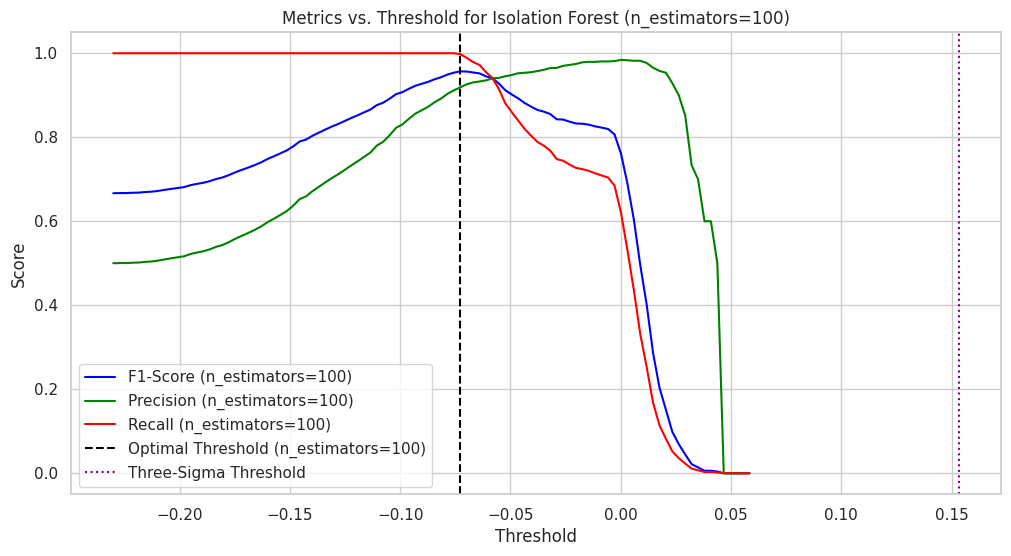

In [56]:
# Define thresholds from min to max of anomaly scores
thresholds_100 = np.linspace(np.min(y_val_scores_100), np.max(y_val_scores_100), 100)

# Function to compute F1-score, precision, and recall for a range of thresholds
def compute_metrics(y_true, y_scores, thresholds):
    f1_scores, precisions, recalls = [], [], []
    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
    return f1_scores, precisions, recalls

# Compute metrics for n_estimators=100
f1_scores_100, precisions_100, recalls_100 = compute_metrics(y_val_full, y_val_scores_100, thresholds_100)

# For n_estimators=100
max_f1_100 = max(f1_scores_100)
optimal_idx_100 = f1_scores_100.index(max_f1_100)
optimal_threshold_100 = thresholds_100[optimal_idx_100]

# Compute three-sigma threshold
mean_score = np.mean(y_val_scores_100)
std_score = np.std(y_val_scores_100)
three_sigma_threshold = mean_score + 3 * std_score

# Compute AUROC and AUPRC
fpr, tpr, _ = roc_curve(y_val_full, y_val_scores_100)
auroc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_val_full, y_val_scores_100)
auprc = auc(recall, precision)

print(f"Optimal Threshold for n_estimators=100: {optimal_threshold_100:.4f}")
print(f"Three-Sigma Threshold: {three_sigma_threshold:.4f}")
print(f"Maximum F1-Score for n_estimators=100: {max_f1_100:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"AUPRC: {auprc:.4f}")
print(f"Precision at optimal threshold: {precisions_100[optimal_idx_100]:.4f}")
print(f"Recall at optimal threshold: {recalls_100[optimal_idx_100]:.4f}")

plt.figure(figsize=(12, 6))

# Plot for n_estimators=100
plt.plot(thresholds_100, f1_scores_100, label='F1-Score (n_estimators=100)', color='blue')
plt.plot(thresholds_100, precisions_100, label='Precision (n_estimators=100)', color='green')
plt.plot(thresholds_100, recalls_100, label='Recall (n_estimators=100)', color='red')
plt.axvline(x=optimal_threshold_100, color='black', linestyle='--', label=f'Optimal Threshold (n_estimators=100)')
plt.axvline(x=three_sigma_threshold, color='purple', linestyle=':', label=f'Three-Sigma Threshold')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Threshold for Isolation Forest (n_estimators=100)')
plt.legend()
plt.grid(True)
plt.show()

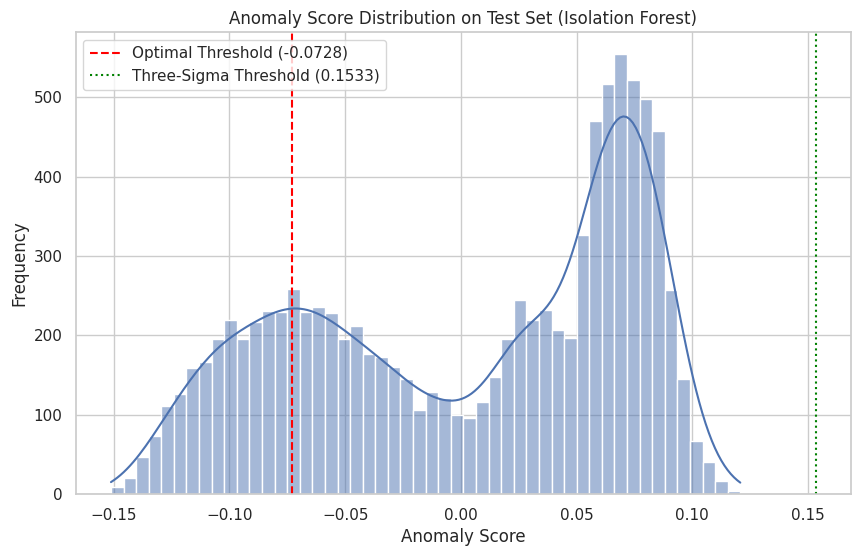

Isolation Forest (Optimal Threshold): Detected 7891 anomalies out of 10000 samples.
Isolation Forest (Three-Sigma Threshold): Detected 0 anomalies out of 10000 samples.


In [57]:
# Train the final Isolation Forest model with the best parameters
final_iforest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
final_iforest.fit(X_normal_scaled)

# Get anomaly scores for the test set
y_test_scores = -final_iforest.decision_function(X_test_scaled)

def plot_test_scores(y_scores, optimal_threshold, three_sigma_threshold):
    plt.figure(figsize=(10, 6))
    sns.histplot(y_scores, bins=50, kde=True)
    plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.4f})')
    plt.axvline(three_sigma_threshold, color='green', linestyle=':', label=f'Three-Sigma Threshold ({three_sigma_threshold:.4f})')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.title('Anomaly Score Distribution on Test Set (Isolation Forest)')
    plt.legend()
    plt.show()

# Plot the anomaly score distribution
plot_test_scores(y_test_scores, optimal_threshold_100, three_sigma_threshold)

# Make predictions on the test set using optimal threshold
y_test_pred_optimal = (y_test_scores >= optimal_threshold_100).astype(int)

# Make predictions on the test set using three-sigma threshold
y_test_pred_three_sigma = (y_test_scores >= three_sigma_threshold).astype(int)

num_anomalies_optimal = np.sum(y_test_pred_optimal)
num_anomalies_three_sigma = np.sum(y_test_pred_three_sigma)
total_samples = len(y_test_scores)

print(f"Isolation Forest (Optimal Threshold): Detected {num_anomalies_optimal} anomalies out of {total_samples} samples.")
print(f"Isolation Forest (Three-Sigma Threshold): Detected {num_anomalies_three_sigma} anomalies out of {total_samples} samples.")


In [ ]:
# Save the predictions on the test set
torch.save(y_test_pred_optimal, '1.pt')

print("Isolation Forest predictions saved to 1.pt")


Isolation Forest predictions saved to 1.pt


In [11]:
for idx, data in enumerate(ad_test_data):
    image = data[0]
    label = data[1] if len(data) > 1 else None
    print(f"Index: {idx}, Image Shape: {image.shape}, Label: {label}")


Index: 0, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 1, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 2, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 3, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 4, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 5, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 6, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 7, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 8, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 9, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 10, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 11, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 12, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 13, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 14, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 15, Image Shape: torch.Size([1, 32, 32]), Label: None
Index: 16, Image Shape: torch.Size

In [24]:
import torch
import numpy as np

# Step 1: Retrieve Original x Values

# Option A: Inverse Transform Using Scaler
# Ensure that 'scaler' is defined and accessible
try:
    X_test_original = scaler.inverse_transform(data['x_values'])
except NameError:
    # Option B: Extract Directly from ad_test_dataset
    X_test_original = []
    for idx in range(len(ad_test_data)):
        x, _ = ad_test_data[idx]
        X_test_original.append(x.numpy())
    X_test_original = np.array(X_test_original)

# Step 2: Load Existing Predictions
data = torch.load('1.pt')  # {'x_values': X_test_scaled, 'labels': y_test_pred_optimal}

# Step 3: Append Original x Values
data['x_original'] = X_test_original

# Step 4: Save Updated Data
torch.save(data, '1_updated.pt')  # Save as a new file

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [26]:
# Load the existing '1.pt' file
labels = torch.load('1.pt')  # Assuming '1.pt' contains a NumPy array of labels

# Verify the type and shape of the loaded data
print(f"Type of loaded data: {type(labels)}")
print(f"Shape of labels: {labels.shape}")

Type of loaded data: <class 'numpy.ndarray'>
Shape of labels: (10000,)


/var/folders/25/r3kdxyns1cd4nyp45rchscxh0000gn/T/ipykernel_40972/3739849786.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load('1.pt')  # Assuming '1.pt

In [28]:
# Load the existing '1.pt' file
labels = torch.load('1.pt')  # Assuming '1.pt' contains a NumPy array of labels

# Verify the type and shape of the loaded data
print(f"Type of loaded data: {type(labels)}")
print(f"Shape of labels: {labels.shape}")

# Initialize a list to store original x values
X_test_original = []

# Iterate through the ad_test_data
for idx in range(len(ad_test_data)):
    item = ad_test_data[idx]
    if isinstance(item, (tuple, list)) and len(item) >= 1:
        x = item[0]  # Assuming the first element is the image/tensor
        if isinstance(x, torch.Tensor):
            X_test_original.append(x.numpy())
        elif isinstance(x, np.ndarray):
            X_test_original.append(x)
        else:
            print(f"Unsupported data type at index {idx}: {type(x)}")
    else:
        print(f"Unexpected item format at index {idx}: {item}")

# Convert list to NumPy array
X_test_original = np.array(X_test_original)

# Verify the shape of the extracted x values
print(f"Shape of original x values: {X_test_original.shape}")

Shape of original x values: (10000, 1, 32, 32)


In [36]:
# Verify that the number of labels matches the number of x_original samples
if labels.shape[0] != X_test_original.shape[0]:
    raise ValueError("Number of labels and x_original samples do not match.")

# Create a dictionary to hold both labels and original x values
combined_data = {
    'x_original': X_test_original,  # NumPy array of original x values
    'labels': labels           # NumPy array of labels
}

# Verify the combined structure
print("Keys in combined_data:", combined_data.keys())
print(f"Shape of 'labels': {combined_data['labels'].shape}")
print(f"Shape of 'x_original': {combined_data['x_original'].shape}")

torch.save(combined_data, '1_updated.pt')

print("Updated data saved to '1_updated.pt'.")

Keys in combined_data: dict_keys(['x_original', 'labels'])
Shape of 'labels': (10000,)
Shape of 'x_original': (10000, 1, 32, 32)
Updated data saved to '1_updated.pt'.


In [37]:
# Load the updated file
updated_data = torch.load('1_updated.pt')

# Check the keys
print("Keys in updated_data:", updated_data.keys())

# Check the shapes
print(f"Shape of 'labels': {updated_data['labels'].shape}")
print(f"Shape of 'x_original': {updated_data['x_original'].shape}")

/var/folders/25/r3kdxyns1cd4nyp45rchscxh0000gn/T/ipykernel_40972/2310455550.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  updated_data = torch.load('1_updated.pt')


Keys in updated_data: dict_keys(['x_original', 'labels'])
Shape of 'labels': (10000,)
Shape of 'x_original': (10000, 1, 32, 32)


In [35]:
   import torch
   import numpy as np
   
   # Load the updated file
   updated_data = torch.load('1_updated.pt')
   
   # Verify the keys in the dictionary
   print("Keys in updated_data:", updated_data.keys())
   
   # Access 'labels' and 'x_original'
   labels = updated_data['labels']
   X_test_original = updated_data['x_original']
   
   # Verify the shapes
   print(f"Shape of 'labels': {labels.shape}")
   print(f"Shape of 'x_original': {X_test_original.shape}")

/var/folders/25/r3kdxyns1cd4nyp45rchscxh0000gn/T/ipykernel_40972/4090843667.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  updated_data = torch.load('1_updated.pt')


Keys in updated_data: dict_keys(['labels', 'x_original'])
Shape of 'labels': (10000,)
Shape of 'x_original': (10000, 1, 32, 32)


### Deep Learning Model

#### Variational Autoencoder (VAE)

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [66]:
# -----------------------------
# 1. Data Loading and Preprocessing
# -----------------------------

def flatten_ad_ood(data, expect_labels=True, flatten_images=True):
    processed = []
    labels = []  
    for idx, item in enumerate(data):
        if expect_labels:
            if isinstance(item, (tuple, list)) and len(item) == 2:
                image, label = item
                labels.append(label)  
            else:
                raise ValueError(f"Expected tuple with 2 elements, got {item} at index {idx}")
        else:
            if isinstance(item, (tuple, list)) and len(item) == 1:
                image = item[0]
            elif isinstance(item, torch.Tensor):
                image = item
            else:
                raise ValueError(f"Expected single image tensor, got {item} at index {idx}")

        if flatten_images:
            processed.append(image.numpy().flatten())
        else:
            processed.append(image.numpy())

    if expect_labels:
        return np.array(processed), np.array(labels)
    else:
        return np.array(processed)

def preprocess_ad_ood_cae(ad_val_data, ad_test_data, flatten_images=True):
    """
    Preprocesses the datasets for VAE by flattening images and scaling.

    Args:
        ad_val_data: Validation data with labels.
        ad_test_data: Test data without labels.
        flatten_images (bool): Whether to flatten images. Set to True for VAE.

    Returns:
        Dict containing scaled data and scaler.
    """
    # Process the validation data
    X_val, y_val = flatten_ad_ood(ad_val_data, expect_labels=True, flatten_images=flatten_images)
    # Process the test data
    X_test = flatten_ad_ood(ad_test_data, expect_labels=False, flatten_images=flatten_images)

    # Separate normal and anomalous data in the validation set
    normal_indices = np.where(y_val == 0)[0]
    anomalous_indices = np.where(y_val == 1)[0]

    X_normal = X_val[normal_indices]
    y_normal = y_val[normal_indices]  
    X_anomalous = X_val[anomalous_indices]
    y_anomalous = y_val[anomalous_indices]  

    # Scale the data using only normal data
    scaler = StandardScaler()
    X_normal_scaled = scaler.fit_transform(X_normal)
    X_anomalous_scaled = scaler.transform(X_anomalous)
    X_test_scaled = scaler.transform(X_test)

    return {
        'X_normal_scaled': X_normal_scaled,
        'y_normal': y_normal,
        'X_anomalous_scaled': X_anomalous_scaled,
        'y_anomalous': y_anomalous,
        'X_test_scaled': X_test_scaled,
        'scaler': scaler
    }

# Preprocess data for VAE 
preprocessed_data = preprocess_ad_ood_cae(ad_val_data, ad_test_data, flatten_images=True)

X_normal_scaled = preprocessed_data['X_normal_scaled']
y_normal = preprocessed_data['y_normal']
X_anomalous_scaled = preprocessed_data['X_anomalous_scaled']
y_anomalous = preprocessed_data['y_anomalous']
X_test_scaled = preprocessed_data['X_test_scaled']
scaler = preprocessed_data['scaler']

# -----------------------------
# 2. Dataset and DataLoader Setup
# -----------------------------

def get_augmentation():
    """
    Defines the augmentation pipeline using Albumentations.
    Not used for VAE as augmentations are typically not beneficial.
    """
    return None  

class CustomDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        """
        Custom Dataset for VAE.

        Args:
            images (np.ndarray): Array of flattened images with shape [N, 1024].
            labels (np.ndarray, optional): Array of labels. Defaults to None.
            transform (callable, optional): Transformation to apply. Defaults to None.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)  
        if self.transform:
            image = self.transform(image=image)['image']
        image = torch.tensor(image)  
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image, 0

def create_dataloaders(X_normal_scaled, y_normal, X_anomalous_scaled, y_anomalous, batch_size=64, transform_train=None, transform_val=None):
    """
    Creates DataLoaders for training and validation.

    Args:
        X_normal_scaled (np.ndarray): Normal training images.
        y_normal (np.ndarray): Labels for normal training images.
        X_anomalous_scaled (np.ndarray): Anomalous validation images.
        y_anomalous (np.ndarray): Labels for anomalous validation images.
        batch_size (int, optional): Batch size. Defaults to 64.
        transform_train (callable, optional): Transform for training data. Defaults to None.
        transform_val (callable, optional): Transform for validation data. Defaults to None.

    Returns:
        DataLoader: Training DataLoader.
        DataLoader: Validation DataLoader.
        np.ndarray: Ground truth labels for validation set.
    """
    # Split normal data into training and validation (80-20)
    X_train, X_val_normal, y_train, y_val_normal = train_test_split(
        X_normal_scaled, y_normal, test_size=0.2, random_state=42, shuffle=True
    )

    # Combine validation normal and anomalous data
    X_val = np.concatenate((X_val_normal, X_anomalous_scaled), axis=0)
    y_val = np.concatenate((y_val_normal, y_anomalous), axis=0)

    # Create Datasets
    train_dataset = CustomDataset(X_train, y_train, transform=transform_train)
    val_dataset = CustomDataset(X_val, y_val, transform=transform_val)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, y_val

# Create DataLoaders without augmentation for VAE
train_loader, val_loader, y_val = create_dataloaders(
    X_normal_scaled, y_normal, X_anomalous_scaled, y_anomalous,
    batch_size=64, transform_train=None, transform_val=None
)

# -----------------------------
# 3. VAE Model Definition
# -----------------------------

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=2, hidden_dims=[128, 64]):
        super(VAE, self).__init__()
        self.encoder = self.build_encoder(input_dim, hidden_dims, latent_dim)
        self.decoder = self.build_decoder(input_dim, hidden_dims, latent_dim)

    def build_encoder(self, input_dim, hidden_dims, latent_dim):
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, latent_dim * 2))  
        return nn.Sequential(*layers)

    def build_decoder(self, input_dim, hidden_dims, latent_dim):
        layers = []
        in_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, input_dim))
        return nn.Sequential(*layers)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

# -----------------------------
# 4. Evaluation Function
# -----------------------------

def compute_reconstruction_error(model, data_loader, device):
    model.eval()
    reconstruction_errors = []

    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            reconstructed, _, _ = model(X_batch)
            mse = F.mse_loss(reconstructed, X_batch, reduction='none')
            mse = mse.view(mse.size(0), -1).mean(dim=1)
            reconstruction_errors.extend(mse.cpu().numpy())

    return np.array(reconstruction_errors)

In [41]:
# -----------------------------
# 5. Hyperparameter Tuning
# -----------------------------

param_grid = {
    'latent_dim': [2, 4, 8],
    'hidden_dims': [[128, 64], [256, 128], [512, 256]],
    'learning_rate': [0.001, 0.0001],
    'epochs': [30]
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_params = None
best_score = float('inf')

# Iterate over all combinations of parameters
for params in ParameterGrid(param_grid):
    print(f"\nTesting hyperparameters: {params}")

    # Initialize VAE with current hyperparameters
    vae = VAE(input_dim=X_normal_scaled.shape[1],
              latent_dim=params['latent_dim'],
              hidden_dims=params['hidden_dims']).to(device)

    optimizer = torch.optim.Adam(vae.parameters(), lr=params['learning_rate'])

    # Training loop
    for epoch in range(params['epochs']):
        vae.train()
        total_reconstruction_loss = 0
        total_kl_loss = 0
        total_loss = 0
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)
            reconstructed, mu, log_var = vae(X_batch)
            reconstruction_loss = F.mse_loss(reconstructed, X_batch, reduction='mean')
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / X_batch.size(0)
            loss = reconstruction_loss + kl_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_reconstruction_loss += reconstruction_loss.item()
            total_kl_loss += kl_loss.item()
            total_loss += loss.item()

        avg_recon_loss = total_reconstruction_loss / len(train_loader)
        avg_kl_loss = total_kl_loss / len(train_loader)
        avg_total_loss = total_loss / len(train_loader)

        print(f"Epoch {epoch + 1}/{params['epochs']}, "
              f"Reconstruction Loss: {avg_recon_loss:.4f}, "
              f"KL Loss: {avg_kl_loss:.4f}, "
              f"Total Loss: {avg_total_loss:.4f}")

    # Compute reconstruction error on validation set
    reconstruction_errors = compute_reconstruction_error(vae, val_loader, device)
    mean_error = np.mean(reconstruction_errors)
    std_error = np.std(reconstruction_errors)
    threshold = mean_error + 3 * std_error
    print(f"Validation Reconstruction Error Mean: {mean_error:.4f}, "
          f"Std: {std_error:.4f}, "
          f"Anomaly Threshold: {threshold:.4f}")

    # Update best parameters based on mean reconstruction error
    if mean_error < best_score:
        best_score = mean_error
        best_params = params

print(f"\nBest Hyperparameters: {best_params}")


Testing hyperparameters: {'epochs': 30, 'hidden_dims': [128, 64], 'latent_dim': 2, 'learning_rate': 0.001}
Epoch 1/30, Reconstruction Loss: 1.0137, KL Loss: 0.0129, Total Loss: 1.0266
Epoch 2/30, Reconstruction Loss: 1.0015, KL Loss: 0.0043, Total Loss: 1.0058
Epoch 3/30, Reconstruction Loss: 1.0015, KL Loss: 0.0024, Total Loss: 1.0038
Epoch 4/30, Reconstruction Loss: 1.0056, KL Loss: 0.0013, Total Loss: 1.0069
Epoch 5/30, Reconstruction Loss: 1.0040, KL Loss: 0.0010, Total Loss: 1.0049
Epoch 6/30, Reconstruction Loss: 1.0071, KL Loss: 0.0007, Total Loss: 1.0077
Epoch 7/30, Reconstruction Loss: 1.0056, KL Loss: 0.0006, Total Loss: 1.0062
Epoch 8/30, Reconstruction Loss: 0.9989, KL Loss: 0.0005, Total Loss: 0.9994
Epoch 9/30, Reconstruction Loss: 1.0003, KL Loss: 0.0004, Total Loss: 1.0007
Epoch 10/30, Reconstruction Loss: 0.9997, KL Loss: 0.0003, Total Loss: 1.0001
Epoch 11/30, Reconstruction Loss: 1.0049, KL Loss: 0.0003, Total Loss: 1.0051
Epoch 12/30, Reconstruction Loss: 0.9982, K

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Epoch 9/30, Reconstruction Loss: 0.9988, KL Loss: 0.0008, Total Loss: 0.9996
Epoch 10/30, Reconstruction Loss: 0.9974, KL Loss: 0.0007, Total Loss: 0.9980
Epoch 11/30, Reconstruction Loss: 1.0052, KL Loss: 0.0005, Total Loss: 1.0057
Epoch 12/30, Reconstruction Loss: 0.9953, KL Loss: 0.0005, Total Loss: 0.9957
Epoch 13/30, Reconstruction Loss: 1.0005, KL Loss: 0.0004, Total Loss: 1.0009
Epoch 14/30, Reconstruction Loss: 1.0006, KL Loss: 0.0004, Total Loss: 1.0010
Epoch 15/30, Reconstruction Loss: 1.0012, KL Loss: 0.0004, Total Loss: 1.0015
Epoch 16/30, Reconstruction Loss: 0.9973, KL Loss: 0.0003, Total Loss: 0.9976
Epoch 17/30, Reconstruction Loss: 1.0018, KL Loss: 0.0003, Total Loss: 1.0021
Epoch 18/30, Reconstruction Loss: 1.0007, KL Loss: 0.0003, Total Loss: 1.0009
Epoch 19/30, Reconstruction Loss: 1.0024, KL Loss: 0.0003, Total Loss: 1.0026
Epoch 20/30, Reconstruction Loss: 0.9961, KL Loss: 0.0002, Total Loss: 0.9963
Epoch 21/30, Reconstruction Loss: 1.0006, KL Loss: 0.0002, Total 

In [42]:

# -----------------------------
# 6. Final Model Training and Testing
# -----------------------------

best_params = {'latent_dim': 4, 'hidden_dims': [128, 64], 'learning_rate': 0.001, 'epochs': 30}

# Initialize final VAE
final_vae = VAE(input_dim=X_normal_scaled.shape[1],
                latent_dim=best_params['latent_dim'],
                hidden_dims=best_params['hidden_dims']).to(device)

optimizer = torch.optim.Adam(final_vae.parameters(), lr=best_params['learning_rate'])

# Training loop for final model
for epoch in range(best_params['epochs']):
    final_vae.train()
    total_reconstruction_loss = 0
    total_kl_loss = 0
    total_loss = 0
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        reconstructed, mu, log_var = final_vae(X_batch)
        reconstruction_loss = F.mse_loss(reconstructed, X_batch, reduction='mean')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / X_batch.size(0)
        loss = reconstruction_loss + kl_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_reconstruction_loss += reconstruction_loss.item()
        total_kl_loss += kl_loss.item()
        total_loss += loss.item()

    avg_recon_loss = total_reconstruction_loss / len(train_loader)
    avg_kl_loss = total_kl_loss / len(train_loader)
    avg_total_loss = total_loss / len(train_loader)

    print(f"Final Model Epoch {epoch + 1}/{best_params['epochs']}, "
          f"Reconstruction Loss: {avg_recon_loss:.4f}, "
          f"KL Loss: {avg_kl_loss:.4f}, "
          f"Total Loss: {avg_total_loss:.4f}")


Final Model Epoch 1/30, Reconstruction Loss: 1.0011, KL Loss: 0.0132, Total Loss: 1.0143
Final Model Epoch 2/30, Reconstruction Loss: 1.0148, KL Loss: 0.0052, Total Loss: 1.0200
Final Model Epoch 3/30, Reconstruction Loss: 0.9989, KL Loss: 0.0028, Total Loss: 1.0017
Final Model Epoch 4/30, Reconstruction Loss: 0.9953, KL Loss: 0.0016, Total Loss: 0.9969
Final Model Epoch 5/30, Reconstruction Loss: 0.9988, KL Loss: 0.0011, Total Loss: 0.9999
Final Model Epoch 6/30, Reconstruction Loss: 0.9987, KL Loss: 0.0009, Total Loss: 0.9996
Final Model Epoch 7/30, Reconstruction Loss: 1.0006, KL Loss: 0.0007, Total Loss: 1.0012
Final Model Epoch 8/30, Reconstruction Loss: 0.9974, KL Loss: 0.0006, Total Loss: 0.9980
Final Model Epoch 9/30, Reconstruction Loss: 0.9969, KL Loss: 0.0005, Total Loss: 0.9974
Final Model Epoch 10/30, Reconstruction Loss: 0.9948, KL Loss: 0.0004, Total Loss: 0.9953
Final Model Epoch 11/30, Reconstruction Loss: 0.9977, KL Loss: 0.0004, Total Loss: 0.9981
Final Model Epoch 1

In [43]:
def tune_threshold(val_errors, y_val):
    """
    Tunes the threshold to maximize the F1-score on the validation set.

    Args:
        val_errors (np.ndarray): Reconstruction errors on the validation set.
        y_val (np.ndarray): True labels for the validation set.

    Returns:
        float: Optimal threshold value.
        float: Best F1-score achieved.
        float: AUROC score.
        float: AUPRC score.
        float: Precision at best F1.
        float: Recall at best F1.
    """
    # Initialize variables
    best_threshold = 0
    best_f1 = 0
    best_precision = 0
    best_recall = 0

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val, val_errors)
    auroc = auc(fpr, tpr)

    # Compute Precision-Recall curve and AUC
    precision, recall, pr_thresholds = precision_recall_curve(y_val, val_errors)
    auprc = auc(recall, precision)

    # Iterate over possible thresholds
    for threshold in thresholds:
        y_pred = (val_errors > threshold).astype(int)
        current_f1 = f1_score(y_val, y_pred)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            best_precision = precision_score(y_val, y_pred)
            best_recall = recall_score(y_val, y_pred)

    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"F1-Score: {best_f1:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"AUPRC: {auprc:.4f}")
    print(f"Precision: {best_precision:.4f}")
    print(f"Recall: {best_recall:.4f}")

    return best_threshold, best_f1, auroc, auprc, best_precision, best_recall

# Compute reconstruction errors on the validation set
val_errors = compute_reconstruction_error(final_vae, val_loader, device)
# Tune threshold based on F1-score and get additional metrics
optimal_threshold, best_f1, auroc, auprc, precision, recall = tune_threshold(val_errors, y_val)

Best Threshold: 1.8785
F1-Score: 0.9911
AUROC: 0.9857
AUPRC: 0.9942
Precision: 0.9833
Recall: 0.9990


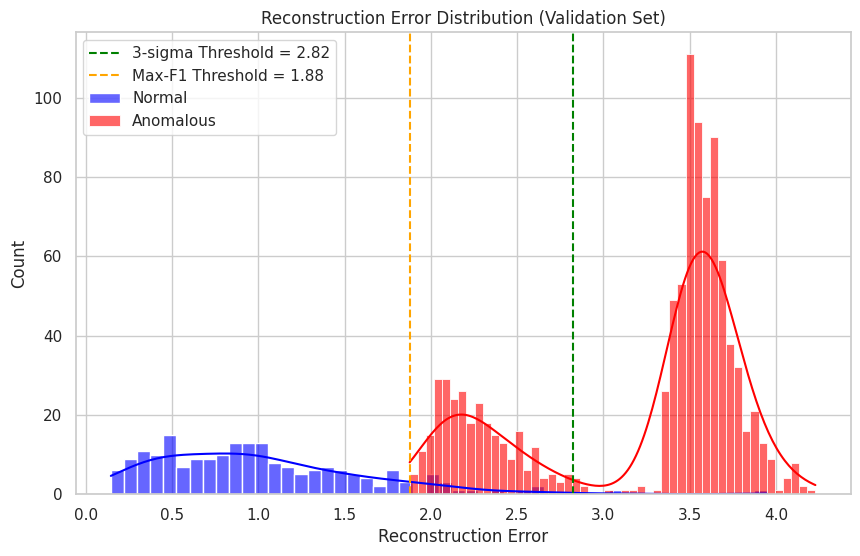

In [44]:
# Separate errors based on true labels
errors_val_normal = val_errors[y_val == 0]
errors_val_anomalous = val_errors[y_val == 1]

mean_val_error = np.mean(errors_val_normal)
std_val_error = np.std(errors_val_normal)
threshold = mean_val_error + 3 * std_val_error

# Plotting the distribution with both thresholds
plt.figure(figsize=(10, 6))
sns.histplot(errors_val_normal, bins=50, color='blue', alpha=0.6, label='Normal', kde=True)
sns.histplot(errors_val_anomalous, bins=50, color='red', alpha=0.6, label='Anomalous', kde=True)
plt.axvline(threshold, color='green', linestyle='--', label=f'3-sigma Threshold = {threshold:.2f}')
plt.axvline(optimal_threshold, color='orange', linestyle='--', label=f'Max-F1 Threshold = {optimal_threshold:.2f}')
plt.title('Reconstruction Error Distribution (Validation Set)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.show()

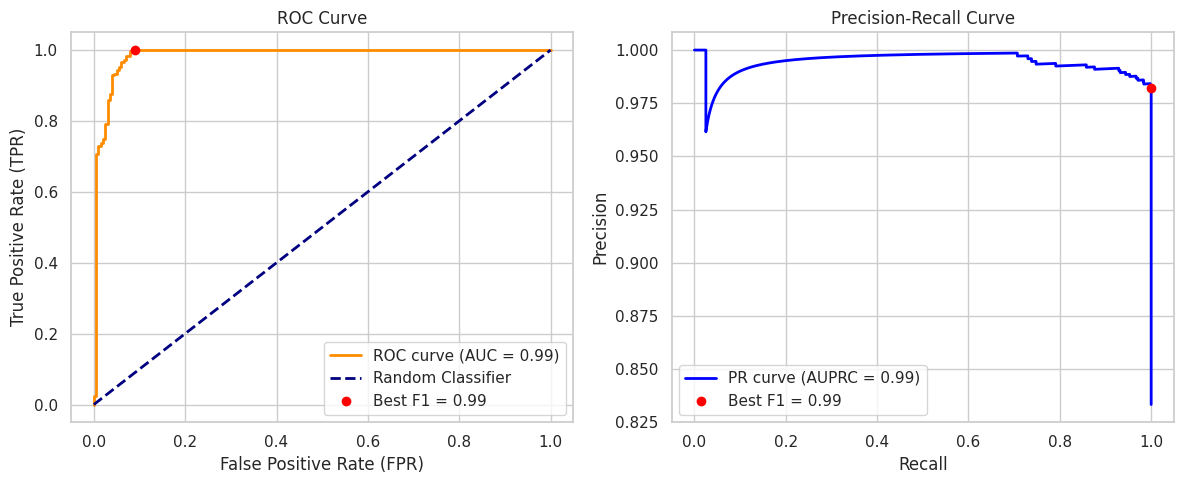

In [45]:
def plot_curves_with_best_f1(y_true, recon_errors, best_f1_threshold, best_f1):
    # Compute ROC curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, recon_errors)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall curve
    precision, recall, pr_thresholds = precision_recall_curve(y_true, recon_errors)
    avg_precision = auc(recall, precision)

    # Find the index of the best F1 threshold in the ROC curve
    best_f1_roc_idx = np.argmin(np.abs(roc_thresholds - best_f1_threshold))
    # Find the index of the best F1 threshold in the PR curve
    best_f1_pr_idx = np.argmin(np.abs(pr_thresholds - best_f1_threshold))

    # Plot ROC curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.scatter(fpr[best_f1_roc_idx], tpr[best_f1_roc_idx], color='red', label=f'Best F1 = {best_f1:.2f}', zorder=5)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUPRC = {avg_precision:.2f})')
    plt.scatter(recall[best_f1_pr_idx], precision[best_f1_pr_idx], color='red', label=f'Best F1 = {best_f1:.2f}', zorder=5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_curves_with_best_f1(y_val, val_errors, optimal_threshold, best_f1)

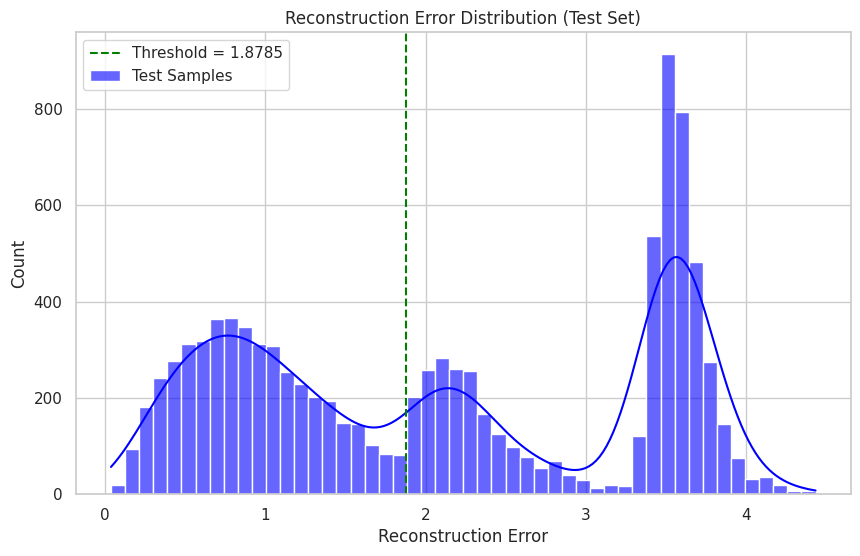

Number of potential anomalies detected in the test set: 5419


In [46]:
def plot_test_error_distribution(test_errors, threshold, title='Test Set'):
    """
    Plots the reconstruction error distribution for the test set and highlights anomalies.

    Args:
        test_errors (np.ndarray): Reconstruction errors on the test set.
        threshold (float): Threshold for anomaly detection.
        title (str, optional): Title of the plot. Defaults to 'Test Set'.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(test_errors, bins=50, color='blue', alpha=0.6, label='Test Samples', kde=True)
    plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.title(f'Reconstruction Error Distribution ({title})')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

y_test_pred = (X_test_scaled > optimal_threshold).astype(int)  

# Create Test Dataset
test_dataset = CustomDataset(X_test_scaled, labels=None, transform=None)

# Create Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Compute reconstruction errors on the test set
test_errors = compute_reconstruction_error(final_vae, test_loader, device)

# Plot reconstruction error distribution for test set
plot_test_error_distribution(test_errors, optimal_threshold, title='Test Set')

# Optionally, identify potential anomalies
anomalies = test_errors > optimal_threshold
num_anomalies = np.sum(anomalies)
print(f"Number of potential anomalies detected in the test set: {num_anomalies}")

In [48]:
# Annotate the test set using the best VAE model
y_test_pred_vae = (test_errors > optimal_threshold).astype(int)

print(f"Number of anomalies detected by VAE: {sum(y_test_pred_vae)}")
print(f"Percentage of anomalies: {sum(y_test_pred_vae) / len(y_test_pred_vae):.2%}")

torch.save(y_test_pred_vae, '2.pt')


Number of anomalies detected by VAE: 5419
Percentage of anomalies: 54.19%


In [38]:
# Load the existing '1.pt' file
labels = torch.load('2.pt')  # Assuming '1.pt' contains a NumPy array of labels

# Verify the type and shape of the loaded data
print(f"Type of loaded data: {type(labels)}")
print(f"Shape of labels: {labels.shape}")

# Initialize a list to store original x values
X_test_original = []

# Iterate through the ad_test_data
for idx in range(len(ad_test_data)):
    item = ad_test_data[idx]
    if isinstance(item, (tuple, list)) and len(item) >= 1:
        x = item[0]  # Assuming the first element is the image/tensor
        if isinstance(x, torch.Tensor):
            X_test_original.append(x.numpy())
        elif isinstance(x, np.ndarray):
            X_test_original.append(x)
        else:
            print(f"Unsupported data type at index {idx}: {type(x)}")
    else:
        print(f"Unexpected item format at index {idx}: {item}")

# Convert list to NumPy array
X_test_original = np.array(X_test_original)

# Verify the shape of the extracted x values
print(f"Shape of original x values: {X_test_original.shape}")
# Verify that the number of labels matches the number of x_original samples
if labels.shape[0] != X_test_original.shape[0]:
    raise ValueError("Number of labels and x_original samples do not match.")

# Create a dictionary to hold both labels and original x values
combined_data = {
    'x_original': X_test_original,  # NumPy array of original x values
    'labels': labels            # NumPy array of labels
}

# Verify the combined structure
print("Keys in combined_data:", combined_data.keys())
print(f"Shape of 'labels': {combined_data['labels'].shape}")
print(f"Shape of 'x_original': {combined_data['x_original'].shape}")

torch.save(combined_data, '2_updated.pt')

print("Updated data saved to '2_updated.pt'.")

/var/folders/25/r3kdxyns1cd4nyp45rchscxh0000gn/T/ipykernel_40972/1540538439.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load('2.pt')  # Assuming '1.pt

Type of loaded data: <class 'numpy.ndarray'>
Shape of labels: (10000,)
Shape of original x values: (10000, 1, 32, 32)
Keys in combined_data: dict_keys(['x_original', 'labels'])
Shape of 'labels': (10000,)
Shape of 'x_original': (10000, 1, 32, 32)
Updated data saved to '2_updated.pt'.



Comparison of VAE and Isolation Forest predictions:
VAE Anomalies: 5419
Isolation Forest Anomalies: 7891
Agreement between VAE and Isolation Forest: 75.28%


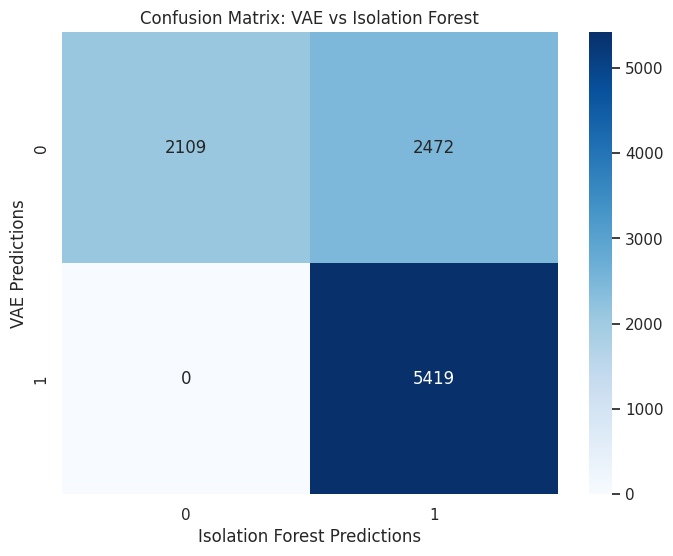

In [62]:
# Compare with Isolation Forest predictions (assuming you have them)
if 'y_test_pred_optimal' in globals():
    print("\nComparison of VAE and Isolation Forest predictions:")
    print("VAE Anomalies:", sum(y_test_pred_vae))
    print("Isolation Forest Anomalies:", sum(y_test_pred_optimal))

    # Calculate agreement between VAE and Isolation Forest
    agreement = np.mean(y_test_pred_vae == y_test_pred_optimal)
    print(f"Agreement between VAE and Isolation Forest: {agreement:.2%}")

    # Create a confusion matrix between VAE and Isolation Forest predictions
    cm = confusion_matrix(y_test_pred_vae, y_test_pred_optimal)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix: VAE vs Isolation Forest')
    plt.xlabel('Isolation Forest Predictions')
    plt.ylabel('VAE Predictions')
    plt.show()
else:
    print("\nIsolation Forest predictions not found. Unable to compare.")

#### Convolutional Autoencoder (CAE)

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# 1. Data Loading and Preprocessing
# -----------------------------

def flatten_ad_ood(data, expect_labels=True, flatten_images=True):
    processed = []
    labels = []  
    for idx, item in enumerate(data):
        if expect_labels:
            if isinstance(item, (tuple, list)) and len(item) == 2:
                image, label = item
                labels.append(label) 
            else:
                raise ValueError(f"Expected tuple with 2 elements, got {item} at index {idx}")
        else:
            if isinstance(item, (tuple, list)) and len(item) == 1:
                image_input = item[0]
                if isinstance(image_input, str):
                    
                    try:
                        image = Image.open(image_input).convert('L')  
                        image = np.array(image)
                    except Exception as e:
                        raise ValueError(f"Error loading image at index {idx}: {e}")
                elif isinstance(image_input, torch.Tensor):
                    image = image_input.numpy()
                else:
                    raise ValueError(f"Expected image path or tensor, got {type(image_input)} at index {idx}")
            elif isinstance(item, torch.Tensor):
                image = item.numpy()
            else:
                raise ValueError(f"Expected single image tensor or image path, got {item} at index {idx}")

        if flatten_images:
            processed.append(image.flatten())
        else:
            processed.append(image)

    if expect_labels:
        return np.array(processed), np.array(labels)
    else:
        return np.array(processed)

def preprocess_ad_ood_cae(ad_val_data, ad_test_data, flatten_images=True):
    """
    Preprocesses the datasets for CAE by flattening images and scaling.

    Args:
        ad_val_data: Validation data with labels.
        ad_test_data: Test data without labels.
        flatten_images (bool): Whether to flatten images.

    Returns:
        Dict containing scaled data and scaler.
    """
    # Process the validation data
    X_val, y_val = flatten_ad_ood(ad_val_data, expect_labels=True, flatten_images=flatten_images)
    # Process the test data
    X_test = flatten_ad_ood(ad_test_data, expect_labels=False, flatten_images=flatten_images)

    # Separate normal and anomalous data in the validation set
    normal_indices = np.where(y_val == 0)[0]
    anomalous_indices = np.where(y_val == 1)[0]

    X_normal = X_val[normal_indices]
    y_normal = y_val[normal_indices]  
    X_anomalous = X_val[anomalous_indices]
    y_anomalous = y_val[anomalous_indices]  

    # Scale the data using only normal data
    scaler = StandardScaler()

    if flatten_images:
        # If images are flattened, proceed as usual
        X_normal_scaled = scaler.fit_transform(X_normal)
        X_anomalous_scaled = scaler.transform(X_anomalous)
        X_test_scaled = scaler.transform(X_test)
    else:
        # If images are not flattened, reshape them to 2D for scaling
        n_samples, *image_dims = X_normal.shape  
        X_normal_reshaped = X_normal.reshape(n_samples, -1)
        X_anomalous_reshaped = X_anomalous.reshape(anomalous_indices.shape[0], -1)
        X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

        # Apply StandardScaler on the reshaped data
        X_normal_scaled = scaler.fit_transform(X_normal_reshaped).reshape(X_normal.shape)
        X_anomalous_scaled = scaler.transform(X_anomalous_reshaped).reshape(X_anomalous.shape)
        X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

    return {
        'X_normal_scaled': X_normal_scaled,
        'y_normal': y_normal,
        'X_anomalous_scaled': X_anomalous_scaled,
        'y_anomalous': y_anomalous,
        'X_test_scaled': X_test_scaled,
        'scaler': scaler
    }

# Preprocess data for CAE 
preprocessed_data = preprocess_ad_ood_cae(ad_val_data, ad_test_data, flatten_images=False)

X_normal_scaled = preprocessed_data['X_normal_scaled']
y_normal = preprocessed_data['y_normal']
X_anomalous_scaled = preprocessed_data['X_anomalous_scaled']
y_anomalous = preprocessed_data['y_anomalous']
X_test_scaled = preprocessed_data['X_test_scaled']
scaler = preprocessed_data['scaler']

# -----------------------------
# 2. Dataset and DataLoader Setup
# -----------------------------

def get_augmentation():
    """
    Defines the augmentation pipeline using Albumentations.
    Not used for CAE as augmentations are typically not beneficial.
    """
    return None  

class CustomDataset(Dataset):
    def __init__(self, images, labels=None, transform=None, flatten_images=True):
        """
        Custom Dataset for CAE.

        Args:
            images (np.ndarray): Array of images.
            labels (np.ndarray, optional): Array of labels. Defaults to None.
            transform (callable, optional): Transformation to apply. Defaults to None.
            flatten_images (bool): Indicates if images are flattened.
        """
        self.images = images
        self.labels = labels
        self.transform = transform
        self.flatten_images = flatten_images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        if not self.flatten_images:
            # Reshape to [C, H, W]
            image = image.reshape(1, 32, 32)  
        if self.transform:
            image = self.transform(image=image)['image']
        image = torch.tensor(image)  
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image, 0

def create_dataloaders(X_normal_scaled, y_normal, X_anomalous_scaled, y_anomalous,
                       batch_size=64, transform_train=None, transform_val=None,
                       flatten_images=True):
    """
    Creates DataLoaders for training and validation.

    Args:
        X_normal_scaled (np.ndarray): Normal training images.
        y_normal (np.ndarray): Labels for normal training images.
        X_anomalous_scaled (np.ndarray): Anomalous validation images.
        y_anomalous (np.ndarray): Labels for anomalous validation images.
        batch_size (int, optional): Batch size. Defaults to 64.
        transform_train (callable, optional): Transform for training data. Defaults to None.
        transform_val (callable, optional): Transform for validation data. Defaults to None.
        flatten_images (bool): Indicates if images are flattened.

    Returns:
        DataLoader: Training DataLoader.
        DataLoader: Validation DataLoader.
        np.ndarray: Ground truth labels for validation set.
    """
    # Split normal data into training and validation (80-20)
    X_train, X_val_normal, y_train, y_val_normal = train_test_split(
        X_normal_scaled, y_normal, test_size=0.2, random_state=42, shuffle=True
    )

    # Combine validation normal and anomalous data
    X_val = np.concatenate((X_val_normal, X_anomalous_scaled), axis=0)
    y_val = np.concatenate((y_val_normal, y_anomalous), axis=0)

    # Create Datasets
    train_dataset = CustomDataset(X_train, y_train, transform=transform_train, flatten_images=flatten_images)
    val_dataset = CustomDataset(X_val, y_val, transform=transform_val, flatten_images=flatten_images)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, y_val

# Create DataLoaders without augmentation for CAE
train_loader, val_loader, y_val = create_dataloaders(
    X_normal_scaled, y_normal, X_anomalous_scaled, y_anomalous,
    batch_size=64, transform_train=None, transform_val=None, flatten_images=False
)

class CAE(nn.Module):
    def __init__(self, input_channels=1, latent_dim=64, hidden_dims=[32, 64, 128]):
        """
        Convolutional Autoencoder (CAE) for Anomaly Detection.

        Args:
            input_channels (int): Number of input channels. Default is 1 for grayscale images.
            latent_dim (int): Dimension of the latent space.
            hidden_dims (list of int): Number of feature maps for each Conv layer in the encoder.
                                       The decoder mirrors this architecture in reverse.
        """
        super(CAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims

        # Encoder
        encoder_layers = []
        in_channels = input_channels
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Conv2d(in_channels, h_dim, kernel_size=3, stride=2, padding=1))
            encoder_layers.append(nn.ReLU(True))
            in_channels = h_dim
        self.encoder = nn.Sequential(*encoder_layers)

        # Bottleneck
        self.fc1 = nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dims[-1] * 4 * 4)
        decoder_layers = []
        reversed_hidden_dims = hidden_dims[::-1]
        in_channels = reversed_hidden_dims[0]
        for h_dim in reversed_hidden_dims[1:]:
            decoder_layers.append(
                nn.ConvTranspose2d(in_channels, h_dim, kernel_size=3, stride=2, padding=1, output_padding=1)
            )
            decoder_layers.append(nn.ReLU(True))
            in_channels = h_dim
        # Final layer to reconstruct the original image
        decoder_layers.append(
            nn.ConvTranspose2d(in_channels, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        decoder_layers.append(nn.Sigmoid())  
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        """
        Forward pass of the CAE.

        Args:
            x (torch.Tensor): Input tensor of shape [B, C, H, W].

        Returns:
            torch.Tensor: Reconstructed tensor of the same shape as input.
        """
        batch_size = x.size(0)
        enc = self.encoder(x)
        enc = enc.view(batch_size, -1)
        z = self.fc1(enc)
        dec = self.fc2(z)
        dec = dec.view(batch_size, self.hidden_dims[-1], 4, 4)
        reconstructed = self.decoder(dec)
        return reconstructed

# 7. Reconstruction Error Function
def compute_reconstruction_error(model, data_loader, device):
    """
    Computes the mean reconstruction error for each sample in the data_loader.

    Args:
        model (nn.Module): Trained CAE model.
        data_loader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to perform computations on.

    Returns:
        np.ndarray: Array of reconstruction errors.
    """
    model.eval()
    reconstruction_errors = []

    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            reconstructed = model(X_batch)
            mse = F.mse_loss(reconstructed, X_batch, reduction='none')
            mse = mse.view(mse.size(0), -1).mean(dim=1)
            reconstruction_errors.extend(mse.cpu().numpy())

    return np.array(reconstruction_errors)

Using device: cpu


In [68]:
def hyperparameter_tuning_cae(ad_val_data, ad_test_data, ood_val_data, ood_test_data, param_grid, batch_size=64):
    """
    Performs hyperparameter tuning for CAE similar to OCSVM.

    Args:
        ad_val_data: Validation data with labels.
        ad_test_data: Test data without labels.
        ood_val_data: Out-of-distribution validation data.
        ood_test_data: Out-of-distribution test data.
        param_grid (dict): Hyperparameter grid.
        batch_size (int, optional): Batch size. Defaults to 64.

    Returns:
        dict: Best hyperparameters.
    """
    # Preprocess data
    preprocessed_data = preprocess_ad_ood_cae(
        ad_val_data, ad_test_data, flatten_images=False
    )

    X_normal_scaled = preprocessed_data['X_normal_scaled']
    y_normal = preprocessed_data['y_normal']
    X_anomalous_scaled = preprocessed_data['X_anomalous_scaled']
    y_anomalous = preprocessed_data['y_anomalous']
    X_test_scaled = preprocessed_data['X_test_scaled']
    scaler = preprocessed_data['scaler']

    best_params = None
    best_f1 = 0.0

    # Iterate over all combinations of parameters
    for params in ParameterGrid(param_grid):
        print(f"Testing hyperparameters: {params}")

        # Instantiate CAE with current hyperparameters
        cae = CAE(
            input_channels=1,
            latent_dim=params['latent_dim'],
            hidden_dims=params['hidden_dims']
        ).to(device)

        # Define optimizer
        optimizer = torch.optim.Adam(cae.parameters(), lr=params['learning_rate'])

        # Define Learning Rate Scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )

        # Create DataLoaders
        train_loader, val_loader, y_val = create_dataloaders(
            X_normal_scaled, y_normal, X_anomalous_scaled, y_anomalous,
            batch_size=batch_size, flatten_images=False  
        )

        # Training loop with Early Stopping
        best_epoch_loss = float('inf')
        patience_counter = 0
        patience = 10
        best_model_state = None  

        for epoch in range(params['epochs']):
            cae.train()
            running_loss = 0.0
            for X_batch, _ in train_loader:
                X_batch = X_batch.to(device)

                # Forward pass
                reconstructed = cae(X_batch)
                loss = F.mse_loss(reconstructed, X_batch, reduction='mean')

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * X_batch.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            print(f"Epoch [{epoch + 1}/{params['epochs']}], Training Loss: {epoch_loss:.4f}")

            # Validation loss for scheduler
            cae.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for X_val_batch, _ in val_loader:
                    X_val_batch = X_val_batch.to(device)
                    reconstructed_val = cae(X_val_batch)
                    val_loss = F.mse_loss(reconstructed_val, X_val_batch, reduction='mean')
                    val_running_loss += val_loss.item() * X_val_batch.size(0)
            val_epoch_loss = val_running_loss / len(val_loader.dataset)
            print(f"Epoch [{epoch + 1}/{params['epochs']}], Validation Loss: {val_epoch_loss:.4f}")

            # Step the scheduler
            scheduler.step(val_epoch_loss)

            # Early Stopping Check
            if val_epoch_loss < best_epoch_loss:
                best_epoch_loss = val_epoch_loss
                patience_counter = 0
                best_model_state = cae.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        # Ensure that best_model_state is found
        if best_model_state is not None:
            cae.load_state_dict(best_model_state)
        else:
            print("No improvement observed during training.")

        # Compute reconstruction error on validation set
        recon_errors = compute_reconstruction_error(cae, val_loader, device)

        # Determine optimal threshold based on F1-Score
        thresholds = np.linspace(np.min(recon_errors), np.max(recon_errors), 100)
        f1_scores = []
        for thresh in thresholds:
            y_pred = (recon_errors >= thresh).astype(int)
            f1 = f1_score(y_val, y_pred)
            f1_scores.append(f1)

        max_f1 = max(f1_scores)
        optimal_idx = f1_scores.index(max_f1)
        optimal_threshold = thresholds[optimal_idx]

        print(f"Validation Reconstruction Error Mean: {np.mean(recon_errors):.4f}, Std: {np.std(recon_errors):.4f}")
        print(f"Optimal Threshold for Anomaly Detection: {optimal_threshold:.4f}")
        print(f"Maximum F1-Score: {max_f1:.4f}")

        # Compute ROC AUC and AUPRC
        roc_auc = roc_auc_score(y_val, recon_errors)
        auprc = average_precision_score(y_val, recon_errors)

        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"AUPRC: {auprc:.4f}")

        # Update best parameters based on F1-score
        if max_f1 > best_f1:
            best_f1 = max_f1
            best_params = params

        print(f"Current Best F1-Score: {best_f1:.4f}, Best Hyperparameters: {best_params}")
        print("-" * 50)

    print(f"Best Hyperparameters: {best_params} with F1-Score: {best_f1:.4f}")

    return best_params

In [24]:
# Define hyperparameter grid
param_grid = {
    'latent_dim': [2, 4],
    'hidden_dims': [
        [32, 64, 128],
        [64, 128, 256]],
    'learning_rate': [0.001, 0.0001],
    'epochs': [30]
}

# Perform hyperparameter tuning
best_hyperparams = hyperparameter_tuning_cae(
    ad_val_data, ad_test_data, ood_val_data, ood_test_data, param_grid, batch_size=256
)

print(f"Best Hyperparameters: {best_hyperparams}")

Testing hyperparameters: {'epochs': 30, 'hidden_dims': [32, 64, 128], 'latent_dim': 2, 'learning_rate': 0.001}


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Training Loss: 1.2652
Epoch [1/30], Validation Loss: 1.9496
Epoch [2/30], Training Loss: 1.2449
Epoch [2/30], Validation Loss: 2.0214
Epoch [3/30], Training Loss: 1.1719
Epoch [3/30], Validation Loss: 2.3704
Epoch [4/30], Training Loss: 1.0353
Epoch [4/30], Validation Loss: 2.6075
Epoch [5/30], Training Loss: 0.9812
Epoch [5/30], Validation Loss: 2.5857
Epoch [6/30], Training Loss: 0.9695
Epoch [6/30], Validation Loss: 2.3955
Epoch [7/30], Training Loss: 0.9487
Epoch [7/30], Validation Loss: 2.1088
Epoch [8/30], Training Loss: 0.9245
Epoch [8/30], Validation Loss: 2.0281
Epoch [9/30], Training Loss: 0.9200
Epoch [9/30], Validation Loss: 2.0198
Epoch [10/30], Training Loss: 0.9131
Epoch [10/30], Validation Loss: 2.0071
Epoch [11/30], Training Loss: 0.9095
Epoch [11/30], Validation Loss: 1.9934
Early stopping at epoch 11
Validation Reconstruction Error Mean: 1.9934, Std: 0.6478
Optimal Threshold for Anomaly Detection: 1.2409
Maximum F1-Score: 0.9745
ROC AUC: 0.9608
AUPRC: 0

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Training Loss: 1.2107
Epoch [1/30], Validation Loss: 2.0118
Epoch [2/30], Training Loss: 1.2078
Epoch [2/30], Validation Loss: 2.0154
Epoch [3/30], Training Loss: 1.2052
Epoch [3/30], Validation Loss: 2.0189
Epoch [4/30], Training Loss: 1.2027
Epoch [4/30], Validation Loss: 2.0224
Epoch [5/30], Training Loss: 1.2003
Epoch [5/30], Validation Loss: 2.0260
Epoch [6/30], Training Loss: 1.1976
Epoch [6/30], Validation Loss: 2.0297
Epoch [7/30], Training Loss: 1.1947
Epoch [7/30], Validation Loss: 2.0341
Epoch [8/30], Training Loss: 1.1915
Epoch [8/30], Validation Loss: 2.0367
Epoch [9/30], Training Loss: 1.1891
Epoch [9/30], Validation Loss: 2.0398
Epoch [10/30], Training Loss: 1.1860
Epoch [10/30], Validation Loss: 2.0435
Epoch [11/30], Training Loss: 1.1821
Epoch [11/30], Validation Loss: 2.0481
Early stopping at epoch 11
Validation Reconstruction Error Mean: 2.0481, Std: 0.6003
Optimal Threshold for Anomaly Detection: 1.2955
Maximum F1-Score: 0.9626
ROC AUC: 0.8858
AUPRC: 0

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Training Loss: 1.2527
Epoch [1/30], Validation Loss: 2.0319
Epoch [2/30], Training Loss: 1.1516
Epoch [2/30], Validation Loss: 2.5628
Epoch [3/30], Training Loss: 1.0041
Epoch [3/30], Validation Loss: 2.7907
Epoch [4/30], Training Loss: 0.9934
Epoch [4/30], Validation Loss: 2.6775
Epoch [5/30], Training Loss: 0.9793
Epoch [5/30], Validation Loss: 2.3950
Epoch [6/30], Training Loss: 0.9501
Epoch [6/30], Validation Loss: 2.1818
Epoch [7/30], Training Loss: 0.9289
Epoch [7/30], Validation Loss: 2.0819
Epoch [8/30], Training Loss: 0.9187
Epoch [8/30], Validation Loss: 1.9881
Epoch [9/30], Training Loss: 0.9129
Epoch [9/30], Validation Loss: 1.9684
Epoch [10/30], Training Loss: 0.9139
Epoch [10/30], Validation Loss: 1.9424
Epoch [11/30], Training Loss: 0.9090
Epoch [11/30], Validation Loss: 1.9119
Epoch [12/30], Training Loss: 0.9047
Epoch [12/30], Validation Loss: 1.8993
Epoch [13/30], Training Loss: 0.9030
Epoch [13/30], Validation Loss: 1.8920
Epoch [14/30], Training Loss: 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Training Loss: 1.2245
Epoch [1/30], Validation Loss: 1.9894
Epoch [2/30], Training Loss: 1.2225
Epoch [2/30], Validation Loss: 1.9919
Epoch [3/30], Training Loss: 1.2205
Epoch [3/30], Validation Loss: 1.9947
Epoch [4/30], Training Loss: 1.2184
Epoch [4/30], Validation Loss: 1.9981
Epoch [5/30], Training Loss: 1.2159
Epoch [5/30], Validation Loss: 2.0033
Epoch [6/30], Training Loss: 1.2124
Epoch [6/30], Validation Loss: 2.0116
Epoch [7/30], Training Loss: 1.2069
Epoch [7/30], Validation Loss: 2.0262
Epoch [8/30], Training Loss: 1.1995
Epoch [8/30], Validation Loss: 2.0377
Epoch [9/30], Training Loss: 1.1933
Epoch [9/30], Validation Loss: 2.0538
Epoch [10/30], Training Loss: 1.1846
Epoch [10/30], Validation Loss: 2.0756
Epoch [11/30], Training Loss: 1.1737
Epoch [11/30], Validation Loss: 2.1051
Early stopping at epoch 11
Validation Reconstruction Error Mean: 2.1051, Std: 0.6339
Optimal Threshold for Anomaly Detection: 1.3100
Maximum F1-Score: 0.9655
ROC AUC: 0.8987
AUPRC: 0

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Training Loss: 1.2146
Epoch [1/30], Validation Loss: 2.4455
Epoch [2/30], Training Loss: 0.9998
Epoch [2/30], Validation Loss: 2.6484
Epoch [3/30], Training Loss: 0.9737
Epoch [3/30], Validation Loss: 2.2778
Epoch [4/30], Training Loss: 0.9385
Epoch [4/30], Validation Loss: 2.1837
Epoch [5/30], Training Loss: 0.9214
Epoch [5/30], Validation Loss: 2.0228
Epoch [6/30], Training Loss: 0.9143
Epoch [6/30], Validation Loss: 1.9343
Epoch [7/30], Training Loss: 0.9034
Epoch [7/30], Validation Loss: 1.9117
Epoch [8/30], Training Loss: 0.9004
Epoch [8/30], Validation Loss: 1.9122
Epoch [9/30], Training Loss: 0.8980
Epoch [9/30], Validation Loss: 1.9008
Epoch [10/30], Training Loss: 0.8939
Epoch [10/30], Validation Loss: 1.9025
Epoch [11/30], Training Loss: 0.8895
Epoch [11/30], Validation Loss: 1.8917
Epoch [12/30], Training Loss: 0.8844
Epoch [12/30], Validation Loss: 1.8881
Epoch [13/30], Training Loss: 0.8790
Epoch [13/30], Validation Loss: 1.8742
Epoch [14/30], Training Loss: 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Training Loss: 1.2572
Epoch [1/30], Validation Loss: 1.9524
Epoch [2/30], Training Loss: 1.2456
Epoch [2/30], Validation Loss: 1.9642
Epoch [3/30], Training Loss: 1.2342
Epoch [3/30], Validation Loss: 1.9777
Epoch [4/30], Training Loss: 1.2214
Epoch [4/30], Validation Loss: 1.9969
Epoch [5/30], Training Loss: 1.2028
Epoch [5/30], Validation Loss: 2.0371
Epoch [6/30], Training Loss: 1.1717
Epoch [6/30], Validation Loss: 2.1343
Epoch [7/30], Training Loss: 1.1203
Epoch [7/30], Validation Loss: 2.2853
Epoch [8/30], Training Loss: 1.0658
Epoch [8/30], Validation Loss: 2.3495
Epoch [9/30], Training Loss: 1.0352
Epoch [9/30], Validation Loss: 2.3910
Epoch [10/30], Training Loss: 1.0095
Epoch [10/30], Validation Loss: 2.3985
Epoch [11/30], Training Loss: 0.9886
Epoch [11/30], Validation Loss: 2.3652
Early stopping at epoch 11
Validation Reconstruction Error Mean: 2.3652, Std: 0.8144
Optimal Threshold for Anomaly Detection: 1.5358
Maximum F1-Score: 0.9807
ROC AUC: 0.9744
AUPRC: 0

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Training Loss: 1.1763
Epoch [1/30], Validation Loss: 2.4939
Epoch [2/30], Training Loss: 0.9823
Epoch [2/30], Validation Loss: 2.3595
Epoch [3/30], Training Loss: 0.9479
Epoch [3/30], Validation Loss: 2.2740
Epoch [4/30], Training Loss: 0.9195
Epoch [4/30], Validation Loss: 1.9995
Epoch [5/30], Training Loss: 0.9069
Epoch [5/30], Validation Loss: 1.9941
Epoch [6/30], Training Loss: 0.8993
Epoch [6/30], Validation Loss: 1.9686
Epoch [7/30], Training Loss: 0.8866
Epoch [7/30], Validation Loss: 1.9545
Epoch [8/30], Training Loss: 0.8784
Epoch [8/30], Validation Loss: 1.9403
Epoch [9/30], Training Loss: 0.8712
Epoch [9/30], Validation Loss: 1.9201
Epoch [10/30], Training Loss: 0.8637
Epoch [10/30], Validation Loss: 1.8941
Epoch [11/30], Training Loss: 0.8544
Epoch [11/30], Validation Loss: 1.8421
Epoch [12/30], Training Loss: 0.8401
Epoch [12/30], Validation Loss: 1.7363
Epoch [13/30], Training Loss: 0.8210
Epoch [13/30], Validation Loss: 1.5113
Epoch [14/30], Training Loss: 

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Training Loss: 1.2779
Epoch [1/30], Validation Loss: 1.9248
Epoch [2/30], Training Loss: 1.2701
Epoch [2/30], Validation Loss: 1.9334
Epoch [3/30], Training Loss: 1.2609
Epoch [3/30], Validation Loss: 1.9474
Epoch [4/30], Training Loss: 1.2460
Epoch [4/30], Validation Loss: 1.9807
Epoch [5/30], Training Loss: 1.2141
Epoch [5/30], Validation Loss: 2.0652
Epoch [6/30], Training Loss: 1.1618
Epoch [6/30], Validation Loss: 2.2116
Epoch [7/30], Training Loss: 1.0988
Epoch [7/30], Validation Loss: 2.3633
Epoch [8/30], Training Loss: 1.0495
Epoch [8/30], Validation Loss: 2.4242
Epoch [9/30], Training Loss: 1.0252
Epoch [9/30], Validation Loss: 2.4633
Epoch [10/30], Training Loss: 1.0042
Epoch [10/30], Validation Loss: 2.4809
Epoch [11/30], Training Loss: 0.9889
Epoch [11/30], Validation Loss: 2.4814
Early stopping at epoch 11
Validation Reconstruction Error Mean: 2.4814, Std: 0.8715
Optimal Threshold for Anomaly Detection: 1.5678
Maximum F1-Score: 0.9832
ROC AUC: 0.9776
AUPRC: 0

In [25]:
best_hyperparams = {
    'latent_dim': 4,
    'hidden_dims': [62, 128, 256],
    'learning_rate': 0.0001,
    'epochs': 30
}

cae_best = CAE(
    input_channels=1,
    latent_dim=best_hyperparams['latent_dim'],
    hidden_dims=best_hyperparams['hidden_dims']
).to(device)


optimizer = torch.optim.Adam(cae_best.parameters(), lr=best_hyperparams['learning_rate'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Training loop with Early Stopping
best_epoch_loss = float('inf')
patience_counter = 0
patience = 10
best_model_state = None  

for epoch in range(best_hyperparams['epochs']):
    cae_best.train()
    running_loss = 0.0
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)

        # Forward pass
        reconstructed = cae_best(X_batch)
        loss = F.mse_loss(reconstructed, X_batch, reduction='mean')

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch + 1}/{best_hyperparams['epochs']}], Training Loss: {epoch_loss:.4f}")

    # Validation loss for scheduler
    cae_best.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for X_val_batch, _ in val_loader:
            X_val_batch = X_val_batch.to(device)
            reconstructed_val = cae_best(X_val_batch)
            val_loss = F.mse_loss(reconstructed_val, X_val_batch, reduction='mean')
            val_running_loss += val_loss.item() * X_val_batch.size(0)
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    print(f"Epoch [{epoch + 1}/{best_hyperparams['epochs']}], Validation Loss: {val_epoch_loss:.4f}")

    # Step the scheduler
    scheduler.step(val_epoch_loss)

    # Early Stopping Check
    if val_epoch_loss < best_epoch_loss:
        best_epoch_loss = val_epoch_loss
        patience_counter = 0
        best_model_state = cae_best.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

# Load the best model state
if best_model_state is not None:
    cae_best.load_state_dict(best_model_state)
else:
    print("No improvement observed during training.")

# Compute reconstruction errors on validation set
recon_errors_best = compute_reconstruction_error(cae_best, val_loader, device)

# Determine optimal threshold based on F1-Score
thresholds = np.linspace(np.min(recon_errors_best), np.max(recon_errors_best), 100)
f1_scores = []
precisions = []
recalls = []
for thresh in thresholds:
    y_pred = (recon_errors_best >= thresh).astype(int)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

max_f1 = max(f1_scores)
optimal_idx = f1_scores.index(max_f1)
optimal_threshold_best = thresholds[optimal_idx]
optimal_precision = precisions[optimal_idx]
optimal_recall = recalls[optimal_idx]

print(f"Best Model Validation Reconstruction Error Mean: {np.mean(recon_errors_best):.4f}, Std: {np.std(recon_errors_best):.4f}")
print(f"Optimal Threshold for Anomaly Detection: {optimal_threshold_best:.4f}")
print(f"Maximum F1-Score: {max_f1:.4f}")
print(f"Precision at optimal threshold: {optimal_precision:.4f}")
print(f"Recall at optimal threshold: {optimal_recall:.4f}")

# Compute ROC AUC and AUPRC
roc_auc_best = roc_auc_score(y_val, recon_errors_best)
auprc_best = average_precision_score(y_val, recon_errors_best)

print(f"AUROC: {roc_auc_best:.4f}")
print(f"AUPRC: {auprc_best:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Training Loss: 1.1990
Epoch [1/30], Validation Loss: 2.0407
Epoch [2/30], Training Loss: 1.1629
Epoch [2/30], Validation Loss: 2.1474
Epoch [3/30], Training Loss: 1.0290
Epoch [3/30], Validation Loss: 2.4185
Epoch [4/30], Training Loss: 0.9501
Epoch [4/30], Validation Loss: 2.1177
Epoch [5/30], Training Loss: 0.9212
Epoch [5/30], Validation Loss: 2.1033
Epoch [6/30], Training Loss: 0.9124
Epoch [6/30], Validation Loss: 2.0781
Epoch [7/30], Training Loss: 0.9058
Epoch [7/30], Validation Loss: 2.0339
Epoch [8/30], Training Loss: 0.8985
Epoch [8/30], Validation Loss: 2.0023
Epoch [9/30], Training Loss: 0.8902
Epoch [9/30], Validation Loss: 1.9753
Epoch [10/30], Training Loss: 0.8807
Epoch [10/30], Validation Loss: 1.9264
Epoch [11/30], Training Loss: 0.8675
Epoch [11/30], Validation Loss: 1.8282
Epoch [12/30], Training Loss: 0.8445
Epoch [12/30], Validation Loss: 1.6255
Epoch [13/30], Training Loss: 0.8152
Epoch [13/30], Validation Loss: 1.3944
Epoch [14/30], Training Loss: 

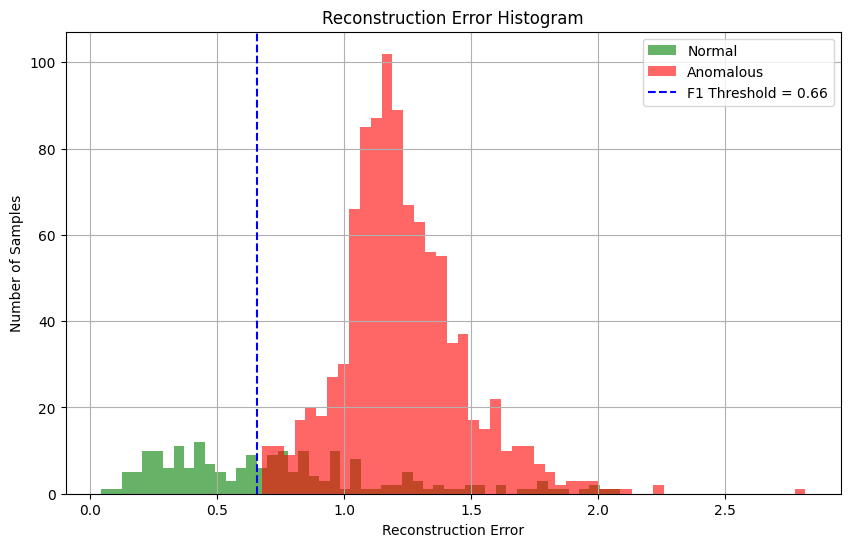

In [26]:
def plot_reconstruction_error_histogram(y_true, recon_errors, optimal_threshold, save_path=None):
    """
    Plots the histogram of reconstruction errors for normal and anomalous samples.

    Args:
        y_true (np.ndarray): Ground truth labels (0 for normal, 1 for anomalous).
        recon_errors (np.ndarray): Reconstruction errors from the CAE.
        optimal_threshold (float): Threshold value that maximizes the F1-score.
        save_path (str, optional): Path to save the plot. Defaults to None.
    """
    # Separate reconstruction errors for normal and anomalous samples
    normal_errors = recon_errors[y_true == 0]
    anomalous_errors = recon_errors[y_true == 1]

    plt.figure(figsize=(10, 6))
    plt.hist(normal_errors, bins=50, alpha=0.6, color='green', label='Normal')
    plt.hist(anomalous_errors, bins=50, alpha=0.6, color='red', label='Anomalous')
    plt.axvline(x=optimal_threshold, color='blue', linestyle='--', label=f'F1 Threshold = {optimal_threshold:.2f}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Number of Samples')
    plt.title('Reconstruction Error Histogram')
    plt.legend(loc='upper right')
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

plot_reconstruction_error_histogram(y_val, recon_errors_best, optimal_threshold_best)

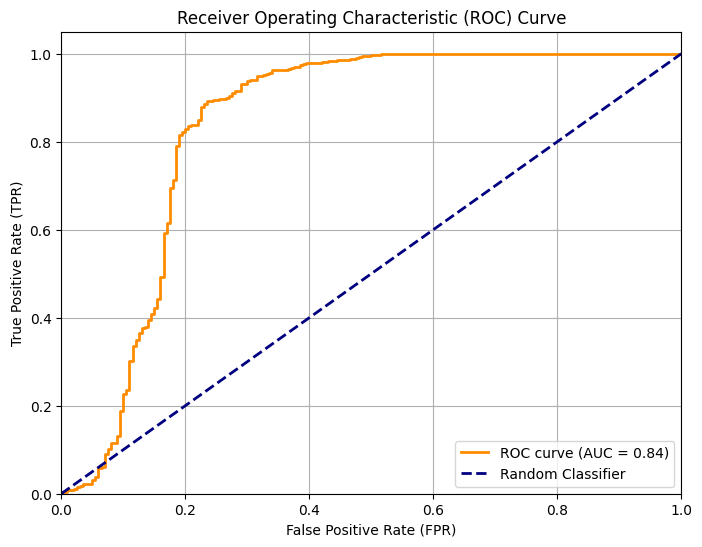

In [27]:
def plot_roc_curve(y_true, recon_errors, save_path=None):
    """
    Plots the Receiver Operating Characteristic (ROC) curve.

    Args:
        y_true (np.ndarray): Ground truth labels (0 for normal, 1 for anomalous).
        recon_errors (np.ndarray): Reconstruction errors from the CAE.
        save_path (str, optional): Path to save the plot. Defaults to None.
    """
    fpr, tpr, thresholds = roc_curve(y_true, recon_errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

plot_roc_curve(y_val, recon_errors_best)

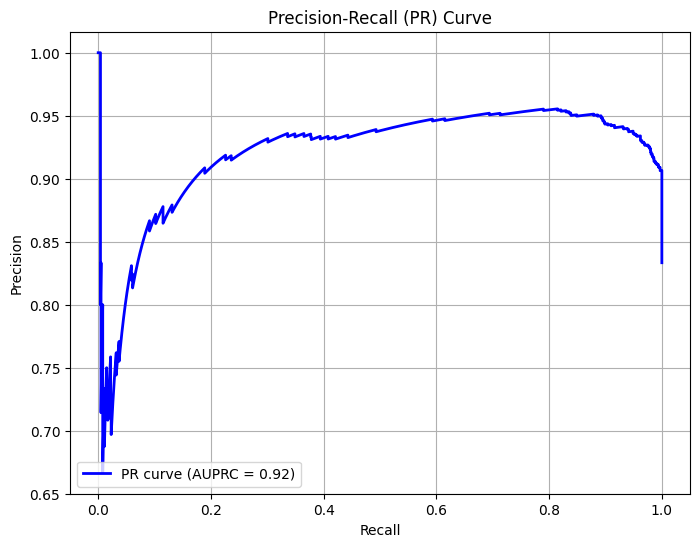

In [28]:
def plot_pr_curve(y_true, recon_errors, save_path=None):
    """
    Plots the Precision-Recall (PR) curve.

    Args:
        y_true (np.ndarray): Ground truth labels (0 for normal, 1 for anomalous).
        recon_errors (np.ndarray): Reconstruction errors from the CAE.
        save_path (str, optional): Path to save the plot. Defaults to None.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, recon_errors)
    avg_precision = average_precision_score(y_true, recon_errors)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue',
             lw=2, label=f'PR curve (AUPRC = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    if save_path:
        plt.savefig(save_path)
    plt.show()

plot_pr_curve(y_val, recon_errors_best)

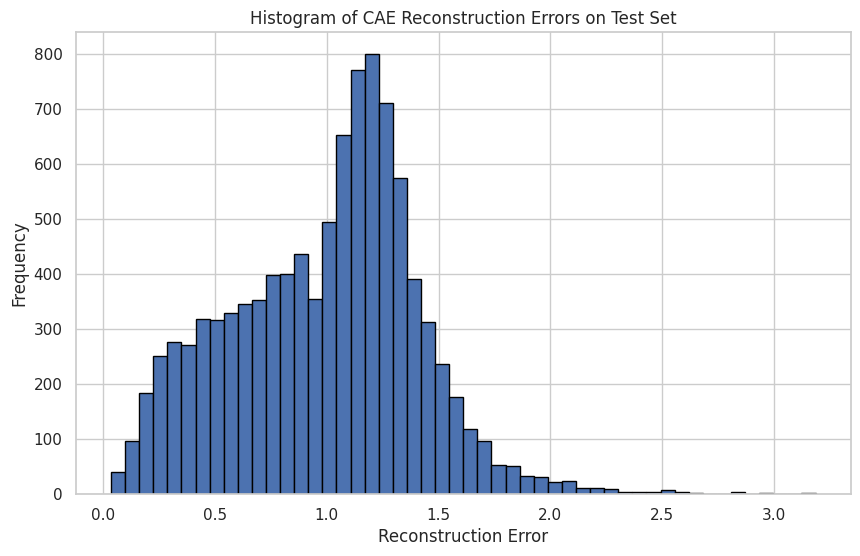

Threshold: 1.8262984156608582
Number of predicted anomalies: 210


In [71]:
def predict_cae(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            images = batch[0].to(device)
            outputs = model(images)
            mse_loss = nn.MSELoss(reduction='none')
            reconstruction_errors = mse_loss(outputs, images).mean(dim=[1,2,3])
            predictions.extend(reconstruction_errors.cpu().numpy())
    return np.array(predictions)

# Create a DataLoader for the test set
test_dataset = CustomDataset(X_test_scaled, transform=None)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Predict using the CAE model
cae_predictions = predict_cae(cae_best, test_loader, device)

# Plot histogram of reconstruction errors
plt.figure(figsize=(10, 6))
plt.hist(cae_predictions, bins=50, edgecolor='black')
plt.title('Histogram of CAE Reconstruction Errors on Test Set')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# You can set a threshold based on validation set statistics
threshold = np.mean(recon_errors_best) + 2 * np.std(recon_errors_best)
print(f"Threshold: {threshold}")

# Classify test samples as normal or anomalous
test_predictions = (cae_predictions > threshold).astype(int)

# Count the number of predicted anomalies
num_anomalies = np.sum(test_predictions)
print(f"Number of predicted anomalies: {num_anomalies}")


## Out-Of-Distribution (OOD) Model




#### Vision Transformer (ViT)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def flatten_ad_ood(data, expect_labels=True, flatten_images=False):
    processed = []
    labels = []  
    for idx, item in enumerate(data):
        if expect_labels:
            if isinstance(item, (tuple, list)) and len(item) == 2:
                image, label = item
                labels.append(label)  
            else:
                raise ValueError(f"Expected tuple with 2 elements, got {item} at index {idx}")
        else:
            if isinstance(item, (tuple, list)) and len(item) == 1:
                image = item[0]
            elif isinstance(item, torch.Tensor):
                image = item
            else:
                raise ValueError(f"Expected single image tensor, got {item} at index {idx}")

        if flatten_images:
            processed.append(image.numpy().flatten())
        else:
            processed.append(image.numpy())

    if expect_labels:
        return np.array(processed), np.array(labels)
    else:
        return np.array(processed)

Using device: cuda


In [ ]:
# -----------------------------
# 1. Data Loading and Preprocessing for Binary Classification
# -----------------------------

def preprocess_for_binary(ood_val_data, ood_test_data, test_size=0.2):
    """
    Prepares data for Binary Classification (Normal vs. OOD) by performing an 80-20 split
    on both normal and OOD samples to create balanced training and validation sets.

    Args:
        ood_val_data: OOD validation data containing both normal (0) and OOD (1) samples with labels.
        ood_test_data: OOD test data without labels.
        test_size (float, optional): Proportion of each class (normal and OOD) to include in the validation set. Defaults to 0.2.

    Returns:
        X_train (np.ndarray): Training images combining normal and OOD samples.
        y_train (np.ndarray): Training labels corresponding to X_train.
        X_val (np.ndarray): Validation images combining normal and OOD samples.
        y_val (np.ndarray): Validation labels corresponding to X_val.
        X_test (np.ndarray): Test images (OOD samples without labels).
    """
    # Extract all samples with labels from ood_val_data
    X_all, y_all = flatten_ad_ood(ood_val_data, expect_labels=True, flatten_images=False)

    # Separate normal and OOD samples based on labels
    X_normal = X_all[y_all == 0]
    y_normal = y_all[y_all == 0]

    X_ood = X_all[y_all == 1]
    y_ood = y_all[y_all == 1]

    # Perform an 80-20 split on normal samples
    X_train_normal, X_val_normal, y_train_normal, y_val_normal = train_test_split(
        X_normal, y_normal, test_size=test_size, random_state=42, shuffle=True
    )

    # Perform an 80-20 split on OOD samples
    X_train_ood, X_val_ood, y_train_ood, y_val_ood = train_test_split(
        X_ood, y_ood, test_size=test_size, random_state=42, shuffle=True
    )

    # Combine normal and OOD samples for training
    X_train = np.concatenate((X_train_normal, X_train_ood), axis=0)
    y_train = np.concatenate((y_train_normal, y_train_ood), axis=0)

    # Combine normal and OOD samples for validation
    X_val = np.concatenate((X_val_normal, X_val_ood), axis=0)
    y_val = np.concatenate((y_val_normal, y_val_ood), axis=0)

    # Load test data (unlabeled OOD samples)
    X_test = flatten_ad_ood(ood_test_data, expect_labels=False, flatten_images=False)

    return X_train, y_train, X_val, y_val, X_test

# Preprocess data
X_train, y_train, X_val, y_val, X_test = preprocess_for_binary(ood_val_data, ood_test_data, test_size=0.2)

# -----------------------------
# 2. Dataset and DataLoader Setup (Binary Classification)
# -----------------------------

class CustomBinaryDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        """
        Custom Dataset for Binary Classification (Normal vs OOD).

        Args:
            images (np.ndarray): Array of images with shape [N, H, W] or [N, C, H, W].
            labels (np.ndarray, optional): Array of labels (0 for normal, 1 for OOD). Defaults to None.
            transform (callable, optional): Transformation to apply. Defaults to None.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
       
        image = self.images[idx]

        if image.ndim == 4:
            # Shape: (1, 1, 32, 32) or similar
            image = image.squeeze(0)  
            if image.ndim == 3 and image.shape[0] == 1:
                image = image.squeeze(0)  
        elif image.ndim == 3:
            # Shape: (1, 32, 32)
            image = image.squeeze(0)
        elif image.ndim == 2:
            # Shape: (32, 32)
            pass
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")

        # Normalize from [-2, 2] to [0, 255] and convert to PIL Image
        image = Image.fromarray(((image + 2) / 4 * 255).astype(np.uint8))

        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            label = self.labels[idx]
            return image, torch.tensor(label, dtype=torch.float32)
        else:
            return image

def get_binary_transforms():
    """
    Defines the transformation pipeline for ViT in binary classification.

    Returns:
        transform: torchvision transforms.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.Grayscale(num_output_channels=3),  
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  
    ])
    return transform

def create_binary_dataloaders(X_train, y_train, X_val, y_val, batch_size=64):
    """
    Creates DataLoaders for Binary Classification.

    Args:
        X_train (np.ndarray): Normal training images.
        y_train (np.ndarray): Labels for normal training images.
        X_val (np.ndarray): Validation images (normal + OOD).
        y_val (np.ndarray): Labels for validation images.
        batch_size (int, optional): Batch size. Defaults to 64.

    Returns:
        DataLoader: Training DataLoader.
        DataLoader: Validation DataLoader.
        np.ndarray: Ground truth labels for validation set.
    """
    transform = get_binary_transforms()

    # Create Datasets
    train_dataset = CustomBinaryDataset(X_train, y_train, transform=transform)
    val_dataset = CustomBinaryDataset(X_val, y_val, transform=transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, y_val

# Create DataLoaders using only ood_val_data and ood_test_data
train_loader_binary, val_loader_binary, y_val_binary = create_binary_dataloaders(
    X_train, y_train, X_val, y_val, batch_size=64
)

# -----------------------------
# 3. ViT Model Definition for Binary Classification
# -----------------------------

def load_pretrained_vit_binary(pretrained=True):
    """
    Loads a pre-trained Vision Transformer and modifies the classifier for binary classification.

    Args:
        pretrained (bool, optional): Whether to use pre-trained weights. Defaults to True.

    Returns:
        model: Modified ViT model for binary classification.
    """
    # Load pre-trained ViT
    model = models.vit_b_16(pretrained=pretrained)


    model.heads = nn.Linear(model.heads.head.in_features, 1)  

    return model

model_vit_binary = load_pretrained_vit_binary(pretrained=True)

# -----------------------------
# 4. Feature Extraction
# -----------------------------

class ViTFeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(ViTFeatureExtractor, self).__init__()
        # Replace the classification head with an identity function
        original_model.heads = nn.Identity()
        self.features = original_model

    def forward(self, x):
        with torch.no_grad():
            x = self.features(x)  
        return x

feature_extractor = ViTFeatureExtractor(model_vit_binary).to(device)
feature_extractor.eval()

# -----------------------------
# 5. Fine-Tuning the ViT Model 
# -----------------------------

def fine_tune_vit_binary_with_amp(model, train_loader, val_loader, hyperparams, num_epochs=10, device='cuda'):
    """
    Fine-tunes the Vision Transformer model on the training data with given hyperparameters using AMP.

    Args:
        model: Vision Transformer model.
        train_loader (DataLoader): Training DataLoader.
        val_loader (DataLoader): Validation DataLoader.
        hyperparams (dict): Dictionary containing hyperparameters.
        num_epochs (int, optional): Number of epochs. Defaults to 10.
        device (str, optional): Device to use. Defaults to 'cuda'.

    Returns:
        model: Fine-tuned model.
        float: Best validation accuracy achieved.
    """
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()  

    # Choose optimizer based on hyperparameters
    optimizer_type = hyperparams.get('optimizer', 'AdamW')
    if optimizer_type == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=hyperparams['weight_decay'])
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=hyperparams['weight_decay'], momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    scaler = GradScaler()  

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)  

            optimizer.zero_grad()

            with autocast():  
                outputs = model(images)  
                loss = criterion(outputs, labels.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1) 
                outputs = model(images)
                preds = (torch.sigmoid(outputs) >= 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        epoch_acc = correct / total
        print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.4f}')

        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            best_model_state = deepcopy(model.state_dict())

    print(f'Best Validation Accuracy: {best_val_acc:.4f}')
    model.load_state_dict(best_model_state)
    return model, best_val_acc

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define the hyperparameter grid
hyperparameter_grid = {
    'learning_rate': [1e-4, 3e-4, 1e-3],
    'weight_decay': [1e-4, 1e-3],
    'optimizer': ['AdamW']
}

# Generate all combinations of hyperparameters
param_grid = list(ParameterGrid(hyperparameter_grid))
print(f'Total hyperparameter combinations: {len(param_grid)}')

# Initialize a list to store results
tuning_results = []

# Iterate over each hyperparameter combination with progress bar
for idx, params in enumerate(tqdm(param_grid, desc="Hyperparameter Tuning")):
    print(f"\nHyperparameter Combination {idx+1}/{len(param_grid)}: {params}")

    # Deep copy the original model to ensure fresh weights for each run
    model_copy = deepcopy(model_vit_binary)

    # Fine-tune the model with the current hyperparameters using AMP
    fine_tuned_model, val_accuracy = fine_tune_vit_binary_with_amp(
        model_copy,
        train_loader_binary,
        val_loader_binary,
        hyperparams=params,
        num_epochs=15,
        device=device
    )

    tuning_results.append({
        'params': params,
        'val_accuracy': val_accuracy
    })

# Find the hyperparameter combination with the highest validation accuracy
best_result = max(tuning_results, key=lambda x: x['val_accuracy'])
print("\nBest Hyperparameter Combination:")
print(best_result['params'])
print(f"Validation Accuracy: {best_result['val_accuracy']:.4f}")

Total hyperparameter combinations: 6


Hyperparameter Tuning:   0%|          | 0/6 [00:00<?, ?it/s]


Hyperparameter Combination 1/6: {'learning_rate': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.0001}


<ipython-input-5-864fb44c87e1>:270: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize GradScaler for AMP
<ipython-input-5-864fb44c87e1>:285: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable autocasting for mixed precision


Epoch 1/15 | Loss: 0.3696 | Val Acc: 0.9140
Epoch 2/15 | Loss: 0.1526 | Val Acc: 0.8960
Epoch 3/15 | Loss: 0.0813 | Val Acc: 0.9030
Epoch 4/15 | Loss: 0.0557 | Val Acc: 0.9140
Epoch 5/15 | Loss: 0.0439 | Val Acc: 0.9050
Epoch 6/15 | Loss: 0.0190 | Val Acc: 0.9200
Epoch 7/15 | Loss: 0.0027 | Val Acc: 0.9230
Epoch 8/15 | Loss: 0.0017 | Val Acc: 0.9220
Epoch 9/15 | Loss: 0.0013 | Val Acc: 0.9230
Epoch 10/15 | Loss: 0.0010 | Val Acc: 0.9240
Epoch 11/15 | Loss: 0.0009 | Val Acc: 0.9240
Epoch 12/15 | Loss: 0.0009 | Val Acc: 0.9240
Epoch 13/15 | Loss: 0.0009 | Val Acc: 0.9240
Epoch 14/15 | Loss: 0.0009 | Val Acc: 0.9240


Hyperparameter Tuning:  17%|█▋        | 1/6 [02:03<10:19, 123.88s/it]

Epoch 15/15 | Loss: 0.0009 | Val Acc: 0.9240
Best Validation Accuracy: 0.9240

Hyperparameter Combination 2/6: {'learning_rate': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.001}
Epoch 1/15 | Loss: 0.5883 | Val Acc: 0.7650
Epoch 2/15 | Loss: 0.4054 | Val Acc: 0.7640
Epoch 3/15 | Loss: 0.3465 | Val Acc: 0.8340
Epoch 4/15 | Loss: 0.2808 | Val Acc: 0.8670
Epoch 5/15 | Loss: 0.1822 | Val Acc: 0.8720
Epoch 6/15 | Loss: 0.0647 | Val Acc: 0.8790
Epoch 7/15 | Loss: 0.0248 | Val Acc: 0.8820
Epoch 8/15 | Loss: 0.0090 | Val Acc: 0.8780
Epoch 9/15 | Loss: 0.0046 | Val Acc: 0.8810
Epoch 10/15 | Loss: 0.0024 | Val Acc: 0.8800
Epoch 11/15 | Loss: 0.0015 | Val Acc: 0.8790
Epoch 12/15 | Loss: 0.0015 | Val Acc: 0.8790
Epoch 13/15 | Loss: 0.0014 | Val Acc: 0.8790
Epoch 14/15 | Loss: 0.0013 | Val Acc: 0.8790


Hyperparameter Tuning:  33%|███▎      | 2/6 [04:08<08:16, 124.10s/it]

Epoch 15/15 | Loss: 0.0012 | Val Acc: 0.8780
Best Validation Accuracy: 0.8820

Hyperparameter Combination 3/6: {'learning_rate': 0.0003, 'optimizer': 'AdamW', 'weight_decay': 0.0001}
Epoch 1/15 | Loss: 0.7162 | Val Acc: 0.5310
Epoch 2/15 | Loss: 0.6817 | Val Acc: 0.6190
Epoch 3/15 | Loss: 0.6448 | Val Acc: 0.6460
Epoch 4/15 | Loss: 0.5698 | Val Acc: 0.7080
Epoch 5/15 | Loss: 0.5417 | Val Acc: 0.6940
Epoch 6/15 | Loss: 0.4822 | Val Acc: 0.7310
Epoch 7/15 | Loss: 0.4570 | Val Acc: 0.7490
Epoch 8/15 | Loss: 0.4367 | Val Acc: 0.7510
Epoch 9/15 | Loss: 0.4275 | Val Acc: 0.7550
Epoch 10/15 | Loss: 0.4176 | Val Acc: 0.7430
Epoch 11/15 | Loss: 0.3943 | Val Acc: 0.7610
Epoch 12/15 | Loss: 0.3887 | Val Acc: 0.7610
Epoch 13/15 | Loss: 0.3839 | Val Acc: 0.7640
Epoch 14/15 | Loss: 0.3802 | Val Acc: 0.7620


Hyperparameter Tuning:  50%|█████     | 3/6 [06:12<06:13, 124.40s/it]

Epoch 15/15 | Loss: 0.3769 | Val Acc: 0.7670
Best Validation Accuracy: 0.7670

Hyperparameter Combination 4/6: {'learning_rate': 0.0003, 'optimizer': 'AdamW', 'weight_decay': 0.001}
Epoch 1/15 | Loss: 0.7757 | Val Acc: 0.5000
Epoch 2/15 | Loss: 0.6924 | Val Acc: 0.5510
Epoch 3/15 | Loss: 0.6773 | Val Acc: 0.6240
Epoch 4/15 | Loss: 0.6379 | Val Acc: 0.6430
Epoch 5/15 | Loss: 0.6059 | Val Acc: 0.6110
Epoch 6/15 | Loss: 0.5675 | Val Acc: 0.7060
Epoch 7/15 | Loss: 0.5167 | Val Acc: 0.7220
Epoch 8/15 | Loss: 0.5040 | Val Acc: 0.7160
Epoch 9/15 | Loss: 0.4806 | Val Acc: 0.7190
Epoch 10/15 | Loss: 0.4665 | Val Acc: 0.7280
Epoch 11/15 | Loss: 0.4458 | Val Acc: 0.7390
Epoch 12/15 | Loss: 0.4394 | Val Acc: 0.7360
Epoch 13/15 | Loss: 0.4369 | Val Acc: 0.7320
Epoch 14/15 | Loss: 0.4332 | Val Acc: 0.7350


Hyperparameter Tuning:  67%|██████▋   | 4/6 [08:17<04:08, 124.37s/it]

Epoch 15/15 | Loss: 0.4321 | Val Acc: 0.7320
Best Validation Accuracy: 0.7390

Hyperparameter Combination 5/6: {'learning_rate': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.0001}
Epoch 1/15 | Loss: 0.8562 | Val Acc: 0.5000
Epoch 2/15 | Loss: 0.7020 | Val Acc: 0.5000
Epoch 3/15 | Loss: 0.6968 | Val Acc: 0.5000
Epoch 4/15 | Loss: 0.6973 | Val Acc: 0.5000
Epoch 5/15 | Loss: 0.6969 | Val Acc: 0.5030
Epoch 6/15 | Loss: 0.6924 | Val Acc: 0.5000
Epoch 7/15 | Loss: 0.6920 | Val Acc: 0.5000
Epoch 8/15 | Loss: 0.6917 | Val Acc: 0.5060
Epoch 9/15 | Loss: 0.6915 | Val Acc: 0.4820
Epoch 10/15 | Loss: 0.6908 | Val Acc: 0.5440
Epoch 11/15 | Loss: 0.6888 | Val Acc: 0.5240
Epoch 12/15 | Loss: 0.6885 | Val Acc: 0.5130
Epoch 13/15 | Loss: 0.6886 | Val Acc: 0.5290
Epoch 14/15 | Loss: 0.6879 | Val Acc: 0.5090


Hyperparameter Tuning:  83%|████████▎ | 5/6 [10:21<02:04, 124.34s/it]

Epoch 15/15 | Loss: 0.6872 | Val Acc: 0.5260
Best Validation Accuracy: 0.5440

Hyperparameter Combination 6/6: {'learning_rate': 0.001, 'optimizer': 'AdamW', 'weight_decay': 0.001}
Epoch 1/15 | Loss: 0.8090 | Val Acc: 0.5000
Epoch 2/15 | Loss: 0.7093 | Val Acc: 0.5000
Epoch 3/15 | Loss: 0.6958 | Val Acc: 0.5370
Epoch 4/15 | Loss: 0.6811 | Val Acc: 0.5400
Epoch 5/15 | Loss: 0.6801 | Val Acc: 0.5860
Epoch 6/15 | Loss: 0.6281 | Val Acc: 0.6570
Epoch 7/15 | Loss: 0.6084 | Val Acc: 0.6500
Epoch 8/15 | Loss: 0.5990 | Val Acc: 0.6540
Epoch 9/15 | Loss: 0.5905 | Val Acc: 0.6420
Epoch 10/15 | Loss: 0.5807 | Val Acc: 0.6720
Epoch 11/15 | Loss: 0.5664 | Val Acc: 0.6770
Epoch 12/15 | Loss: 0.5632 | Val Acc: 0.6820
Epoch 13/15 | Loss: 0.5615 | Val Acc: 0.6840
Epoch 14/15 | Loss: 0.5599 | Val Acc: 0.6800


Hyperparameter Tuning: 100%|██████████| 6/6 [12:25<00:00, 124.32s/it]

Epoch 15/15 | Loss: 0.5583 | Val Acc: 0.6820
Best Validation Accuracy: 0.6840

Best Hyperparameter Combination:
{'learning_rate': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.0001}
Validation Accuracy: 0.9240


In [ ]:
# -----------------------------
# 6. Finalize the Model with Optimal Hyperparameters
# -----------------------------

# Extract the best hyperparameters
best_hyperparams = best_result['params']
print(f"Best Hyperparameters: {best_hyperparams}")

# Initialize a fresh copy of the pre-trained model
final_model = load_pretrained_vit_binary(pretrained=True)

# Fine-tune the final model with the best hyperparameters
final_model, final_val_acc = fine_tune_vit_binary_with_amp(
    final_model,
    train_loader_binary,
    val_loader_binary,
    hyperparams=best_hyperparams,
    num_epochs=20,
    device=device
)

print(f"Final Validation Accuracy with Best Hyperparameters: {final_val_acc:.4f}")

os.makedirs('best_model', exist_ok=True)
torch.save(final_model.state_dict(), 'best_model/vit_binary_best.pth')
print("Best model saved to 'best_model/vit_binary_best.pth'")

Best Hyperparameters: {'learning_rate': 0.0001, 'optimizer': 'AdamW', 'weight_decay': 0.0001}


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-5-864fb44c87e1>:270: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize GradScaler for AMP
<ipython-input-5-864fb44c87e1>:285: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead

Epoch 1/20 | Loss: 0.3327 | Val Acc: 0.9090
Epoch 2/20 | Loss: 0.1513 | Val Acc: 0.9200
Epoch 3/20 | Loss: 0.0870 | Val Acc: 0.9030
Epoch 4/20 | Loss: 0.0529 | Val Acc: 0.9120
Epoch 5/20 | Loss: 0.0442 | Val Acc: 0.9110
Epoch 6/20 | Loss: 0.0142 | Val Acc: 0.9220
Epoch 7/20 | Loss: 0.0025 | Val Acc: 0.9250
Epoch 8/20 | Loss: 0.0017 | Val Acc: 0.9260
Epoch 9/20 | Loss: 0.0014 | Val Acc: 0.9260
Epoch 10/20 | Loss: 0.0011 | Val Acc: 0.9260
Epoch 11/20 | Loss: 0.0010 | Val Acc: 0.9260
Epoch 12/20 | Loss: 0.0010 | Val Acc: 0.9260
Epoch 13/20 | Loss: 0.0010 | Val Acc: 0.9260
Epoch 14/20 | Loss: 0.0010 | Val Acc: 0.9260
Epoch 15/20 | Loss: 0.0009 | Val Acc: 0.9260
Epoch 16/20 | Loss: 0.0009 | Val Acc: 0.9260
Epoch 17/20 | Loss: 0.0009 | Val Acc: 0.9260
Epoch 18/20 | Loss: 0.0009 | Val Acc: 0.9260
Epoch 19/20 | Loss: 0.0009 | Val Acc: 0.9260
Epoch 20/20 | Loss: 0.0009 | Val Acc: 0.9260
Best Validation Accuracy: 0.9260
Final Validation Accuracy with Best Hyperparameters: 0.9260
Best model saved

In [ ]:
# -----------------------------
# 7. Extracting Features and Computing Mahalanobis Distance
# -----------------------------

def compute_class_stats_binary(feature_extractor, dataloader, device):
    """
    Computes the mean and inverse covariance matrix of feature vectors for the normal class (label 0).

    Args:
        feature_extractor (nn.Module): Model to extract features from images.
        dataloader (DataLoader): DataLoader for the training data containing both normal and OOD samples.
        device (str): Device to perform computations on ('cuda' or 'cpu').

    Returns:
        mean (np.ndarray): Mean vector of the normal class features.
        inv_cov (np.ndarray): Inverse covariance matrix of the normal class features.
    """
    features = []

    for images, labels in dataloader:
        normal_indices = (labels == 0)
        if normal_indices.any():
            images = images[normal_indices]
            labels = labels[normal_indices]
            images = images.to(device)
            with torch.no_grad():
                feats = feature_extractor(images) 
                features.append(feats.cpu().numpy())

    if not features:
        raise ValueError("No normal samples found in the provided dataloader.")

    # Concatenate all feature vectors from normal samples
    features = np.concatenate(features, axis=0)  

    # Compute mean and covariance
    mean = np.mean(features, axis=0)
    covariance = np.cov(features, rowvar=False) + 1e-5 * np.eye(features.shape[1])  
    inv_cov = np.linalg.inv(covariance)

    return mean, inv_cov

def compute_mahalanobis_scores(feature_extractor, dataloader, mean, inv_cov, device):
    """
    Computes Mahalanobis scores for all samples in the provided dataloader.
    Additionally computes Precision, Recall, F1-Score, AUROC, and AUPRC.

    Args:
        feature_extractor (nn.Module): Model to extract features from images.
        dataloader (DataLoader): DataLoader for validation or test data.
        mean (np.ndarray): Mean vector of the normal class features.
        inv_cov (np.ndarray): Inverse covariance matrix of the normal class features.
        device (str): Device to perform computations on ('cuda' or 'cpu').

    Returns:
        scores (np.ndarray): Array of Mahalanobis distance scores for each sample.
        labels (np.ndarray): Array of ground truth labels corresponding to each sample.
        metrics (dict): Dictionary containing Precision, Recall, F1-Score, AUROC, and AUPRC.
    """

    scores = []
    labels = []

    for images, lbls in dataloader:
        images = images.to(device)
        with torch.no_grad():
            feats = feature_extractor(images)  
            feats = feats.cpu().numpy()

        for feat, label in zip(feats, lbls):
            delta = feat - mean
            score = np.sqrt(np.dot(np.dot(delta, inv_cov), delta))
            scores.append(score)
            labels.append(label.item())

    scores = np.array(scores)
    labels = np.array(labels)

    if len(scores) == 0:
        raise ValueError("No samples found in the provided dataloader.")

    scores_proba = scores

    # Define predictions based on a dynamic threshold 
    fpr, tpr, thresholds = roc_curve(labels, scores_proba)
    # Choose threshold where TPR - FPR is maximized
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    preds = (scores_proba >= optimal_threshold).astype(int)

    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    auroc = roc_auc_score(labels, scores_proba)
    auprc = average_precision_score(labels, scores_proba)

    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUROC': auroc,
        'AUPRC': auprc
    }

    return scores, labels, metrics

# Load the best model
best_model = load_pretrained_vit_binary(pretrained=True)
best_model.load_state_dict(torch.load('best_model/vit_binary_best.pth'))
best_model = best_model.to(device)
best_model.eval()

# Update the feature extractor to use the best model
feature_extractor = ViTFeatureExtractor(best_model).to(device)
feature_extractor.eval()

# Test feature extractor output shape
for images, labels in train_loader_binary:
    features = feature_extractor(images.to(device))
    print(f"Feature shape: {features.shape}")  
    break

# Recompute class-wise statistics with the best model
class_mean, class_inv_cov = compute_class_stats_binary(feature_extractor, train_loader_binary, device)

# Compute Mahalanobis scores on validation set
scores_val, labels_val, metrics_val = compute_mahalanobis_scores(feature_extractor, val_loader_binary, class_mean, class_inv_cov, device)

# Convert labels to binary: 1 for OOD, 0 for ID
labels_binary = labels_val.astype(int) 

# Compute AUROC
auroc = roc_auc_score(labels_binary, scores_val)  
print(f'AUROC for Mahalanobis OOD Detection: {auroc:.4f}')

print("Validation Metrics:")
for metric_name, metric_value in metrics_val.items():
    print(f"{metric_name}: {metric_value:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-27-ad569fe1e977>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta

Feature shape: torch.Size([64, 768])
AUROC for Mahalanobis OOD Detection: 0.9668
Validation Metrics:
Precision: 0.9276
Recall: 0.9220
F1-Score: 0.9248
AUROC: 0.9668
AUPRC: 0.9586


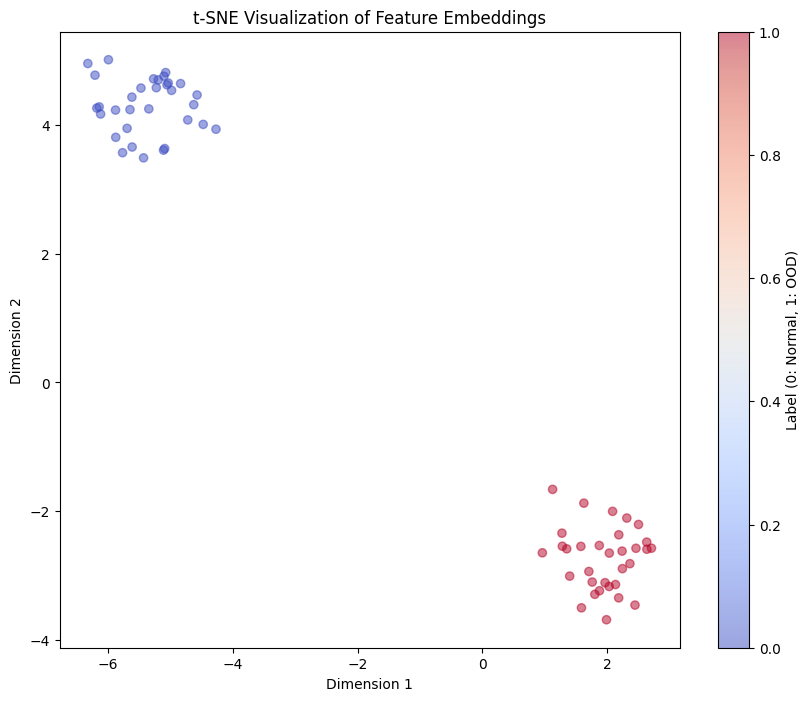

In [ ]:

# Sample a subset for visualization
subset_size = 1000
subset_features = features[:subset_size].cpu().numpy()
subset_labels = labels[:subset_size].cpu().numpy()  

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(subset_features)

plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=subset_labels, cmap='coolwarm', alpha=0.5)
plt.title('t-SNE Visualization of Feature Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Label (0: Normal, 1: OOD)')
plt.show()

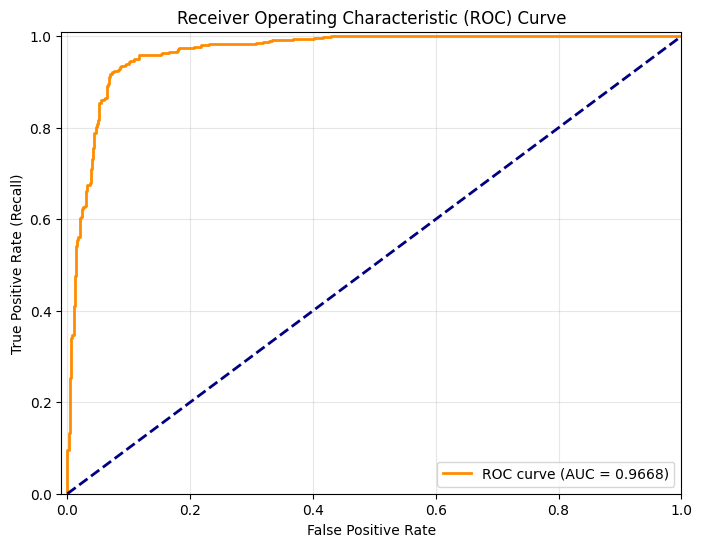

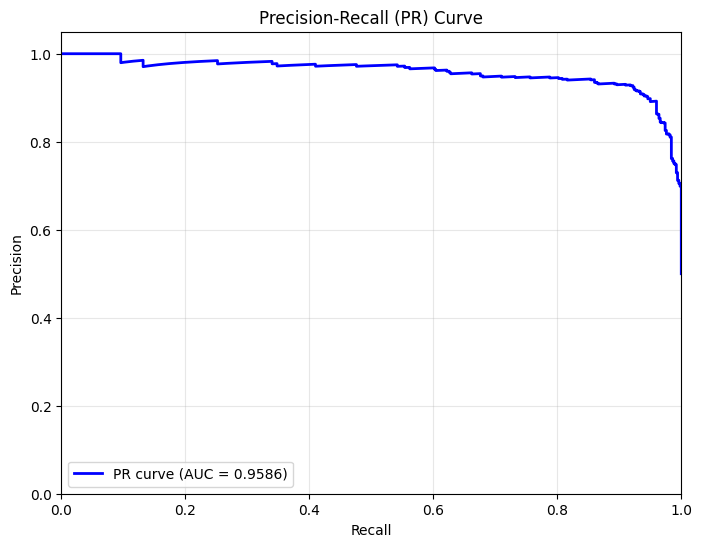

<ipython-input-33-cba7d9b15b7f>:45: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores[labels == 0], shade=True, color='green', label='In-Distribution (ID)')
<ipython-input-33-cba7d9b15b7f>:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores[labels == 1], shade=True, color='red', label='Out-of-Distribution (OOD)')


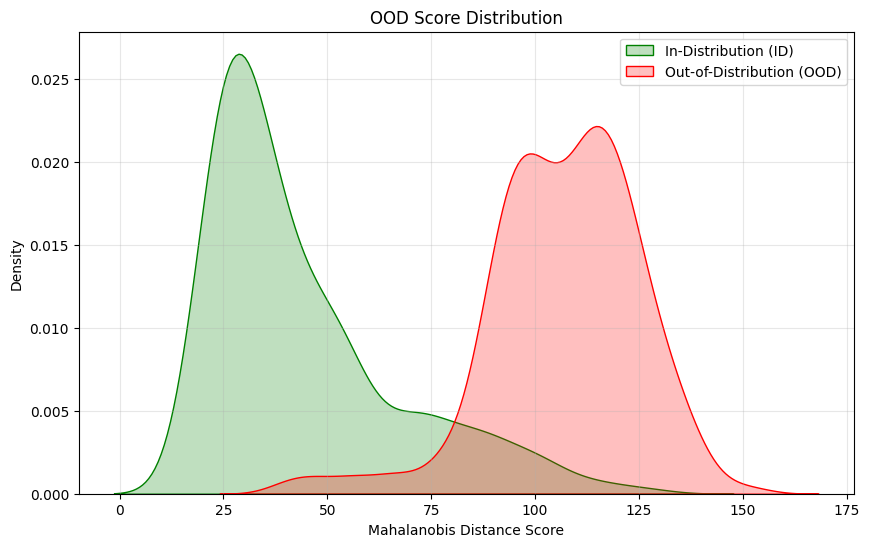

In [ ]:
def plot_roc_curve(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

def plot_precision_recall_curve(labels, scores):
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    pr_auc = average_precision_score(labels, scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue',
             lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.show()

def plot_score_distribution(labels, scores):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(scores[labels == 0], shade=True, color='green', label='In-Distribution (ID)')
    sns.kdeplot(scores[labels == 1], shade=True, color='red', label='Out-of-Distribution (OOD)')
    plt.xlabel('Mahalanobis Distance Score')
    plt.ylabel('Density')
    plt.title('OOD Score Distribution')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Plot ROC Curve
plot_roc_curve(labels_binary, scores_val)

# Plot Precision-Recall Curve
plot_precision_recall_curve(labels_binary, scores_val)

# Plot OOD Score Distribution
plot_score_distribution(labels_binary, scores_val)

In [ ]:
def calculate_fpr_at_tpr(labels, scores, target_tpr=0.95):
    """
    Calculates the False Positive Rate (FPR) at a specified True Positive Rate (TPR).

    Args:
        labels (np.ndarray): Ground truth binary labels (0 for ID, 1 for OOD).
        scores (np.ndarray): Predicted scores (Mahalanobis distances).
        target_tpr (float, optional): The desired True Positive Rate. Defaults to 0.95.

    Returns:
        fpr_at_target (float): FPR at the specified TPR.
        threshold_at_target (float): The threshold corresponding to the specified TPR.
    """
    fpr, tpr, thresholds = roc_curve(labels, scores)

    # Find the threshold closest to the target TPR
    idx = np.argmin(np.abs(tpr - target_tpr))
    fpr_at_target = fpr[idx]
    threshold_at_target = thresholds[idx]

    return fpr_at_target, threshold_at_target

# Calculate FPR@95% TPR
fpr_95, threshold_95 = calculate_fpr_at_tpr(labels_val, scores_val, target_tpr=0.95)
print(f"FPR@95% TPR: {fpr_95:.4f}")
print(f"Threshold at FPR@95% TPR: {threshold_95:.4f}")

FPR@95% TPR: 0.1080
Threshold at FPR@95% TPR: 77.6099


In [ ]:
def compute_metrics_at_threshold(labels, scores, threshold):
    """
    Computes Precision, Recall, and F1-Score at a specified threshold.

    Args:
        labels (np.ndarray): Ground truth binary labels (0 for ID, 1 for OOD).
        scores (np.ndarray): Predicted scores (Mahalanobis distances).
        threshold (float): The threshold to classify samples.

    Returns:
        precision (float): Precision at the threshold.
        recall (float): Recall at the threshold.
        f1 (float): F1-Score at the threshold.
    """
    # Predict OOD if score >= threshold
    preds = (scores >= threshold).astype(int)

    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)

    return precision, recall, f1

# Compute metrics at the optimal threshold
precision_95, recall_95, f1_95 = compute_metrics_at_threshold(labels_val, scores_val, threshold_95)
print(f"Precision at FPR@95% TPR: {precision_95:.4f}")
print(f"Recall at FPR@95% TPR: {recall_95:.4f}")
print(f"F1-Score at FPR@95% TPR: {f1_95:.4f}")

Precision at FPR@95% TPR: 0.8979
Recall at FPR@95% TPR: 0.9500
F1-Score at FPR@95% TPR: 0.9232


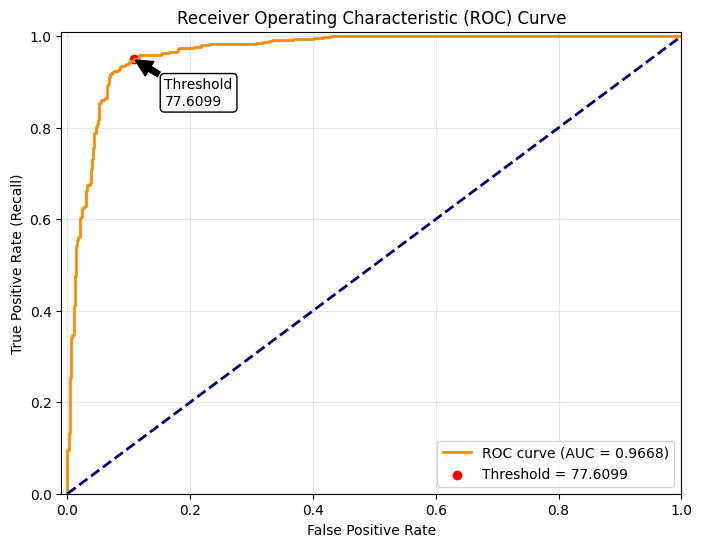

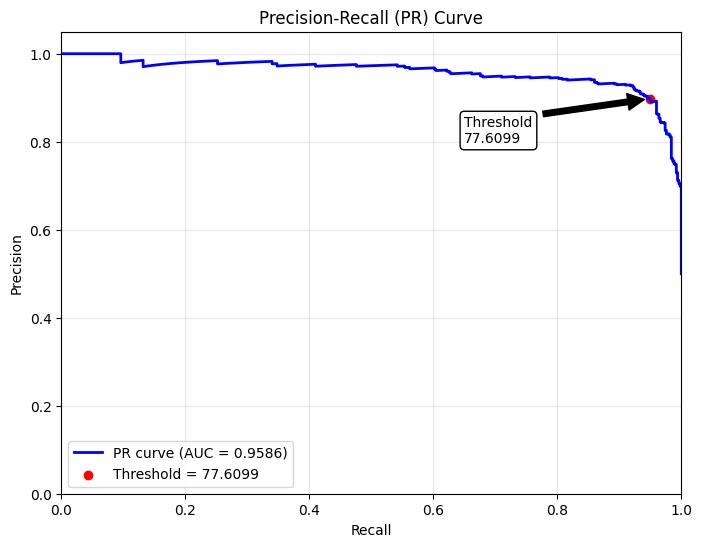

<ipython-input-36-938449039316>:62: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores[labels == 0], shade=True, color='green', label='In-Distribution (ID)')
<ipython-input-36-938449039316>:63: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores[labels == 1], shade=True, color='red', label='Out-of-Distribution (OOD)')


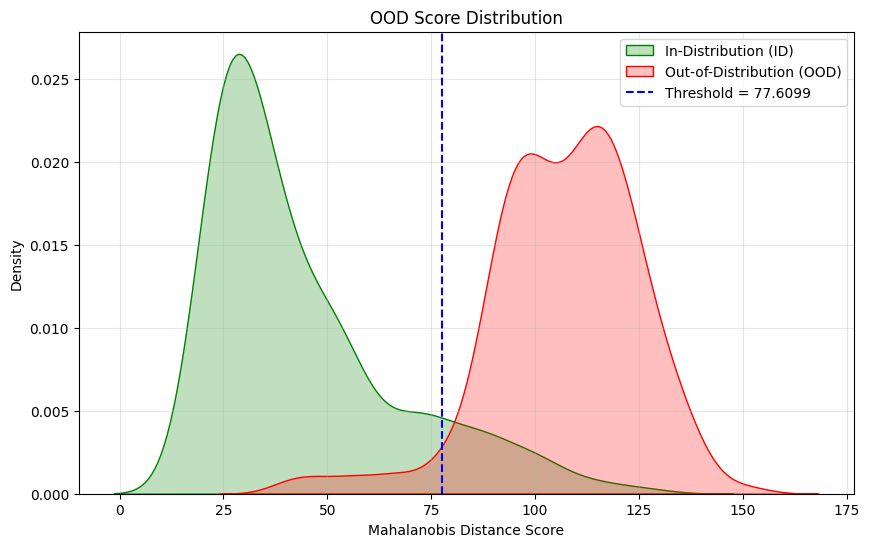

In [ ]:
# Define plotting functions 
def plot_roc_with_threshold(labels, scores, threshold, fpr_at_target, tpr_at_target):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Plot the optimal threshold point
    plt.scatter(fpr_at_target, tpr_at_target, marker='o', color='red', label=f'Threshold = {threshold:.4f}')
    plt.annotate(f'Threshold\n{threshold:.4f}',
                 xy=(fpr_at_target, tpr_at_target),
                 xytext=(fpr_at_target + 0.05, tpr_at_target - 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

def plot_pr_with_threshold(labels, scores, threshold, precision, recall):
    precision_vals, recall_vals, thresholds = precision_recall_curve(labels, scores)
    pr_auc = average_precision_score(labels, scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, color='blue',
             lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')

    # Find the precision and recall at the optimal threshold
    # Find the index where scores >= threshold
    preds = (scores >= threshold).astype(int)
    precision_opt = precision_score(labels, preds, zero_division=0)
    recall_opt = recall_score(labels, preds, zero_division=0)

    plt.scatter(recall_opt, precision_opt, marker='o', color='red', label=f'Threshold = {threshold:.4f}')
    plt.annotate(f'Threshold\n{threshold:.4f}',
                 xy=(recall_opt, precision_opt),
                 xytext=(recall_opt - 0.3, precision_opt - 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.show()

def plot_score_distribution_with_threshold(labels, scores, threshold):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(scores[labels == 0], shade=True, color='green', label='In-Distribution (ID)')
    sns.kdeplot(scores[labels == 1], shade=True, color='red', label='Out-of-Distribution (OOD)')
    plt.axvline(x=threshold, color='blue', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.xlabel('Mahalanobis Distance Score')
    plt.ylabel('Density')
    plt.title('OOD Score Distribution')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Plot ROC Curve with Threshold
plot_roc_with_threshold(labels_binary, scores_val, threshold_95, fpr_95, 0.95)

# Plot Precision-Recall Curve with Threshold
plot_pr_with_threshold(labels_binary, scores_val, threshold_95, precision_95, recall_95)

# Plot OOD Score Distribution with Threshold
plot_score_distribution_with_threshold(labels_binary, scores_val, threshold_95)

Computing Mahalanobis Scores on X_test: 100%|██████████| 157/157 [00:24<00:00,  6.43it/s]
<ipython-input-43-7a56a04a773a>:93: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores, shade=True, color='blue', label='Test Set')


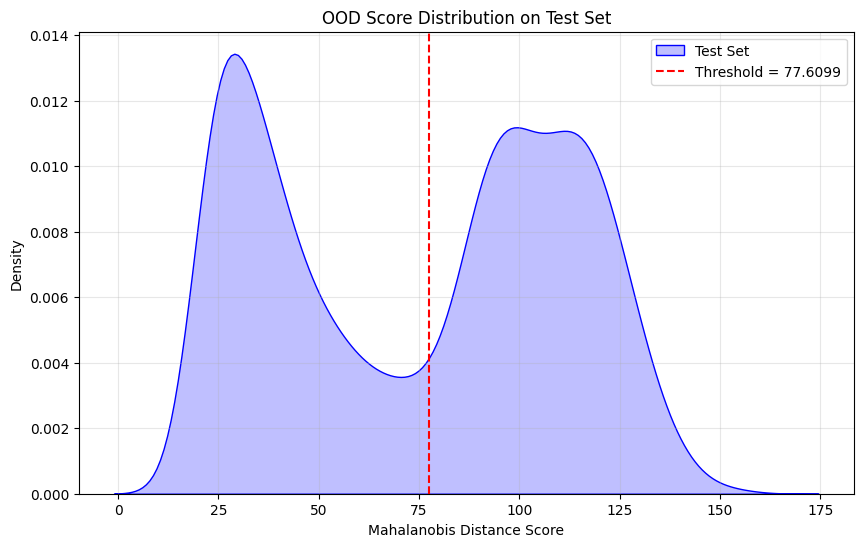

Predictions saved to 3.pt


In [ ]:
# -----------------------------
# 9. Prepare the X_test DataLoader
# -----------------------------

test_transform = get_binary_transforms()

# Create the Test Dataset using CustomBinaryDataset with labels=None
test_dataset = CustomBinaryDataset(X_test, labels=None, transform=test_transform)

# Create the Test DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# -----------------------------
# 10. Compute Mahalanobis Scores on X_test
# -----------------------------

def compute_mahalanobis_scores_unlabeled(feature_extractor, dataloader, mean, inv_cov, device):
    """
    Computes Mahalanobis scores for all samples in the provided dataloader without labels.

    Args:
        feature_extractor (nn.Module): Model to extract features from images.
        dataloader (DataLoader): DataLoader for test data.
        mean (np.ndarray): Mean vector of the normal class features.
        inv_cov (np.ndarray): Inverse covariance matrix of the normal class features.
        device (str): Device to perform computations on ('cuda' or 'cpu').

    Returns:
        scores (np.ndarray): Array of Mahalanobis distance scores for each sample.
    """
    scores = []

    for images in tqdm(dataloader, desc="Computing Mahalanobis Scores on X_test"):
        images = images.to(device)
        with torch.no_grad():
            feats = feature_extractor(images)
            feats = feats.cpu().numpy()

        for feat in feats:
            delta = feat - mean
            score = np.sqrt(np.dot(np.dot(delta, inv_cov), delta))
            scores.append(score)

    scores = np.array(scores)
    return scores

# Compute Mahalanobis scores for X_test
scores_test = compute_mahalanobis_scores_unlabeled(
     feature_extractor, test_loader, class_mean, class_inv_cov, device
)

# -----------------------------
# 11. Assign OOD Predictions Based on the 95% TPR Threshold
# -----------------------------

def assign_labels(scores, threshold):
    """
    Assigns OOD labels based on the Mahalanobis distance threshold.

    Args:
        scores (np.ndarray): Mahalanobis distance scores.
        threshold (float): Threshold for classifying OOD.

    Returns:
        predictions (np.ndarray): Binary predictions (0 for ID, 1 for OOD).
    """
    predictions = (scores >= threshold).astype(int)
    return predictions

# Assign labels based on threshold_95
predicted_labels_test = assign_labels(scores_test, threshold_95)

# -----------------------------
# 12. Plot the Mahalanobis Score Distribution with Threshold
# -----------------------------

def plot_score_distribution_with_threshold(scores, threshold, title='OOD Score Distribution on Test Set'):
    """
    Plots the distribution of Mahalanobis scores and marks the threshold.

    Args:
        scores (np.ndarray): Mahalanobis distance scores.
        threshold (float): Threshold for classifying OOD.
        title (str, optional): Title of the plot. Defaults to 'OOD Score Distribution on Test Set'.
    """
    plt.figure(figsize=(10, 6))
    sns.kdeplot(scores, shade=True, color='blue', label='Test Set')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.xlabel('Mahalanobis Distance Score')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Plot the score distribution
plot_score_distribution_with_threshold(scores_test, threshold_95)

# -----------------------------
# 13. Save the Predicted Labels as '3.pt'
# -----------------------------

def save_predictions(predictions, filename='3.pt'):
    """
    Saves the predicted labels to a .pt file.

    Args:
        predictions (np.ndarray): Array of binary predictions (0 for ID, 1 for OOD).
        filename (str, optional): Filename for the saved predictions. Defaults to '3.pt'.
    """
    # Convert predictions to a Torch tensor
    predictions_tensor = torch.from_numpy(predictions).long()

    # Save the tensor
    torch.save(predictions_tensor, filename)
    print(f"Predictions saved to {filename}")

# Save the predicted labels for X_test
save_predictions(predicted_labels_test, filename='3.pt')



In [40]:
# Load the existing '1.pt' file
labels = torch.load('3.pt')  # Assuming '1.pt' contains a NumPy array of labels

# Verify the type and shape of the loaded data
print(f"Type of loaded data: {type(labels)}")
print(f"Shape of labels: {labels.shape}")

# Initialize a list to store original x values
X_test_original = []    

# Iterate through the ood_test_data
for idx in range(len(ood_test_data)):
    item = ood_test_data[idx]
    if isinstance(item, (tuple, list)) and len(item) >= 1:
        x = item[0]  # Assuming the first element is the image/tensor
        if isinstance(x, torch.Tensor):
            X_test_original.append(x.numpy())
        elif isinstance(x, np.ndarray):
            X_test_original.append(x)
        else:
            print(f"Unsupported data type at index {idx}: {type(x)}")
    else:
        print(f"Unexpected item format at index {idx}: {item}")

# Convert list to NumPy array
X_test_original = np.array(X_test_original)

# Verify the shape of the extracted x values
print(f"Shape of original x values: {X_test_original.shape}")
# Verify that the number of labels matches the number of x_original samples
if labels.shape[0] != X_test_original.shape[0]:
    raise ValueError("Number of labels and x_original samples do not match.")

# Create a dictionary to hold both labels and original x values
combined_data = {
    'x_original': X_test_original,  # NumPy array of original x values
    'labels': labels            # NumPy array of labels
}

# Verify the combined structure
print("Keys in combined_data:", combined_data.keys())
print(f"Shape of 'labels': {combined_data['labels'].shape}")
print(f"Shape of 'x_original': {combined_data['x_original'].shape}")

torch.save(combined_data, '3_updated.pt')

print("Updated data saved to '3_updated.pt'.")

/var/folders/25/r3kdxyns1cd4nyp45rchscxh0000gn/T/ipykernel_40972/2461382808.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load('3.pt')  # Assuming '1.pt

Type of loaded data: <class 'torch.Tensor'>
Shape of labels: torch.Size([10000])
Shape of original x values: (10000, 1, 32, 32)
Keys in combined_data: dict_keys(['x_original', 'labels'])
Shape of 'labels': torch.Size([10000])
Shape of 'x_original': (10000, 1, 32, 32)
Updated data saved to '3_updated.pt'.
